In [1]:
import afqinsight.nn.tf_models as nn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from afqinsight.datasets import AFQDataset
from afqinsight.nn.tf_models import cnn_lenet, mlp4, cnn_vgg, lstm1v0, lstm1, lstm2, blstm1, blstm2, lstm_fcn, cnn_resnet
from sklearn.impute import SimpleImputer
import os.path
# Harmonization
from sklearn.model_selection import train_test_split
from neurocombat_sklearn import CombatModel

In [2]:
afq_dataset = AFQDataset.from_files(
    fn_nodes="../data/raw/combined_tract_profiles.csv",
    fn_subjects="../data/raw/participants_updated_id.csv",
    dwi_metrics=["dki_fa", "dki_md", "dki_mk"],
    index_col="subject_id",
    target_cols=["age", "dl_qc_score", "scan_site_id"],
    label_encode_cols=["scan_site_id"]
)

In [3]:
afq_dataset.drop_target_na()

In [4]:
print(len(afq_dataset.subjects))
print(afq_dataset.X.shape)
print(afq_dataset.y.shape)

1865
(1865, 7200)
(1865, 3)


In [5]:
full_dataset = list(afq_dataset.as_tensorflow_dataset().as_numpy_iterator())

2022-03-10 14:48:10.558160: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
X = np.concatenate([xx[0][None] for xx in full_dataset], 0)
y = np.array([yy[1][0] for yy in full_dataset])
qc = np.array([yy[1][1] for yy in full_dataset])
site = np.array([yy[1][2] for yy in full_dataset])

In [7]:
X = X[qc>0]
y = y[qc>0]
site = site[qc>0]

In [8]:
# Split the data into train and test sets:
X_train, X_test, y_train, y_test, site_train, site_test = train_test_split(X, y, site, test_size=0.2, random_state=42)

In [9]:
imputer = SimpleImputer(strategy="median")

In [10]:
# Impute train and test separately:
X_train = np.concatenate([imputer.fit_transform(X_train[..., ii])[:, :, None] for ii in range(X_train.shape[-1])], -1)
X_test = np.concatenate([imputer.fit_transform(X_test[..., ii])[:, :, None] for ii in range(X_test.shape[-1])], -1)

In [11]:
# Combat
X_train = np.concatenate([CombatModel().fit_transform(X_train[..., ii], site_train[:, None], None, None)[:, :, None] for ii in range(X_train.shape[-1])], -1)
X_test = np.concatenate([CombatModel().fit_transform(X_test[..., ii], site_test[:, None], None, None)[:, :, None] for ii in range(X_test.shape[-1])], -1)

In [12]:
n_epochs = 1000

# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    mode="min",
    patience=100
)

# ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=20,
    verbose=1,
)

In [26]:
# Generate evaluation results, training history, number of epochs
def model_history(model_name, ckpt_filepath, lr):
    model = model_name(input_shape=(100, 72), n_classes=1, output_activation=None, verbose=True)
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['mean_squared_error', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mean_absolute_error'])
    # ModelCheckpoint
    ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    )
    # CSVLogger
    log = tf.keras.callbacks.CSVLogger(filename= str(model_name) + '.csv', append=True)
    callbacks = [early_stopping, ckpt, reduce_lr, log]
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=128, validation_split=0.2,
                        callbacks=callbacks)
    model.load_weights(ckpt_filepath)
    eval_model = model.evaluate(X_test, y_test)
    count_epochs = history.epoch[-1]+1
    return eval_model, history, count_epochs

In [92]:
# Visualization of mean_squared_error, root_mean_squared_error, and mean_absolute_error
def vis_results(model_name, history, epoch):
    fig, ax = plt.subplots(1, 3, figsize=[20,5])
    fig.suptitle(model_name + ' epoch = ' + str(epoch), fontsize=15)
    ax[0].plot(history.history['loss'][10:])
    ax[0].plot(history.history['val_loss'][10:])
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_title('Mean Squared Error')
    ax[0].legend(['train', 'val'], loc='upper right')
    ax[1].plot(history.history['rmse'][10:])
    ax[1].plot(history.history['val_rmse'][10:])
    ax[1].set_ylabel('roor_mean_squared_error')
    ax[1].set_xlabel('epoch')
    ax[1].set_title('Root Mean Squared Error')
    ax[1].legend(['train', 'val'], loc='upper right')
    ax[2].plot(history.history['mean_absolute_error'][10:])
    ax[2].plot(history.history['val_mean_absolute_error'][10:])
    ax[2].set_ylabel('mean_absolute_error')
    ax[2].set_xlabel('epoch')
    ax[2].set_title('Mean Absolute Error')
    ax[2].legend(['train', 'val'], loc='upper right')
    plt.show()

### cnn_lenet

In [27]:
eval_lenet, history_lenet, epochs_lenet = model_history(cnn_lenet, '/tmp/lenet.h5', 0.001)

pooling layers: 4
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 conv1d_23 (Conv1D)          (None, 100, 6)            1302      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 50, 6)            0         
 g1D)                                                            
                                                                 
 conv1d_24 (Conv1D)          (None, 50, 16)            304       
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 25, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 25, 2

Epoch 13/1000
 9/10 [==========================>...] - ETA: 0s - loss: 18.2777 - mean_squared_error: 18.2777 - rmse: 4.2752 - mean_absolute_error: 3.3340
Epoch 00013: val_loss did not improve from 8.71021
10/10 [==============================] - 0s 17ms/step - loss: 18.2236 - mean_squared_error: 18.2236 - rmse: 4.2689 - mean_absolute_error: 3.3326 - val_loss: 8.7212 - val_mean_squared_error: 8.7212 - val_rmse: 2.9532 - val_mean_absolute_error: 2.3285 - lr: 0.0010
Epoch 14/1000
 9/10 [==========================>...] - ETA: 0s - loss: 16.7381 - mean_squared_error: 16.7381 - rmse: 4.0912 - mean_absolute_error: 3.2578
Epoch 00014: val_loss did not improve from 8.71021
10/10 [==============================] - 0s 18ms/step - loss: 16.7480 - mean_squared_error: 16.7480 - rmse: 4.0924 - mean_absolute_error: 3.2595 - val_loss: 9.4312 - val_mean_squared_error: 9.4312 - val_rmse: 3.0710 - val_mean_absolute_error: 2.3159 - lr: 0.0010
Epoch 15/1000
 7/10 [====================>.........] - ETA: 0s -

 9/10 [==========================>...] - ETA: 0s - loss: 17.2544 - mean_squared_error: 17.2544 - rmse: 4.1538 - mean_absolute_error: 3.3043
Epoch 00030: val_loss did not improve from 8.18927
10/10 [==============================] - 0s 17ms/step - loss: 17.1648 - mean_squared_error: 17.1648 - rmse: 4.1430 - mean_absolute_error: 3.2950 - val_loss: 9.5906 - val_mean_squared_error: 9.5906 - val_rmse: 3.0969 - val_mean_absolute_error: 2.3135 - lr: 0.0010
Epoch 31/1000
 9/10 [==========================>...] - ETA: 0s - loss: 15.6980 - mean_squared_error: 15.6980 - rmse: 3.9621 - mean_absolute_error: 3.1454
Epoch 00031: val_loss did not improve from 8.18927
10/10 [==============================] - 0s 17ms/step - loss: 15.7531 - mean_squared_error: 15.7531 - rmse: 3.9690 - mean_absolute_error: 3.1517 - val_loss: 9.5329 - val_mean_squared_error: 9.5329 - val_rmse: 3.0875 - val_mean_absolute_error: 2.3007 - lr: 0.0010
Epoch 32/1000
 8/10 [=======================>......] - ETA: 0s - loss: 15.7890

Epoch 48/1000
 9/10 [==========================>...] - ETA: 0s - loss: 13.9755 - mean_squared_error: 13.9755 - rmse: 3.7384 - mean_absolute_error: 2.9676
Epoch 00048: val_loss did not improve from 7.93895
10/10 [==============================] - 0s 16ms/step - loss: 13.9917 - mean_squared_error: 13.9917 - rmse: 3.7405 - mean_absolute_error: 2.9704 - val_loss: 7.9777 - val_mean_squared_error: 7.9777 - val_rmse: 2.8245 - val_mean_absolute_error: 2.2320 - lr: 0.0010
Epoch 49/1000
 9/10 [==========================>...] - ETA: 0s - loss: 14.3673 - mean_squared_error: 14.3673 - rmse: 3.7904 - mean_absolute_error: 2.9709
Epoch 00049: val_loss did not improve from 7.93895
10/10 [==============================] - 0s 17ms/step - loss: 14.3585 - mean_squared_error: 14.3585 - rmse: 3.7893 - mean_absolute_error: 2.9731 - val_loss: 8.2951 - val_mean_squared_error: 8.2951 - val_rmse: 2.8801 - val_mean_absolute_error: 2.2261 - lr: 0.0010
Epoch 50/1000
 8/10 [=======================>......] - ETA: 0s -

Epoch 65/1000
 8/10 [=======================>......] - ETA: 0s - loss: 13.8965 - mean_squared_error: 13.8965 - rmse: 3.7278 - mean_absolute_error: 2.9696
Epoch 00065: val_loss improved from 7.07634 to 7.02672, saving model to /tmp/lenet.h5
10/10 [==============================] - 0s 20ms/step - loss: 13.7427 - mean_squared_error: 13.7427 - rmse: 3.7071 - mean_absolute_error: 2.9470 - val_loss: 7.0267 - val_mean_squared_error: 7.0267 - val_rmse: 2.6508 - val_mean_absolute_error: 2.1622 - lr: 0.0010
Epoch 66/1000
 8/10 [=======================>......] - ETA: 0s - loss: 13.5966 - mean_squared_error: 13.5966 - rmse: 3.6874 - mean_absolute_error: 2.8827
Epoch 00066: val_loss did not improve from 7.02672
10/10 [==============================] - 0s 18ms/step - loss: 13.8380 - mean_squared_error: 13.8380 - rmse: 3.7200 - mean_absolute_error: 2.9225 - val_loss: 7.1349 - val_mean_squared_error: 7.1349 - val_rmse: 2.6711 - val_mean_absolute_error: 2.2129 - lr: 0.0010
Epoch 67/1000
 8/10 [========

 9/10 [==========================>...] - ETA: 0s - loss: 11.7669 - mean_squared_error: 11.7669 - rmse: 3.4303 - mean_absolute_error: 2.6833
Epoch 00082: val_loss did not improve from 6.70374
10/10 [==============================] - 0s 18ms/step - loss: 11.7824 - mean_squared_error: 11.7824 - rmse: 3.4326 - mean_absolute_error: 2.6866 - val_loss: 8.0299 - val_mean_squared_error: 8.0299 - val_rmse: 2.8337 - val_mean_absolute_error: 2.1773 - lr: 0.0010
Epoch 83/1000
 9/10 [==========================>...] - ETA: 0s - loss: 12.3223 - mean_squared_error: 12.3223 - rmse: 3.5103 - mean_absolute_error: 2.7680
Epoch 00083: val_loss did not improve from 6.70374
10/10 [==============================] - 0s 17ms/step - loss: 12.3004 - mean_squared_error: 12.3004 - rmse: 3.5072 - mean_absolute_error: 2.7687 - val_loss: 7.1473 - val_mean_squared_error: 7.1473 - val_rmse: 2.6734 - val_mean_absolute_error: 2.0813 - lr: 0.0010
Epoch 84/1000
 9/10 [==========================>...] - ETA: 0s - loss: 12.2664

 9/10 [==========================>...] - ETA: 0s - loss: 12.5285 - mean_squared_error: 12.5285 - rmse: 3.5396 - mean_absolute_error: 2.7426
Epoch 00099: val_loss did not improve from 6.34813
10/10 [==============================] - 0s 17ms/step - loss: 12.4968 - mean_squared_error: 12.4968 - rmse: 3.5351 - mean_absolute_error: 2.7392 - val_loss: 7.2873 - val_mean_squared_error: 7.2873 - val_rmse: 2.6995 - val_mean_absolute_error: 2.2283 - lr: 0.0010
Epoch 100/1000
 9/10 [==========================>...] - ETA: 0s - loss: 12.6778 - mean_squared_error: 12.6778 - rmse: 3.5606 - mean_absolute_error: 2.7751
Epoch 00100: val_loss did not improve from 6.34813
10/10 [==============================] - 0s 19ms/step - loss: 12.6921 - mean_squared_error: 12.6921 - rmse: 3.5626 - mean_absolute_error: 2.7780 - val_loss: 6.9891 - val_mean_squared_error: 6.9891 - val_rmse: 2.6437 - val_mean_absolute_error: 2.1682 - lr: 0.0010
Epoch 101/1000
 9/10 [==========================>...] - ETA: 0s - loss: 11.66

 9/10 [==========================>...] - ETA: 0s - loss: 11.0324 - mean_squared_error: 11.0324 - rmse: 3.3215 - mean_absolute_error: 2.6070
Epoch 00116: val_loss did not improve from 5.88012
10/10 [==============================] - 0s 17ms/step - loss: 10.9863 - mean_squared_error: 10.9863 - rmse: 3.3146 - mean_absolute_error: 2.6024 - val_loss: 7.2541 - val_mean_squared_error: 7.2541 - val_rmse: 2.6933 - val_mean_absolute_error: 2.0691 - lr: 0.0010
Epoch 117/1000
 9/10 [==========================>...] - ETA: 0s - loss: 11.3149 - mean_squared_error: 11.3149 - rmse: 3.3638 - mean_absolute_error: 2.6101
Epoch 00117: val_loss did not improve from 5.88012
10/10 [==============================] - 0s 17ms/step - loss: 11.3012 - mean_squared_error: 11.3012 - rmse: 3.3617 - mean_absolute_error: 2.6088 - val_loss: 8.3867 - val_mean_squared_error: 8.3867 - val_rmse: 2.8960 - val_mean_absolute_error: 2.2125 - lr: 0.0010
Epoch 118/1000
 9/10 [==========================>...] - ETA: 0s - loss: 13.19

 9/10 [==========================>...] - ETA: 0s - loss: 10.4000 - mean_squared_error: 10.4000 - rmse: 3.2249 - mean_absolute_error: 2.5230
Epoch 00133: val_loss did not improve from 5.56538
10/10 [==============================] - 0s 17ms/step - loss: 10.3859 - mean_squared_error: 10.3859 - rmse: 3.2227 - mean_absolute_error: 2.5232 - val_loss: 6.3231 - val_mean_squared_error: 6.3231 - val_rmse: 2.5146 - val_mean_absolute_error: 1.9698 - lr: 0.0010
Epoch 134/1000
 9/10 [==========================>...] - ETA: 0s - loss: 10.1443 - mean_squared_error: 10.1443 - rmse: 3.1850 - mean_absolute_error: 2.4909
Epoch 00134: val_loss did not improve from 5.56538
10/10 [==============================] - 0s 18ms/step - loss: 10.2004 - mean_squared_error: 10.2004 - rmse: 3.1938 - mean_absolute_error: 2.4973 - val_loss: 5.6840 - val_mean_squared_error: 5.6840 - val_rmse: 2.3841 - val_mean_absolute_error: 1.9176 - lr: 0.0010
Epoch 135/1000
 9/10 [==========================>...] - ETA: 0s - loss: 10.93

Epoch 151/1000
 9/10 [==========================>...] - ETA: 0s - loss: 9.9557 - mean_squared_error: 9.9557 - rmse: 3.1553 - mean_absolute_error: 2.4597  
Epoch 00151: val_loss did not improve from 5.47677
10/10 [==============================] - 0s 18ms/step - loss: 9.9493 - mean_squared_error: 9.9493 - rmse: 3.1542 - mean_absolute_error: 2.4571 - val_loss: 6.9830 - val_mean_squared_error: 6.9830 - val_rmse: 2.6425 - val_mean_absolute_error: 2.0433 - lr: 0.0010
Epoch 152/1000
 8/10 [=======================>......] - ETA: 0s - loss: 9.8623 - mean_squared_error: 9.8623 - rmse: 3.1404 - mean_absolute_error: 2.4497 
Epoch 00152: val_loss did not improve from 5.47677
10/10 [==============================] - 0s 17ms/step - loss: 9.6894 - mean_squared_error: 9.6894 - rmse: 3.1128 - mean_absolute_error: 2.4348 - val_loss: 5.6069 - val_mean_squared_error: 5.6069 - val_rmse: 2.3679 - val_mean_absolute_error: 1.8691 - lr: 0.0010
Epoch 153/1000
 9/10 [==========================>...] - ETA: 0s - l

 8/10 [=======================>......] - ETA: 0s - loss: 9.0599 - mean_squared_error: 9.0599 - rmse: 3.0100 - mean_absolute_error: 2.3617 
Epoch 00168: val_loss did not improve from 5.20007
10/10 [==============================] - 0s 18ms/step - loss: 9.1011 - mean_squared_error: 9.1011 - rmse: 3.0168 - mean_absolute_error: 2.3696 - val_loss: 5.2625 - val_mean_squared_error: 5.2625 - val_rmse: 2.2940 - val_mean_absolute_error: 1.8386 - lr: 5.0000e-04
Epoch 169/1000
 9/10 [==========================>...] - ETA: 0s - loss: 8.9363 - mean_squared_error: 8.9363 - rmse: 2.9894 - mean_absolute_error: 2.3176
Epoch 00169: val_loss did not improve from 5.20007
10/10 [==============================] - 0s 17ms/step - loss: 8.8896 - mean_squared_error: 8.8896 - rmse: 2.9815 - mean_absolute_error: 2.3116 - val_loss: 5.2416 - val_mean_squared_error: 5.2416 - val_rmse: 2.2895 - val_mean_absolute_error: 1.8119 - lr: 5.0000e-04
Epoch 170/1000
 9/10 [==========================>...] - ETA: 0s - loss: 9.03

 9/10 [==========================>...] - ETA: 0s - loss: 8.1636 - mean_squared_error: 8.1636 - rmse: 2.8572 - mean_absolute_error: 2.2168
Epoch 00185: val_loss improved from 5.09065 to 5.05842, saving model to /tmp/lenet.h5
10/10 [==============================] - 0s 18ms/step - loss: 8.1269 - mean_squared_error: 8.1269 - rmse: 2.8508 - mean_absolute_error: 2.2131 - val_loss: 5.0584 - val_mean_squared_error: 5.0584 - val_rmse: 2.2491 - val_mean_absolute_error: 1.7832 - lr: 5.0000e-04
Epoch 186/1000
 8/10 [=======================>......] - ETA: 0s - loss: 8.2230 - mean_squared_error: 8.2230 - rmse: 2.8676 - mean_absolute_error: 2.2775
Epoch 00186: val_loss did not improve from 5.05842
10/10 [==============================] - 0s 18ms/step - loss: 8.4380 - mean_squared_error: 8.4380 - rmse: 2.9048 - mean_absolute_error: 2.2845 - val_loss: 5.1830 - val_mean_squared_error: 5.1830 - val_rmse: 2.2766 - val_mean_absolute_error: 1.7856 - lr: 5.0000e-04
Epoch 187/1000
 9/10 [====================

 8/10 [=======================>......] - ETA: 0s - loss: 8.4599 - mean_squared_error: 8.4599 - rmse: 2.9086 - mean_absolute_error: 2.2453 
Epoch 00202: val_loss improved from 4.97591 to 4.97147, saving model to /tmp/lenet.h5
10/10 [==============================] - 0s 19ms/step - loss: 8.3943 - mean_squared_error: 8.3943 - rmse: 2.8973 - mean_absolute_error: 2.2295 - val_loss: 4.9715 - val_mean_squared_error: 4.9715 - val_rmse: 2.2297 - val_mean_absolute_error: 1.7421 - lr: 5.0000e-04
Epoch 203/1000
 8/10 [=======================>......] - ETA: 0s - loss: 7.6090 - mean_squared_error: 7.6090 - rmse: 2.7584 - mean_absolute_error: 2.1519
Epoch 00203: val_loss did not improve from 4.97147
10/10 [==============================] - 0s 18ms/step - loss: 7.7844 - mean_squared_error: 7.7844 - rmse: 2.7901 - mean_absolute_error: 2.1760 - val_loss: 5.0272 - val_mean_squared_error: 5.0272 - val_rmse: 2.2421 - val_mean_absolute_error: 1.7765 - lr: 5.0000e-04
Epoch 204/1000
 9/10 [===================

 9/10 [==========================>...] - ETA: 0s - loss: 8.0928 - mean_squared_error: 8.0928 - rmse: 2.8448 - mean_absolute_error: 2.1859 
Epoch 00219: val_loss did not improve from 4.87177
10/10 [==============================] - 0s 17ms/step - loss: 8.0740 - mean_squared_error: 8.0740 - rmse: 2.8415 - mean_absolute_error: 2.1844 - val_loss: 5.0972 - val_mean_squared_error: 5.0972 - val_rmse: 2.2577 - val_mean_absolute_error: 1.7891 - lr: 5.0000e-04
Epoch 220/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.7340 - mean_squared_error: 7.7340 - rmse: 2.7810 - mean_absolute_error: 2.1600
Epoch 00220: val_loss did not improve from 4.87177
10/10 [==============================] - 0s 17ms/step - loss: 7.7726 - mean_squared_error: 7.7726 - rmse: 2.7879 - mean_absolute_error: 2.1643 - val_loss: 5.0977 - val_mean_squared_error: 5.0977 - val_rmse: 2.2578 - val_mean_absolute_error: 1.7777 - lr: 5.0000e-04
Epoch 221/1000
 9/10 [==========================>...] - ETA: 0s - loss: 8.00

Epoch 237/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.5357 - mean_squared_error: 7.5357 - rmse: 2.7451 - mean_absolute_error: 2.1179
Epoch 00237: val_loss did not improve from 4.87177

Epoch 00237: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
10/10 [==============================] - 0s 17ms/step - loss: 7.5170 - mean_squared_error: 7.5170 - rmse: 2.7417 - mean_absolute_error: 2.1139 - val_loss: 5.0938 - val_mean_squared_error: 5.0938 - val_rmse: 2.2569 - val_mean_absolute_error: 1.7834 - lr: 5.0000e-04
Epoch 238/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.8695 - mean_squared_error: 7.8695 - rmse: 2.8053 - mean_absolute_error: 2.1557
Epoch 00238: val_loss did not improve from 4.87177
10/10 [==============================] - 0s 17ms/step - loss: 7.8671 - mean_squared_error: 7.8671 - rmse: 2.8048 - mean_absolute_error: 2.1542 - val_loss: 4.9649 - val_mean_squared_error: 4.9649 - val_rmse: 2.2282 - val_mean_absolute_error: 1.749

 9/10 [==========================>...] - ETA: 0s - loss: 7.2665 - mean_squared_error: 7.2665 - rmse: 2.6957 - mean_absolute_error: 2.0807
Epoch 00254: val_loss did not improve from 4.84390
10/10 [==============================] - 0s 17ms/step - loss: 7.2766 - mean_squared_error: 7.2766 - rmse: 2.6975 - mean_absolute_error: 2.0828 - val_loss: 4.8627 - val_mean_squared_error: 4.8627 - val_rmse: 2.2051 - val_mean_absolute_error: 1.7339 - lr: 2.5000e-04
Epoch 255/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.0567 - mean_squared_error: 7.0567 - rmse: 2.6565 - mean_absolute_error: 2.0793
Epoch 00255: val_loss did not improve from 4.84390
10/10 [==============================] - 0s 17ms/step - loss: 7.0452 - mean_squared_error: 7.0452 - rmse: 2.6543 - mean_absolute_error: 2.0763 - val_loss: 4.9654 - val_mean_squared_error: 4.9654 - val_rmse: 2.2283 - val_mean_absolute_error: 1.7424 - lr: 2.5000e-04
Epoch 256/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.381

Epoch 272/1000
 7/10 [====================>.........] - ETA: 0s - loss: 7.5486 - mean_squared_error: 7.5486 - rmse: 2.7475 - mean_absolute_error: 2.1474
Epoch 00272: val_loss did not improve from 4.79758
10/10 [==============================] - 0s 18ms/step - loss: 7.7042 - mean_squared_error: 7.7042 - rmse: 2.7756 - mean_absolute_error: 2.1680 - val_loss: 5.2908 - val_mean_squared_error: 5.2908 - val_rmse: 2.3002 - val_mean_absolute_error: 1.7877 - lr: 2.5000e-04
Epoch 273/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.1385 - mean_squared_error: 7.1385 - rmse: 2.6718 - mean_absolute_error: 2.0426
Epoch 00273: val_loss did not improve from 4.79758
10/10 [==============================] - 0s 17ms/step - loss: 7.1487 - mean_squared_error: 7.1487 - rmse: 2.6737 - mean_absolute_error: 2.0437 - val_loss: 5.0064 - val_mean_squared_error: 5.0064 - val_rmse: 2.2375 - val_mean_absolute_error: 1.7759 - lr: 2.5000e-04
Epoch 274/1000
 9/10 [==========================>...] - ETA: 0

 9/10 [==========================>...] - ETA: 0s - loss: 6.5667 - mean_squared_error: 6.5667 - rmse: 2.5626 - mean_absolute_error: 1.9981
Epoch 00289: val_loss did not improve from 4.76900
10/10 [==============================] - 0s 17ms/step - loss: 6.6083 - mean_squared_error: 6.6083 - rmse: 2.5707 - mean_absolute_error: 2.0018 - val_loss: 4.8451 - val_mean_squared_error: 4.8451 - val_rmse: 2.2012 - val_mean_absolute_error: 1.7338 - lr: 2.5000e-04
Epoch 290/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.7576 - mean_squared_error: 6.7576 - rmse: 2.5995 - mean_absolute_error: 2.0199
Epoch 00290: val_loss did not improve from 4.76900
10/10 [==============================] - 0s 17ms/step - loss: 6.8351 - mean_squared_error: 6.8351 - rmse: 2.6144 - mean_absolute_error: 2.0300 - val_loss: 5.0338 - val_mean_squared_error: 5.0338 - val_rmse: 2.2436 - val_mean_absolute_error: 1.7796 - lr: 2.5000e-04
Epoch 291/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.184

Epoch 307/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.6206 - mean_squared_error: 6.6206 - rmse: 2.5730 - mean_absolute_error: 2.0093
Epoch 00307: val_loss did not improve from 4.76900
10/10 [==============================] - 0s 16ms/step - loss: 6.6109 - mean_squared_error: 6.6109 - rmse: 2.5712 - mean_absolute_error: 2.0082 - val_loss: 4.8758 - val_mean_squared_error: 4.8758 - val_rmse: 2.2081 - val_mean_absolute_error: 1.7500 - lr: 1.2500e-04
Epoch 308/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.0520 - mean_squared_error: 7.0520 - rmse: 2.6556 - mean_absolute_error: 2.0345
Epoch 00308: val_loss did not improve from 4.76900
10/10 [==============================] - 0s 17ms/step - loss: 7.0687 - mean_squared_error: 7.0687 - rmse: 2.6587 - mean_absolute_error: 2.0382 - val_loss: 4.8335 - val_mean_squared_error: 4.8335 - val_rmse: 2.1985 - val_mean_absolute_error: 1.7347 - lr: 1.2500e-04
Epoch 309/1000
 8/10 [=======================>......] - ETA: 0

 9/10 [==========================>...] - ETA: 0s - loss: 7.1401 - mean_squared_error: 7.1401 - rmse: 2.6721 - mean_absolute_error: 2.0775
Epoch 00324: val_loss did not improve from 4.73273
10/10 [==============================] - 0s 17ms/step - loss: 7.1279 - mean_squared_error: 7.1279 - rmse: 2.6698 - mean_absolute_error: 2.0774 - val_loss: 4.7734 - val_mean_squared_error: 4.7734 - val_rmse: 2.1848 - val_mean_absolute_error: 1.7199 - lr: 1.2500e-04
Epoch 325/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.9419 - mean_squared_error: 6.9419 - rmse: 2.6348 - mean_absolute_error: 2.0265
Epoch 00325: val_loss did not improve from 4.73273
10/10 [==============================] - 0s 17ms/step - loss: 6.9274 - mean_squared_error: 6.9274 - rmse: 2.6320 - mean_absolute_error: 2.0268 - val_loss: 4.7646 - val_mean_squared_error: 4.7646 - val_rmse: 2.1828 - val_mean_absolute_error: 1.7131 - lr: 1.2500e-04
Epoch 326/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.884

Epoch 342/1000
 8/10 [=======================>......] - ETA: 0s - loss: 6.4723 - mean_squared_error: 6.4723 - rmse: 2.5441 - mean_absolute_error: 1.9974
Epoch 00342: val_loss did not improve from 4.71831
10/10 [==============================] - 0s 17ms/step - loss: 6.4337 - mean_squared_error: 6.4337 - rmse: 2.5365 - mean_absolute_error: 1.9853 - val_loss: 4.7324 - val_mean_squared_error: 4.7324 - val_rmse: 2.1754 - val_mean_absolute_error: 1.7079 - lr: 1.2500e-04
Epoch 343/1000
 8/10 [=======================>......] - ETA: 0s - loss: 6.4875 - mean_squared_error: 6.4875 - rmse: 2.5471 - mean_absolute_error: 1.9799
Epoch 00343: val_loss did not improve from 4.71831
10/10 [==============================] - 0s 18ms/step - loss: 6.6433 - mean_squared_error: 6.6433 - rmse: 2.5775 - mean_absolute_error: 1.9877 - val_loss: 4.7295 - val_mean_squared_error: 4.7295 - val_rmse: 2.1747 - val_mean_absolute_error: 1.7084 - lr: 1.2500e-04
Epoch 344/1000
 9/10 [==========================>...] - ETA: 0

 9/10 [==========================>...] - ETA: 0s - loss: 7.0752 - mean_squared_error: 7.0752 - rmse: 2.6599 - mean_absolute_error: 2.0773
Epoch 00359: val_loss did not improve from 4.68306
10/10 [==============================] - 0s 17ms/step - loss: 7.0459 - mean_squared_error: 7.0459 - rmse: 2.6544 - mean_absolute_error: 2.0732 - val_loss: 4.7554 - val_mean_squared_error: 4.7554 - val_rmse: 2.1807 - val_mean_absolute_error: 1.7128 - lr: 1.2500e-04
Epoch 360/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.2682 - mean_squared_error: 6.2682 - rmse: 2.5036 - mean_absolute_error: 1.9440
Epoch 00360: val_loss did not improve from 4.68306
10/10 [==============================] - 0s 17ms/step - loss: 6.2646 - mean_squared_error: 6.2646 - rmse: 2.5029 - mean_absolute_error: 1.9441 - val_loss: 4.7739 - val_mean_squared_error: 4.7739 - val_rmse: 2.1849 - val_mean_absolute_error: 1.7255 - lr: 1.2500e-04
Epoch 361/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.746

10/10 [==============================] - 0s 18ms/step - loss: 6.9325 - mean_squared_error: 6.9325 - rmse: 2.6330 - mean_absolute_error: 2.0729 - val_loss: 4.6770 - val_mean_squared_error: 4.6770 - val_rmse: 2.1626 - val_mean_absolute_error: 1.6988 - lr: 1.2500e-04
Epoch 377/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.8437 - mean_squared_error: 6.8437 - rmse: 2.6160 - mean_absolute_error: 2.0016
Epoch 00377: val_loss did not improve from 4.67703
10/10 [==============================] - 0s 16ms/step - loss: 6.8669 - mean_squared_error: 6.8669 - rmse: 2.6205 - mean_absolute_error: 2.0009 - val_loss: 4.7367 - val_mean_squared_error: 4.7367 - val_rmse: 2.1764 - val_mean_absolute_error: 1.7197 - lr: 1.2500e-04
Epoch 378/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.8868 - mean_squared_error: 6.8868 - rmse: 2.6243 - mean_absolute_error: 2.0369
Epoch 00378: val_loss did not improve from 4.67703
10/10 [==============================] - 0s 16ms/step - loss: 

Epoch 394/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.5564 - mean_squared_error: 6.5564 - rmse: 2.5606 - mean_absolute_error: 1.9602
Epoch 00394: val_loss did not improve from 4.64214
10/10 [==============================] - 0s 18ms/step - loss: 6.5760 - mean_squared_error: 6.5760 - rmse: 2.5644 - mean_absolute_error: 1.9621 - val_loss: 4.6757 - val_mean_squared_error: 4.6757 - val_rmse: 2.1623 - val_mean_absolute_error: 1.6968 - lr: 1.2500e-04
Epoch 395/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.6461 - mean_squared_error: 6.6461 - rmse: 2.5780 - mean_absolute_error: 2.0202
Epoch 00395: val_loss did not improve from 4.64214
10/10 [==============================] - 0s 18ms/step - loss: 6.6152 - mean_squared_error: 6.6152 - rmse: 2.5720 - mean_absolute_error: 2.0157 - val_loss: 4.6656 - val_mean_squared_error: 4.6656 - val_rmse: 2.1600 - val_mean_absolute_error: 1.6930 - lr: 1.2500e-04
Epoch 396/1000
 9/10 [==========================>...] - ETA: 0

Epoch 412/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.2774 - mean_squared_error: 6.2774 - rmse: 2.5055 - mean_absolute_error: 1.9353
Epoch 00412: val_loss did not improve from 4.63691
10/10 [==============================] - 0s 17ms/step - loss: 6.2968 - mean_squared_error: 6.2968 - rmse: 2.5093 - mean_absolute_error: 1.9395 - val_loss: 4.6846 - val_mean_squared_error: 4.6846 - val_rmse: 2.1644 - val_mean_absolute_error: 1.6971 - lr: 1.2500e-04
Epoch 413/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.7585 - mean_squared_error: 6.7585 - rmse: 2.5997 - mean_absolute_error: 1.9907
Epoch 00413: val_loss did not improve from 4.63691
10/10 [==============================] - 0s 17ms/step - loss: 6.7824 - mean_squared_error: 6.7824 - rmse: 2.6043 - mean_absolute_error: 1.9966 - val_loss: 4.8106 - val_mean_squared_error: 4.8106 - val_rmse: 2.1933 - val_mean_absolute_error: 1.7332 - lr: 1.2500e-04
Epoch 414/1000
 9/10 [==========================>...] - ETA: 0

 9/10 [==========================>...] - ETA: 0s - loss: 6.5634 - mean_squared_error: 6.5634 - rmse: 2.5619 - mean_absolute_error: 1.9699
Epoch 00429: val_loss did not improve from 4.62175
10/10 [==============================] - 0s 17ms/step - loss: 6.5649 - mean_squared_error: 6.5649 - rmse: 2.5622 - mean_absolute_error: 1.9694 - val_loss: 4.7292 - val_mean_squared_error: 4.7292 - val_rmse: 2.1747 - val_mean_absolute_error: 1.7084 - lr: 6.2500e-05
Epoch 430/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.3606 - mean_squared_error: 6.3606 - rmse: 2.5220 - mean_absolute_error: 1.9339
Epoch 00430: val_loss did not improve from 4.62175
10/10 [==============================] - 0s 17ms/step - loss: 6.3523 - mean_squared_error: 6.3523 - rmse: 2.5204 - mean_absolute_error: 1.9351 - val_loss: 4.6408 - val_mean_squared_error: 4.6408 - val_rmse: 2.1542 - val_mean_absolute_error: 1.6828 - lr: 6.2500e-05
Epoch 431/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.372

Epoch 447/1000
 7/10 [====================>.........] - ETA: 0s - loss: 6.1930 - mean_squared_error: 6.1930 - rmse: 2.4886 - mean_absolute_error: 1.9419
Epoch 00447: val_loss did not improve from 4.62175
10/10 [==============================] - 0s 19ms/step - loss: 6.1181 - mean_squared_error: 6.1181 - rmse: 2.4735 - mean_absolute_error: 1.9250 - val_loss: 4.6399 - val_mean_squared_error: 4.6399 - val_rmse: 2.1540 - val_mean_absolute_error: 1.6890 - lr: 3.1250e-05
Epoch 448/1000
 8/10 [=======================>......] - ETA: 0s - loss: 6.5280 - mean_squared_error: 6.5280 - rmse: 2.5550 - mean_absolute_error: 1.9678
Epoch 00448: val_loss did not improve from 4.62175
10/10 [==============================] - 0s 18ms/step - loss: 6.5228 - mean_squared_error: 6.5228 - rmse: 2.5540 - mean_absolute_error: 1.9624 - val_loss: 4.6533 - val_mean_squared_error: 4.6533 - val_rmse: 2.1571 - val_mean_absolute_error: 1.6916 - lr: 3.1250e-05
Epoch 449/1000
 9/10 [==========================>...] - ETA: 0

 8/10 [=======================>......] - ETA: 0s - loss: 6.3462 - mean_squared_error: 6.3462 - rmse: 2.5192 - mean_absolute_error: 1.9373
Epoch 00464: val_loss did not improve from 4.62175
10/10 [==============================] - 0s 18ms/step - loss: 6.1936 - mean_squared_error: 6.1936 - rmse: 2.4887 - mean_absolute_error: 1.9134 - val_loss: 4.6627 - val_mean_squared_error: 4.6627 - val_rmse: 2.1593 - val_mean_absolute_error: 1.6930 - lr: 1.5625e-05
Epoch 465/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.4154 - mean_squared_error: 6.4154 - rmse: 2.5329 - mean_absolute_error: 1.9578
Epoch 00465: val_loss did not improve from 4.62175
10/10 [==============================] - 0s 17ms/step - loss: 6.3924 - mean_squared_error: 6.3924 - rmse: 2.5283 - mean_absolute_error: 1.9548 - val_loss: 4.6459 - val_mean_squared_error: 4.6459 - val_rmse: 2.1554 - val_mean_absolute_error: 1.6879 - lr: 1.5625e-05
Epoch 466/1000
 8/10 [=======================>......] - ETA: 0s - loss: 6.144

Epoch 482/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1389 - mean_squared_error: 6.1389 - rmse: 2.4777 - mean_absolute_error: 1.8961
Epoch 00482: val_loss did not improve from 4.62175
10/10 [==============================] - 0s 17ms/step - loss: 6.1667 - mean_squared_error: 6.1667 - rmse: 2.4833 - mean_absolute_error: 1.9012 - val_loss: 4.6488 - val_mean_squared_error: 4.6488 - val_rmse: 2.1561 - val_mean_absolute_error: 1.6879 - lr: 1.5625e-05
Epoch 483/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.7867 - mean_squared_error: 6.7867 - rmse: 2.6051 - mean_absolute_error: 2.0100
Epoch 00483: val_loss did not improve from 4.62175

Epoch 00483: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
10/10 [==============================] - 0s 17ms/step - loss: 6.7676 - mean_squared_error: 6.7676 - rmse: 2.6015 - mean_absolute_error: 2.0064 - val_loss: 4.6673 - val_mean_squared_error: 4.6673 - val_rmse: 2.1604 - val_mean_absolute_error: 1.694

 9/10 [==========================>...] - ETA: 0s - loss: 6.1494 - mean_squared_error: 6.1494 - rmse: 2.4798 - mean_absolute_error: 1.9009
Epoch 00499: val_loss did not improve from 4.62175
10/10 [==============================] - 0s 17ms/step - loss: 6.1173 - mean_squared_error: 6.1173 - rmse: 2.4733 - mean_absolute_error: 1.8956 - val_loss: 4.6486 - val_mean_squared_error: 4.6486 - val_rmse: 2.1561 - val_mean_absolute_error: 1.6888 - lr: 7.8125e-06
Epoch 500/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.0817 - mean_squared_error: 6.0817 - rmse: 2.4661 - mean_absolute_error: 1.9083
Epoch 00500: val_loss did not improve from 4.62175
10/10 [==============================] - 0s 16ms/step - loss: 6.0697 - mean_squared_error: 6.0697 - rmse: 2.4637 - mean_absolute_error: 1.9053 - val_loss: 4.6547 - val_mean_squared_error: 4.6547 - val_rmse: 2.1575 - val_mean_absolute_error: 1.6923 - lr: 7.8125e-06
Epoch 501/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.516

Epoch 517/1000
 8/10 [=======================>......] - ETA: 0s - loss: 6.1571 - mean_squared_error: 6.1571 - rmse: 2.4814 - mean_absolute_error: 1.9206
Epoch 00517: val_loss did not improve from 4.62175
10/10 [==============================] - 0s 17ms/step - loss: 6.1932 - mean_squared_error: 6.1932 - rmse: 2.4886 - mean_absolute_error: 1.9333 - val_loss: 4.6463 - val_mean_squared_error: 4.6463 - val_rmse: 2.1555 - val_mean_absolute_error: 1.6904 - lr: 3.9063e-06
Epoch 518/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.3045 - mean_squared_error: 6.3045 - rmse: 2.5109 - mean_absolute_error: 1.9398
Epoch 00518: val_loss did not improve from 4.62175
10/10 [==============================] - 0s 16ms/step - loss: 6.3235 - mean_squared_error: 6.3235 - rmse: 2.5147 - mean_absolute_error: 1.9433 - val_loss: 4.6470 - val_mean_squared_error: 4.6470 - val_rmse: 2.1557 - val_mean_absolute_error: 1.6907 - lr: 3.9063e-06
Epoch 519/1000
 9/10 [==========================>...] - ETA: 0

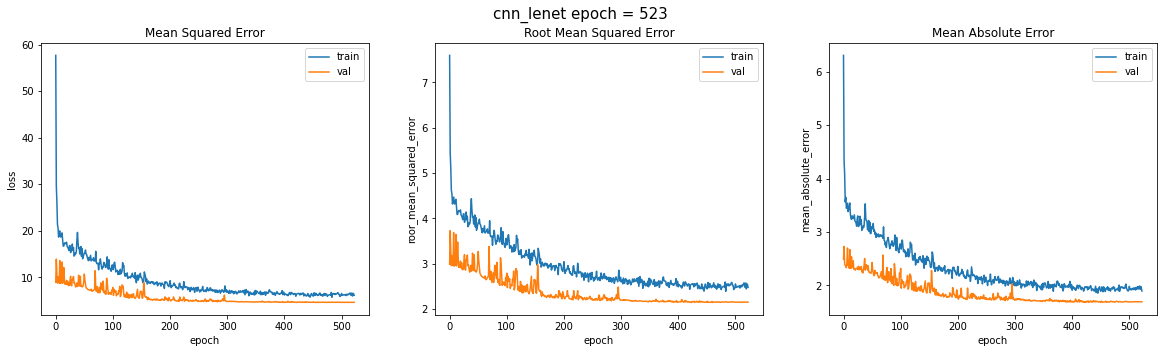

In [37]:
vis_results('cnn_lenet', history_lenet, epochs_lenet)

In [41]:
results = {'cnn_lenet' : eval_lenet[1:]}

### mlp4

In [38]:
eval_mlp4, history_mlp4, epochs_mlp4 = model_history(mlp4, '/tmp/mlp4.h5', 0.001)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 flatten_4 (Flatten)         (None, 7200)              0         
                                                                 
 dropout_8 (Dropout)         (None, 7200)              0         
                                                                 
 dense_13 (Dense)            (None, 500)               3600500   
                                                                 
 dropout_9 (Dropout)         (None, 500)               0         
                                                                 
 dense_14 (Dense)            (None, 500)               250500    
                                                                 
 dropout_10 (Dropout)        (None, 500)               0   

Epoch 15/1000
 7/10 [====================>.........] - ETA: 0s - loss: 13.7654 - mean_squared_error: 13.7654 - rmse: 3.7102 - mean_absolute_error: 2.9442
Epoch 00015: val_loss did not improve from 8.63490
10/10 [==============================] - 0s 21ms/step - loss: 13.5289 - mean_squared_error: 13.5289 - rmse: 3.6782 - mean_absolute_error: 2.9018 - val_loss: 13.2621 - val_mean_squared_error: 13.2621 - val_rmse: 3.6417 - val_mean_absolute_error: 2.6695 - lr: 0.0010
Epoch 16/1000
10/10 [==============================] - ETA: 0s - loss: 12.3628 - mean_squared_error: 12.3628 - rmse: 3.5161 - mean_absolute_error: 2.8429
Epoch 00016: val_loss did not improve from 8.63490
10/10 [==============================] - 0s 21ms/step - loss: 12.3628 - mean_squared_error: 12.3628 - rmse: 3.5161 - mean_absolute_error: 2.8429 - val_loss: 9.5016 - val_mean_squared_error: 9.5016 - val_rmse: 3.0825 - val_mean_absolute_error: 2.3052 - lr: 0.0010
Epoch 17/1000
 7/10 [====================>.........] - ETA: 0s

Epoch 33/1000
 8/10 [=======================>......] - ETA: 0s - loss: 21.3492 - mean_squared_error: 21.3492 - rmse: 4.6205 - mean_absolute_error: 3.7104
Epoch 00033: val_loss did not improve from 8.50235
10/10 [==============================] - 0s 27ms/step - loss: 20.1907 - mean_squared_error: 20.1907 - rmse: 4.4934 - mean_absolute_error: 3.5838 - val_loss: 23.2334 - val_mean_squared_error: 23.2334 - val_rmse: 4.8201 - val_mean_absolute_error: 3.8877 - lr: 0.0010
Epoch 34/1000
 9/10 [==========================>...] - ETA: 0s - loss: 14.1772 - mean_squared_error: 14.1772 - rmse: 3.7653 - mean_absolute_error: 2.9545
Epoch 00034: val_loss did not improve from 8.50235
10/10 [==============================] - 0s 26ms/step - loss: 14.1208 - mean_squared_error: 14.1208 - rmse: 3.7578 - mean_absolute_error: 2.9487 - val_loss: 18.0514 - val_mean_squared_error: 18.0514 - val_rmse: 4.2487 - val_mean_absolute_error: 3.2890 - lr: 0.0010
Epoch 35/1000
 7/10 [====================>.........] - ETA: 

 7/10 [====================>.........] - ETA: 0s - loss: 9.8668 - mean_squared_error: 9.8668 - rmse: 3.1411 - mean_absolute_error: 2.4834  
Epoch 00050: val_loss did not improve from 6.53000
10/10 [==============================] - 0s 21ms/step - loss: 9.8022 - mean_squared_error: 9.8022 - rmse: 3.1309 - mean_absolute_error: 2.4589 - val_loss: 8.4603 - val_mean_squared_error: 8.4603 - val_rmse: 2.9087 - val_mean_absolute_error: 2.1728 - lr: 5.0000e-04
Epoch 51/1000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6148 - mean_squared_error: 9.6148 - rmse: 3.1008 - mean_absolute_error: 2.4505
Epoch 00051: val_loss did not improve from 6.53000
10/10 [==============================] - 0s 22ms/step - loss: 9.2065 - mean_squared_error: 9.2065 - rmse: 3.0342 - mean_absolute_error: 2.4105 - val_loss: 8.1021 - val_mean_squared_error: 8.1021 - val_rmse: 2.8464 - val_mean_absolute_error: 2.1255 - lr: 5.0000e-04
Epoch 52/1000
 7/10 [====================>.........] - ETA: 0s - loss: 9.130

Epoch 68/1000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1087 - mean_squared_error: 9.1087 - rmse: 3.0181 - mean_absolute_error: 2.4103
Epoch 00068: val_loss did not improve from 6.24770
10/10 [==============================] - 0s 22ms/step - loss: 8.9442 - mean_squared_error: 8.9442 - rmse: 2.9907 - mean_absolute_error: 2.3631 - val_loss: 10.9772 - val_mean_squared_error: 10.9772 - val_rmse: 3.3132 - val_mean_absolute_error: 2.5237 - lr: 5.0000e-04
Epoch 69/1000
 7/10 [====================>.........] - ETA: 0s - loss: 8.0421 - mean_squared_error: 8.0421 - rmse: 2.8359 - mean_absolute_error: 2.2175
Epoch 00069: val_loss improved from 6.24770 to 6.18032, saving model to /tmp/mlp4.h5
10/10 [==============================] - 0s 24ms/step - loss: 8.0241 - mean_squared_error: 8.0241 - rmse: 2.8327 - mean_absolute_error: 2.2256 - val_loss: 6.1803 - val_mean_squared_error: 6.1803 - val_rmse: 2.4860 - val_mean_absolute_error: 1.8877 - lr: 5.0000e-04
Epoch 70/1000
 7/10 [=======

 7/10 [====================>.........] - ETA: 0s - loss: 8.0304 - mean_squared_error: 8.0304 - rmse: 2.8338 - mean_absolute_error: 2.2360 
Epoch 00085: val_loss did not improve from 5.74552
10/10 [==============================] - 0s 22ms/step - loss: 7.9572 - mean_squared_error: 7.9572 - rmse: 2.8209 - mean_absolute_error: 2.2209 - val_loss: 11.5939 - val_mean_squared_error: 11.5939 - val_rmse: 3.4050 - val_mean_absolute_error: 2.6296 - lr: 5.0000e-04
Epoch 86/1000
 7/10 [====================>.........] - ETA: 0s - loss: 7.9691 - mean_squared_error: 7.9691 - rmse: 2.8230 - mean_absolute_error: 2.2429
Epoch 00086: val_loss did not improve from 5.74552
10/10 [==============================] - 0s 21ms/step - loss: 7.7733 - mean_squared_error: 7.7733 - rmse: 2.7881 - mean_absolute_error: 2.2051 - val_loss: 5.7744 - val_mean_squared_error: 5.7744 - val_rmse: 2.4030 - val_mean_absolute_error: 1.9461 - lr: 5.0000e-04
Epoch 87/1000
10/10 [==============================] - ETA: 0s - loss: 10.6

Epoch 103/1000
10/10 [==============================] - ETA: 0s - loss: 7.2737 - mean_squared_error: 7.2737 - rmse: 2.6970 - mean_absolute_error: 2.1399
Epoch 00103: val_loss improved from 5.71946 to 5.64988, saving model to /tmp/mlp4.h5
10/10 [==============================] - 0s 27ms/step - loss: 7.2737 - mean_squared_error: 7.2737 - rmse: 2.6970 - mean_absolute_error: 2.1399 - val_loss: 5.6499 - val_mean_squared_error: 5.6499 - val_rmse: 2.3769 - val_mean_absolute_error: 1.8202 - lr: 5.0000e-04
Epoch 104/1000
 7/10 [====================>.........] - ETA: 0s - loss: 7.2243 - mean_squared_error: 7.2243 - rmse: 2.6878 - mean_absolute_error: 2.1219
Epoch 00104: val_loss did not improve from 5.64988
10/10 [==============================] - 0s 22ms/step - loss: 7.4003 - mean_squared_error: 7.4003 - rmse: 2.7203 - mean_absolute_error: 2.1426 - val_loss: 11.2493 - val_mean_squared_error: 11.2493 - val_rmse: 3.3540 - val_mean_absolute_error: 2.6047 - lr: 5.0000e-04
Epoch 105/1000
 7/10 [====

 7/10 [====================>.........] - ETA: 0s - loss: 6.8832 - mean_squared_error: 6.8832 - rmse: 2.6236 - mean_absolute_error: 2.0629
Epoch 00120: val_loss did not improve from 5.30957
10/10 [==============================] - 0s 22ms/step - loss: 6.7096 - mean_squared_error: 6.7096 - rmse: 2.5903 - mean_absolute_error: 2.0436 - val_loss: 12.3280 - val_mean_squared_error: 12.3280 - val_rmse: 3.5111 - val_mean_absolute_error: 2.7716 - lr: 5.0000e-04
Epoch 121/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.8992 - mean_squared_error: 6.8992 - rmse: 2.6266 - mean_absolute_error: 2.0314
Epoch 00121: val_loss did not improve from 5.30957
10/10 [==============================] - 0s 26ms/step - loss: 6.9100 - mean_squared_error: 6.9100 - rmse: 2.6287 - mean_absolute_error: 2.0343 - val_loss: 10.2857 - val_mean_squared_error: 10.2857 - val_rmse: 3.2071 - val_mean_absolute_error: 2.5020 - lr: 5.0000e-04
Epoch 122/1000
 7/10 [====================>.........] - ETA: 0s - loss: 7

 7/10 [====================>.........] - ETA: 0s - loss: 6.7098 - mean_squared_error: 6.7098 - rmse: 2.5903 - mean_absolute_error: 2.0077
Epoch 00137: val_loss did not improve from 5.30957
10/10 [==============================] - 0s 24ms/step - loss: 6.6123 - mean_squared_error: 6.6123 - rmse: 2.5714 - mean_absolute_error: 2.0118 - val_loss: 6.3660 - val_mean_squared_error: 6.3660 - val_rmse: 2.5231 - val_mean_absolute_error: 1.8958 - lr: 2.5000e-04
Epoch 138/1000
10/10 [==============================] - ETA: 0s - loss: 6.5489 - mean_squared_error: 6.5489 - rmse: 2.5591 - mean_absolute_error: 1.9978
Epoch 00138: val_loss did not improve from 5.30957
10/10 [==============================] - 0s 25ms/step - loss: 6.5489 - mean_squared_error: 6.5489 - rmse: 2.5591 - mean_absolute_error: 1.9978 - val_loss: 8.0189 - val_mean_squared_error: 8.0189 - val_rmse: 2.8318 - val_mean_absolute_error: 2.1494 - lr: 2.5000e-04
Epoch 139/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.206

Epoch 155/1000
10/10 [==============================] - ETA: 0s - loss: 6.0776 - mean_squared_error: 6.0776 - rmse: 2.4653 - mean_absolute_error: 1.9171
Epoch 00155: val_loss did not improve from 5.30957
10/10 [==============================] - 0s 26ms/step - loss: 6.0776 - mean_squared_error: 6.0776 - rmse: 2.4653 - mean_absolute_error: 1.9171 - val_loss: 5.8864 - val_mean_squared_error: 5.8864 - val_rmse: 2.4262 - val_mean_absolute_error: 1.8280 - lr: 1.2500e-04
Epoch 156/1000
 8/10 [=======================>......] - ETA: 0s - loss: 6.4595 - mean_squared_error: 6.4595 - rmse: 2.5416 - mean_absolute_error: 2.0147
Epoch 00156: val_loss did not improve from 5.30957
10/10 [==============================] - 0s 30ms/step - loss: 6.7333 - mean_squared_error: 6.7333 - rmse: 2.5949 - mean_absolute_error: 2.0395 - val_loss: 10.1882 - val_mean_squared_error: 10.1882 - val_rmse: 3.1919 - val_mean_absolute_error: 2.5072 - lr: 1.2500e-04
Epoch 157/1000
 7/10 [====================>.........] - ETA:

 7/10 [====================>.........] - ETA: 0s - loss: 5.9629 - mean_squared_error: 5.9629 - rmse: 2.4419 - mean_absolute_error: 1.9191
Epoch 00172: val_loss did not improve from 5.30957
10/10 [==============================] - 0s 23ms/step - loss: 5.8534 - mean_squared_error: 5.8534 - rmse: 2.4194 - mean_absolute_error: 1.8938 - val_loss: 8.2086 - val_mean_squared_error: 8.2086 - val_rmse: 2.8651 - val_mean_absolute_error: 2.2060 - lr: 6.2500e-05
Epoch 173/1000
 7/10 [====================>.........] - ETA: 0s - loss: 5.8765 - mean_squared_error: 5.8765 - rmse: 2.4241 - mean_absolute_error: 1.8885
Epoch 00173: val_loss did not improve from 5.30957
10/10 [==============================] - 0s 22ms/step - loss: 5.8781 - mean_squared_error: 5.8781 - rmse: 2.4245 - mean_absolute_error: 1.8974 - val_loss: 9.2490 - val_mean_squared_error: 9.2490 - val_rmse: 3.0412 - val_mean_absolute_error: 2.3787 - lr: 6.2500e-05
Epoch 174/1000
 7/10 [====================>.........] - ETA: 0s - loss: 5.629

Epoch 190/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1056 - mean_squared_error: 6.1056 - rmse: 2.4709 - mean_absolute_error: 1.9440
Epoch 00190: val_loss did not improve from 5.30957
10/10 [==============================] - 0s 24ms/step - loss: 6.0942 - mean_squared_error: 6.0942 - rmse: 2.4686 - mean_absolute_error: 1.9435 - val_loss: 7.7445 - val_mean_squared_error: 7.7445 - val_rmse: 2.7829 - val_mean_absolute_error: 2.1336 - lr: 3.1250e-05
Epoch 191/1000
 7/10 [====================>.........] - ETA: 0s - loss: 5.7032 - mean_squared_error: 5.7032 - rmse: 2.3881 - mean_absolute_error: 1.8736
Epoch 00191: val_loss did not improve from 5.30957
10/10 [==============================] - 0s 22ms/step - loss: 5.8241 - mean_squared_error: 5.8241 - rmse: 2.4133 - mean_absolute_error: 1.8933 - val_loss: 8.4682 - val_mean_squared_error: 8.4682 - val_rmse: 2.9100 - val_mean_absolute_error: 2.2552 - lr: 3.1250e-05
Epoch 192/1000
 8/10 [=======================>......] - ETA: 0

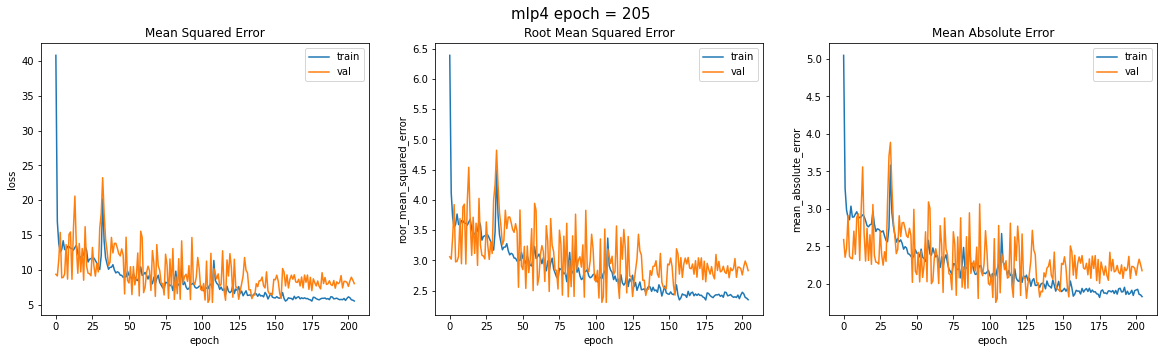

In [39]:
vis_results('mlp4', history_mlp4, eval_mlp4, epochs_mlp4)

In [42]:
results.update({'mlp4': eval_mlp4[1:]})

### cnn_vgg

In [44]:
eval_vgg, history_vgg, epochs_vgg = model_history(cnn_vgg, '/tmp/vgg.h5', 0.001)

pooling layers: 4
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 conv1d_27 (Conv1D)          (None, 100, 64)           13888     
                                                                 
 conv1d_28 (Conv1D)          (None, 100, 64)           12352     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 50, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 50, 128)           24704     
                                                                 
 conv1d_30 (Conv1D)          (None, 50, 128)           49280     
                                         

Epoch 11/1000
10/10 [==============================] - ETA: 0s - loss: 10.4260 - mean_squared_error: 10.4260 - rmse: 3.2289 - mean_absolute_error: 2.5934
Epoch 00011: val_loss did not improve from 8.34050
10/10 [==============================] - 5s 482ms/step - loss: 10.4260 - mean_squared_error: 10.4260 - rmse: 3.2289 - mean_absolute_error: 2.5934 - val_loss: 8.7598 - val_mean_squared_error: 8.7598 - val_rmse: 2.9597 - val_mean_absolute_error: 2.5305 - lr: 0.0010
Epoch 12/1000
10/10 [==============================] - ETA: 0s - loss: 11.2104 - mean_squared_error: 11.2104 - rmse: 3.3482 - mean_absolute_error: 2.6757
Epoch 00012: val_loss did not improve from 8.34050
10/10 [==============================] - 5s 478ms/step - loss: 11.2104 - mean_squared_error: 11.2104 - rmse: 3.3482 - mean_absolute_error: 2.6757 - val_loss: 8.4161 - val_mean_squared_error: 8.4161 - val_rmse: 2.9011 - val_mean_absolute_error: 2.1760 - lr: 0.0010
Epoch 13/1000
10/10 [==============================] - ETA: 0s

10/10 [==============================] - ETA: 0s - loss: 7.6237 - mean_squared_error: 7.6237 - rmse: 2.7611 - mean_absolute_error: 2.2120
Epoch 00028: val_loss did not improve from 5.18653
10/10 [==============================] - 4s 442ms/step - loss: 7.6237 - mean_squared_error: 7.6237 - rmse: 2.7611 - mean_absolute_error: 2.2120 - val_loss: 6.1882 - val_mean_squared_error: 6.1882 - val_rmse: 2.4876 - val_mean_absolute_error: 2.0428 - lr: 0.0010
Epoch 29/1000
10/10 [==============================] - ETA: 0s - loss: 6.6096 - mean_squared_error: 6.6096 - rmse: 2.5709 - mean_absolute_error: 2.0520
Epoch 00029: val_loss improved from 5.18653 to 5.12136, saving model to /tmp/vgg.h5
10/10 [==============================] - 5s 469ms/step - loss: 6.6096 - mean_squared_error: 6.6096 - rmse: 2.5709 - mean_absolute_error: 2.0520 - val_loss: 5.1214 - val_mean_squared_error: 5.1214 - val_rmse: 2.2630 - val_mean_absolute_error: 1.7566 - lr: 0.0010
Epoch 30/1000
10/10 [==============================

Epoch 46/1000
10/10 [==============================] - ETA: 0s - loss: 4.6568 - mean_squared_error: 4.6568 - rmse: 2.1580 - mean_absolute_error: 1.6834
Epoch 00046: val_loss did not improve from 4.64270
10/10 [==============================] - 5s 449ms/step - loss: 4.6568 - mean_squared_error: 4.6568 - rmse: 2.1580 - mean_absolute_error: 1.6834 - val_loss: 5.1455 - val_mean_squared_error: 5.1455 - val_rmse: 2.2684 - val_mean_absolute_error: 1.7857 - lr: 0.0010
Epoch 47/1000
10/10 [==============================] - ETA: 0s - loss: 4.2319 - mean_squared_error: 4.2319 - rmse: 2.0572 - mean_absolute_error: 1.6054
Epoch 00047: val_loss did not improve from 4.64270
10/10 [==============================] - 5s 452ms/step - loss: 4.2319 - mean_squared_error: 4.2319 - rmse: 2.0572 - mean_absolute_error: 1.6054 - val_loss: 4.6980 - val_mean_squared_error: 4.6980 - val_rmse: 2.1675 - val_mean_absolute_error: 1.6670 - lr: 0.0010
Epoch 48/1000
10/10 [==============================] - ETA: 0s - loss:

10/10 [==============================] - 5s 466ms/step - loss: 4.0405 - mean_squared_error: 4.0405 - rmse: 2.0101 - mean_absolute_error: 1.5760 - val_loss: 4.2432 - val_mean_squared_error: 4.2432 - val_rmse: 2.0599 - val_mean_absolute_error: 1.6111 - lr: 0.0010
Epoch 64/1000
10/10 [==============================] - ETA: 0s - loss: 3.7389 - mean_squared_error: 3.7389 - rmse: 1.9336 - mean_absolute_error: 1.5355
Epoch 00064: val_loss did not improve from 4.24321
10/10 [==============================] - 4s 444ms/step - loss: 3.7389 - mean_squared_error: 3.7389 - rmse: 1.9336 - mean_absolute_error: 1.5355 - val_loss: 4.3677 - val_mean_squared_error: 4.3677 - val_rmse: 2.0899 - val_mean_absolute_error: 1.6213 - lr: 0.0010
Epoch 65/1000
10/10 [==============================] - ETA: 0s - loss: 3.4054 - mean_squared_error: 3.4054 - rmse: 1.8454 - mean_absolute_error: 1.4383
Epoch 00065: val_loss improved from 4.24321 to 4.11360, saving model to /tmp/vgg.h5
10/10 [==============================

Epoch 81/1000
10/10 [==============================] - ETA: 0s - loss: 3.0049 - mean_squared_error: 3.0049 - rmse: 1.7335 - mean_absolute_error: 1.3521
Epoch 00081: val_loss improved from 4.11360 to 3.90207, saving model to /tmp/vgg.h5
10/10 [==============================] - 5s 464ms/step - loss: 3.0049 - mean_squared_error: 3.0049 - rmse: 1.7335 - mean_absolute_error: 1.3521 - val_loss: 3.9021 - val_mean_squared_error: 3.9021 - val_rmse: 1.9754 - val_mean_absolute_error: 1.5535 - lr: 0.0010
Epoch 82/1000
10/10 [==============================] - ETA: 0s - loss: 2.6503 - mean_squared_error: 2.6503 - rmse: 1.6280 - mean_absolute_error: 1.2694
Epoch 00082: val_loss did not improve from 3.90207
10/10 [==============================] - 5s 451ms/step - loss: 2.6503 - mean_squared_error: 2.6503 - rmse: 1.6280 - mean_absolute_error: 1.2694 - val_loss: 4.1365 - val_mean_squared_error: 4.1365 - val_rmse: 2.0338 - val_mean_absolute_error: 1.5984 - lr: 0.0010
Epoch 83/1000
10/10 [================

Epoch 99/1000
10/10 [==============================] - ETA: 0s - loss: 2.1661 - mean_squared_error: 2.1661 - rmse: 1.4718 - mean_absolute_error: 1.1490
Epoch 00099: val_loss did not improve from 3.90207
10/10 [==============================] - 5s 452ms/step - loss: 2.1661 - mean_squared_error: 2.1661 - rmse: 1.4718 - mean_absolute_error: 1.1490 - val_loss: 4.5251 - val_mean_squared_error: 4.5251 - val_rmse: 2.1272 - val_mean_absolute_error: 1.6595 - lr: 0.0010
Epoch 100/1000
10/10 [==============================] - ETA: 0s - loss: 2.1186 - mean_squared_error: 2.1186 - rmse: 1.4555 - mean_absolute_error: 1.1103
Epoch 00100: val_loss did not improve from 3.90207
10/10 [==============================] - 5s 455ms/step - loss: 2.1186 - mean_squared_error: 2.1186 - rmse: 1.4555 - mean_absolute_error: 1.1103 - val_loss: 5.0807 - val_mean_squared_error: 5.0807 - val_rmse: 2.2540 - val_mean_absolute_error: 1.8221 - lr: 0.0010
Epoch 101/1000
10/10 [==============================] - ETA: 0s - los

10/10 [==============================] - ETA: 0s - loss: 1.4761 - mean_squared_error: 1.4761 - rmse: 1.2150 - mean_absolute_error: 0.9246
Epoch 00116: val_loss did not improve from 3.90207
10/10 [==============================] - 5s 456ms/step - loss: 1.4761 - mean_squared_error: 1.4761 - rmse: 1.2150 - mean_absolute_error: 0.9246 - val_loss: 4.5135 - val_mean_squared_error: 4.5135 - val_rmse: 2.1245 - val_mean_absolute_error: 1.6683 - lr: 5.0000e-04
Epoch 117/1000
10/10 [==============================] - ETA: 0s - loss: 1.3857 - mean_squared_error: 1.3857 - rmse: 1.1772 - mean_absolute_error: 0.9030
Epoch 00117: val_loss did not improve from 3.90207
10/10 [==============================] - 5s 452ms/step - loss: 1.3857 - mean_squared_error: 1.3857 - rmse: 1.1772 - mean_absolute_error: 0.9030 - val_loss: 4.2088 - val_mean_squared_error: 4.2088 - val_rmse: 2.0515 - val_mean_absolute_error: 1.5786 - lr: 5.0000e-04
Epoch 118/1000
10/10 [==============================] - ETA: 0s - loss: 1.2

10/10 [==============================] - ETA: 0s - loss: 0.9779 - mean_squared_error: 0.9779 - rmse: 0.9889 - mean_absolute_error: 0.7681
Epoch 00133: val_loss did not improve from 3.90207
10/10 [==============================] - 4s 446ms/step - loss: 0.9779 - mean_squared_error: 0.9779 - rmse: 0.9889 - mean_absolute_error: 0.7681 - val_loss: 4.3164 - val_mean_squared_error: 4.3164 - val_rmse: 2.0776 - val_mean_absolute_error: 1.6124 - lr: 2.5000e-04
Epoch 134/1000
10/10 [==============================] - ETA: 0s - loss: 0.8830 - mean_squared_error: 0.8830 - rmse: 0.9397 - mean_absolute_error: 0.7260
Epoch 00134: val_loss did not improve from 3.90207
10/10 [==============================] - 5s 457ms/step - loss: 0.8830 - mean_squared_error: 0.8830 - rmse: 0.9397 - mean_absolute_error: 0.7260 - val_loss: 4.3719 - val_mean_squared_error: 4.3719 - val_rmse: 2.0909 - val_mean_absolute_error: 1.6208 - lr: 2.5000e-04
Epoch 135/1000
10/10 [==============================] - ETA: 0s - loss: 0.9

10/10 [==============================] - ETA: 0s - loss: 0.6894 - mean_squared_error: 0.6894 - rmse: 0.8303 - mean_absolute_error: 0.6375
Epoch 00150: val_loss did not improve from 3.90207
10/10 [==============================] - 4s 443ms/step - loss: 0.6894 - mean_squared_error: 0.6894 - rmse: 0.8303 - mean_absolute_error: 0.6375 - val_loss: 4.4115 - val_mean_squared_error: 4.4115 - val_rmse: 2.1003 - val_mean_absolute_error: 1.6479 - lr: 1.2500e-04
Epoch 151/1000
10/10 [==============================] - ETA: 0s - loss: 0.7695 - mean_squared_error: 0.7695 - rmse: 0.8772 - mean_absolute_error: 0.6663
Epoch 00151: val_loss did not improve from 3.90207
10/10 [==============================] - 4s 433ms/step - loss: 0.7695 - mean_squared_error: 0.7695 - rmse: 0.8772 - mean_absolute_error: 0.6663 - val_loss: 4.4988 - val_mean_squared_error: 4.4988 - val_rmse: 2.1210 - val_mean_absolute_error: 1.6537 - lr: 1.2500e-04
Epoch 152/1000
10/10 [==============================] - ETA: 0s - loss: 0.7

10/10 [==============================] - ETA: 0s - loss: 0.6263 - mean_squared_error: 0.6263 - rmse: 0.7914 - mean_absolute_error: 0.6072
Epoch 00167: val_loss did not improve from 3.90207
10/10 [==============================] - 5s 450ms/step - loss: 0.6263 - mean_squared_error: 0.6263 - rmse: 0.7914 - mean_absolute_error: 0.6072 - val_loss: 4.3953 - val_mean_squared_error: 4.3953 - val_rmse: 2.0965 - val_mean_absolute_error: 1.6125 - lr: 6.2500e-05
Epoch 168/1000
10/10 [==============================] - ETA: 0s - loss: 0.6313 - mean_squared_error: 0.6313 - rmse: 0.7945 - mean_absolute_error: 0.6048
Epoch 00168: val_loss did not improve from 3.90207
10/10 [==============================] - 5s 469ms/step - loss: 0.6313 - mean_squared_error: 0.6313 - rmse: 0.7945 - mean_absolute_error: 0.6048 - val_loss: 4.5092 - val_mean_squared_error: 4.5092 - val_rmse: 2.1235 - val_mean_absolute_error: 1.6468 - lr: 6.2500e-05
Epoch 169/1000
10/10 [==============================] - ETA: 0s - loss: 0.6

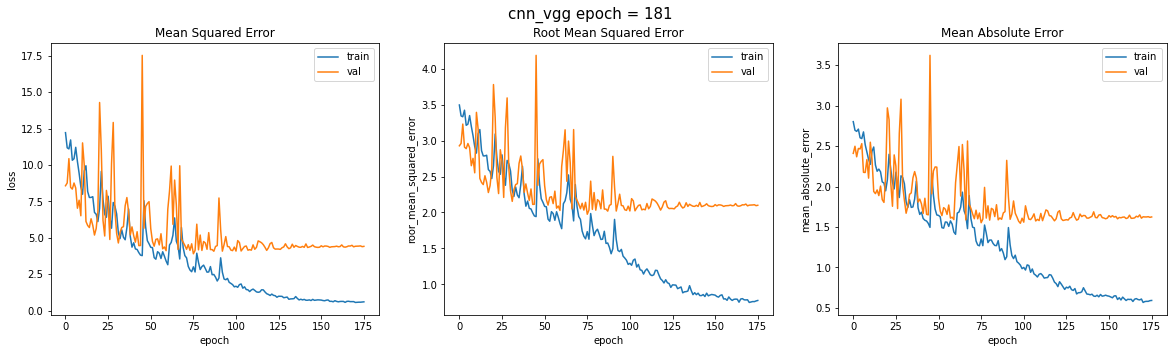

In [49]:
vis_results('cnn_vgg', history_vgg, epochs_vgg)

In [47]:
results.update({'cnn_vgg': eval_vgg[1:]})

### lstm1v0

In [50]:
eval_lstm1v0, history_lstm1v0, epochs_lstm1v0 = model_history(lstm1v0, '/tmp/lstm1v0.h5', 0.01)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 lstm (LSTM)                 (None, 100)               69200     
                                                                 
 dense_20 (Dense)            (None, 1)                 101       
                                                                 
Total params: 69,301
Trainable params: 69,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
 9/10 [==========================>...] - ETA: 0s - loss: 33.6744 - mean_squared_error: 33.6744 - rmse: 5.8030 - mean_absolute_error: 4.5639
Epoch 00001: val_loss improved from inf to 14.73136, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 3s 146ms/step - loss: 33.4769 - mean_squ

 9/10 [==========================>...] - ETA: 0s - loss: 13.2267 - mean_squared_error: 13.2267 - rmse: 3.6369 - mean_absolute_error: 2.9188
Epoch 00016: val_loss did not improve from 10.95633
10/10 [==============================] - 1s 105ms/step - loss: 13.2395 - mean_squared_error: 13.2395 - rmse: 3.6386 - mean_absolute_error: 2.9226 - val_loss: 11.1919 - val_mean_squared_error: 11.1919 - val_rmse: 3.3454 - val_mean_absolute_error: 2.7855 - lr: 0.0100
Epoch 17/1000
 9/10 [==========================>...] - ETA: 0s - loss: 13.0723 - mean_squared_error: 13.0723 - rmse: 3.6156 - mean_absolute_error: 2.9875
Epoch 00017: val_loss did not improve from 10.95633
10/10 [==============================] - 1s 103ms/step - loss: 13.0604 - mean_squared_error: 13.0604 - rmse: 3.6139 - mean_absolute_error: 2.9835 - val_loss: 11.0436 - val_mean_squared_error: 11.0436 - val_rmse: 3.3232 - val_mean_absolute_error: 2.7338 - lr: 0.0100
Epoch 18/1000
 9/10 [==========================>...] - ETA: 0s - loss:

 9/10 [==========================>...] - ETA: 0s - loss: 12.3711 - mean_squared_error: 12.3711 - rmse: 3.5173 - mean_absolute_error: 2.8627
Epoch 00033: val_loss improved from 10.54936 to 10.34539, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 1s 101ms/step - loss: 12.3190 - mean_squared_error: 12.3190 - rmse: 3.5098 - mean_absolute_error: 2.8560 - val_loss: 10.3454 - val_mean_squared_error: 10.3454 - val_rmse: 3.2164 - val_mean_absolute_error: 2.6794 - lr: 0.0100
Epoch 34/1000
 9/10 [==========================>...] - ETA: 0s - loss: 12.0645 - mean_squared_error: 12.0645 - rmse: 3.4734 - mean_absolute_error: 2.8354
Epoch 00034: val_loss improved from 10.34539 to 9.89472, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 1s 102ms/step - loss: 12.0366 - mean_squared_error: 12.0366 - rmse: 3.4694 - mean_absolute_error: 2.8337 - val_loss: 9.8947 - val_mean_squared_error: 9.8947 - val_rmse: 3.1456 - val_mean_absolute_error: 2.5232 - lr: 0.01

Epoch 50/1000
 9/10 [==========================>...] - ETA: 0s - loss: 9.5645 - mean_squared_error: 9.5645 - rmse: 3.0927 - mean_absolute_error: 2.4831
Epoch 00050: val_loss did not improve from 8.39131
10/10 [==============================] - 1s 102ms/step - loss: 9.5459 - mean_squared_error: 9.5459 - rmse: 3.0896 - mean_absolute_error: 2.4828 - val_loss: 9.4093 - val_mean_squared_error: 9.4093 - val_rmse: 3.0675 - val_mean_absolute_error: 2.5917 - lr: 0.0100
Epoch 51/1000
 9/10 [==========================>...] - ETA: 0s - loss: 9.3835 - mean_squared_error: 9.3835 - rmse: 3.0632 - mean_absolute_error: 2.4622
Epoch 00051: val_loss improved from 8.39131 to 7.79745, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 1s 103ms/step - loss: 9.3590 - mean_squared_error: 9.3590 - rmse: 3.0593 - mean_absolute_error: 2.4591 - val_loss: 7.7974 - val_mean_squared_error: 7.7974 - val_rmse: 2.7924 - val_mean_absolute_error: 2.3091 - lr: 0.0100
Epoch 52/1000
 9/10 [============

 9/10 [==========================>...] - ETA: 0s - loss: 8.6241 - mean_squared_error: 8.6241 - rmse: 2.9367 - mean_absolute_error: 2.3151
Epoch 00067: val_loss improved from 6.64562 to 6.59050, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 1s 108ms/step - loss: 8.6392 - mean_squared_error: 8.6392 - rmse: 2.9393 - mean_absolute_error: 2.3182 - val_loss: 6.5905 - val_mean_squared_error: 6.5905 - val_rmse: 2.5672 - val_mean_absolute_error: 2.0408 - lr: 0.0100
Epoch 68/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.6119 - mean_squared_error: 7.6119 - rmse: 2.7590 - mean_absolute_error: 2.1751
Epoch 00068: val_loss did not improve from 6.59050
10/10 [==============================] - 1s 104ms/step - loss: 7.6102 - mean_squared_error: 7.6102 - rmse: 2.7587 - mean_absolute_error: 2.1760 - val_loss: 8.1278 - val_mean_squared_error: 8.1278 - val_rmse: 2.8509 - val_mean_absolute_error: 2.3428 - lr: 0.0100
Epoch 69/1000
 9/10 [==========================

 9/10 [==========================>...] - ETA: 0s - loss: 9.1710 - mean_squared_error: 9.1710 - rmse: 3.0284 - mean_absolute_error: 2.3759
Epoch 00084: val_loss did not improve from 6.25886
10/10 [==============================] - 1s 106ms/step - loss: 9.1369 - mean_squared_error: 9.1369 - rmse: 3.0227 - mean_absolute_error: 2.3729 - val_loss: 6.2665 - val_mean_squared_error: 6.2665 - val_rmse: 2.5033 - val_mean_absolute_error: 1.9925 - lr: 0.0100
Epoch 85/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.8347 - mean_squared_error: 7.8347 - rmse: 2.7991 - mean_absolute_error: 2.2106
Epoch 00085: val_loss improved from 6.25886 to 6.23845, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 1s 105ms/step - loss: 7.8712 - mean_squared_error: 7.8712 - rmse: 2.8056 - mean_absolute_error: 2.2155 - val_loss: 6.2385 - val_mean_squared_error: 6.2385 - val_rmse: 2.4977 - val_mean_absolute_error: 1.9429 - lr: 0.0100
Epoch 86/1000
 9/10 [==========================

Epoch 102/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.1127 - mean_squared_error: 7.1127 - rmse: 2.6670 - mean_absolute_error: 2.0873
Epoch 00102: val_loss did not improve from 5.83417
10/10 [==============================] - 1s 106ms/step - loss: 7.1015 - mean_squared_error: 7.1015 - rmse: 2.6649 - mean_absolute_error: 2.0866 - val_loss: 10.6950 - val_mean_squared_error: 10.6950 - val_rmse: 3.2703 - val_mean_absolute_error: 2.7565 - lr: 0.0100
Epoch 103/1000
 9/10 [==========================>...] - ETA: 0s - loss: 8.1486 - mean_squared_error: 8.1486 - rmse: 2.8546 - mean_absolute_error: 2.2683
Epoch 00103: val_loss improved from 5.83417 to 5.75722, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 1s 103ms/step - loss: 8.1387 - mean_squared_error: 8.1387 - rmse: 2.8528 - mean_absolute_error: 2.2678 - val_loss: 5.7572 - val_mean_squared_error: 5.7572 - val_rmse: 2.3994 - val_mean_absolute_error: 1.8956 - lr: 0.0100
Epoch 104/1000
 9/10 [=======

 9/10 [==========================>...] - ETA: 0s - loss: 6.5489 - mean_squared_error: 6.5489 - rmse: 2.5591 - mean_absolute_error: 1.9939
Epoch 00119: val_loss did not improve from 5.56770
10/10 [==============================] - 1s 104ms/step - loss: 6.5215 - mean_squared_error: 6.5215 - rmse: 2.5537 - mean_absolute_error: 1.9891 - val_loss: 6.0226 - val_mean_squared_error: 6.0226 - val_rmse: 2.4541 - val_mean_absolute_error: 1.9597 - lr: 0.0100
Epoch 120/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.4614 - mean_squared_error: 6.4614 - rmse: 2.5419 - mean_absolute_error: 1.9776
Epoch 00120: val_loss did not improve from 5.56770
10/10 [==============================] - 1s 115ms/step - loss: 6.4565 - mean_squared_error: 6.4565 - rmse: 2.5410 - mean_absolute_error: 1.9786 - val_loss: 8.7883 - val_mean_squared_error: 8.7883 - val_rmse: 2.9645 - val_mean_absolute_error: 2.4351 - lr: 0.0100
Epoch 121/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.7569 - me

Epoch 137/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.4655 - mean_squared_error: 6.4655 - rmse: 2.5427 - mean_absolute_error: 1.9829
Epoch 00137: val_loss did not improve from 5.46334
10/10 [==============================] - 1s 104ms/step - loss: 6.4468 - mean_squared_error: 6.4468 - rmse: 2.5390 - mean_absolute_error: 1.9799 - val_loss: 6.2195 - val_mean_squared_error: 6.2195 - val_rmse: 2.4939 - val_mean_absolute_error: 1.9253 - lr: 0.0100
Epoch 138/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.0505 - mean_squared_error: 7.0505 - rmse: 2.6553 - mean_absolute_error: 2.0938
Epoch 00138: val_loss did not improve from 5.46334
10/10 [==============================] - 1s 110ms/step - loss: 7.0501 - mean_squared_error: 7.0501 - rmse: 2.6552 - mean_absolute_error: 2.0940 - val_loss: 8.4757 - val_mean_squared_error: 8.4757 - val_rmse: 2.9113 - val_mean_absolute_error: 2.3933 - lr: 0.0100
Epoch 139/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 155/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.2724 - mean_squared_error: 6.2724 - rmse: 2.5045 - mean_absolute_error: 1.9578
Epoch 00155: val_loss improved from 5.27274 to 5.26375, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 1s 109ms/step - loss: 6.2575 - mean_squared_error: 6.2575 - rmse: 2.5015 - mean_absolute_error: 1.9563 - val_loss: 5.2637 - val_mean_squared_error: 5.2637 - val_rmse: 2.2943 - val_mean_absolute_error: 1.8049 - lr: 0.0100
Epoch 156/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1775 - mean_squared_error: 6.1775 - rmse: 2.4855 - mean_absolute_error: 1.9462
Epoch 00156: val_loss did not improve from 5.26375
10/10 [==============================] - 1s 108ms/step - loss: 6.1485 - mean_squared_error: 6.1485 - rmse: 2.4796 - mean_absolute_error: 1.9404 - val_loss: 7.3612 - val_mean_squared_error: 7.3612 - val_rmse: 2.7132 - val_mean_absolute_error: 2.2050 - lr: 0.0100
Epoch 157/1000
 9/10 [=========

Epoch 173/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.0848 - mean_squared_error: 6.0848 - rmse: 2.4667 - mean_absolute_error: 1.9382
Epoch 00173: val_loss did not improve from 5.22023
10/10 [==============================] - 1s 107ms/step - loss: 6.0556 - mean_squared_error: 6.0556 - rmse: 2.4608 - mean_absolute_error: 1.9328 - val_loss: 5.8386 - val_mean_squared_error: 5.8386 - val_rmse: 2.4163 - val_mean_absolute_error: 1.9289 - lr: 0.0100
Epoch 174/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1504 - mean_squared_error: 6.1504 - rmse: 2.4800 - mean_absolute_error: 1.9376
Epoch 00174: val_loss did not improve from 5.22023
10/10 [==============================] - 1s 115ms/step - loss: 6.1330 - mean_squared_error: 6.1330 - rmse: 2.4765 - mean_absolute_error: 1.9356 - val_loss: 6.0293 - val_mean_squared_error: 6.0293 - val_rmse: 2.4555 - val_mean_absolute_error: 1.9700 - lr: 0.0100
Epoch 175/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 191/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.2733 - mean_squared_error: 6.2733 - rmse: 2.5047 - mean_absolute_error: 1.9252
Epoch 00191: val_loss did not improve from 5.10753
10/10 [==============================] - 1s 105ms/step - loss: 6.2924 - mean_squared_error: 6.2924 - rmse: 2.5085 - mean_absolute_error: 1.9262 - val_loss: 5.5022 - val_mean_squared_error: 5.5022 - val_rmse: 2.3457 - val_mean_absolute_error: 1.8569 - lr: 0.0100
Epoch 192/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.5765 - mean_squared_error: 6.5765 - rmse: 2.5645 - mean_absolute_error: 1.9859
Epoch 00192: val_loss did not improve from 5.10753
10/10 [==============================] - 1s 108ms/step - loss: 6.5912 - mean_squared_error: 6.5912 - rmse: 2.5673 - mean_absolute_error: 1.9891 - val_loss: 5.2579 - val_mean_squared_error: 5.2579 - val_rmse: 2.2930 - val_mean_absolute_error: 1.7778 - lr: 0.0100
Epoch 193/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 209/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.7981 - mean_squared_error: 6.7981 - rmse: 2.6073 - mean_absolute_error: 2.0421
Epoch 00209: val_loss did not improve from 4.91464
10/10 [==============================] - 1s 106ms/step - loss: 6.8322 - mean_squared_error: 6.8322 - rmse: 2.6139 - mean_absolute_error: 2.0491 - val_loss: 5.2959 - val_mean_squared_error: 5.2959 - val_rmse: 2.3013 - val_mean_absolute_error: 1.7816 - lr: 0.0100
Epoch 210/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.4044 - mean_squared_error: 6.4044 - rmse: 2.5307 - mean_absolute_error: 1.9700
Epoch 00210: val_loss did not improve from 4.91464
10/10 [==============================] - 1s 107ms/step - loss: 6.3894 - mean_squared_error: 6.3894 - rmse: 2.5277 - mean_absolute_error: 1.9684 - val_loss: 6.8310 - val_mean_squared_error: 6.8310 - val_rmse: 2.6136 - val_mean_absolute_error: 2.1525 - lr: 0.0100
Epoch 211/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 227/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.8648 - mean_squared_error: 5.8648 - rmse: 2.4217 - mean_absolute_error: 1.8908
Epoch 00227: val_loss did not improve from 4.75439
10/10 [==============================] - 1s 111ms/step - loss: 5.8481 - mean_squared_error: 5.8481 - rmse: 2.4183 - mean_absolute_error: 1.8891 - val_loss: 4.9315 - val_mean_squared_error: 4.9315 - val_rmse: 2.2207 - val_mean_absolute_error: 1.7531 - lr: 0.0100
Epoch 228/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.9276 - mean_squared_error: 5.9276 - rmse: 2.4347 - mean_absolute_error: 1.8917
Epoch 00228: val_loss did not improve from 4.75439
10/10 [==============================] - 1s 111ms/step - loss: 5.9011 - mean_squared_error: 5.9011 - rmse: 2.4292 - mean_absolute_error: 1.8876 - val_loss: 6.0022 - val_mean_squared_error: 6.0022 - val_rmse: 2.4499 - val_mean_absolute_error: 2.0157 - lr: 0.0100
Epoch 229/1000
 9/10 [==========================>...] - ETA: 0s - lo

 9/10 [==========================>...] - ETA: 0s - loss: 5.6716 - mean_squared_error: 5.6716 - rmse: 2.3815 - mean_absolute_error: 1.8326
Epoch 00244: val_loss did not improve from 4.54432
10/10 [==============================] - 1s 109ms/step - loss: 5.6529 - mean_squared_error: 5.6529 - rmse: 2.3776 - mean_absolute_error: 1.8304 - val_loss: 4.9511 - val_mean_squared_error: 4.9511 - val_rmse: 2.2251 - val_mean_absolute_error: 1.7616 - lr: 0.0100
Epoch 245/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.5539 - mean_squared_error: 5.5539 - rmse: 2.3567 - mean_absolute_error: 1.8519
Epoch 00245: val_loss did not improve from 4.54432
10/10 [==============================] - 1s 107ms/step - loss: 5.5833 - mean_squared_error: 5.5833 - rmse: 2.3629 - mean_absolute_error: 1.8557 - val_loss: 5.3714 - val_mean_squared_error: 5.3714 - val_rmse: 2.3176 - val_mean_absolute_error: 1.8611 - lr: 0.0100
Epoch 246/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.5743 - me

Epoch 262/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.5313 - mean_squared_error: 5.5313 - rmse: 2.3519 - mean_absolute_error: 1.8536
Epoch 00262: val_loss did not improve from 4.49742
10/10 [==============================] - 1s 111ms/step - loss: 5.5772 - mean_squared_error: 5.5772 - rmse: 2.3616 - mean_absolute_error: 1.8603 - val_loss: 7.0041 - val_mean_squared_error: 7.0041 - val_rmse: 2.6465 - val_mean_absolute_error: 2.1790 - lr: 0.0100
Epoch 263/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.2287 - mean_squared_error: 6.2287 - rmse: 2.4957 - mean_absolute_error: 1.9569
Epoch 00263: val_loss did not improve from 4.49742
10/10 [==============================] - 1s 116ms/step - loss: 6.2127 - mean_squared_error: 6.2127 - rmse: 2.4925 - mean_absolute_error: 1.9567 - val_loss: 4.6733 - val_mean_squared_error: 4.6733 - val_rmse: 2.1618 - val_mean_absolute_error: 1.6745 - lr: 0.0100
Epoch 264/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 280/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.5563 - mean_squared_error: 6.5563 - rmse: 2.5605 - mean_absolute_error: 2.0027
Epoch 00280: val_loss did not improve from 4.26728
10/10 [==============================] - 1s 106ms/step - loss: 6.5427 - mean_squared_error: 6.5427 - rmse: 2.5579 - mean_absolute_error: 2.0001 - val_loss: 5.1662 - val_mean_squared_error: 5.1662 - val_rmse: 2.2729 - val_mean_absolute_error: 1.8361 - lr: 0.0100
Epoch 281/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.7609 - mean_squared_error: 5.7609 - rmse: 2.4002 - mean_absolute_error: 1.9136
Epoch 00281: val_loss did not improve from 4.26728
10/10 [==============================] - 1s 105ms/step - loss: 5.7774 - mean_squared_error: 5.7774 - rmse: 2.4036 - mean_absolute_error: 1.9138 - val_loss: 4.7440 - val_mean_squared_error: 4.7440 - val_rmse: 2.1781 - val_mean_absolute_error: 1.7117 - lr: 0.0100
Epoch 282/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 298/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.8972 - mean_squared_error: 4.8972 - rmse: 2.2130 - mean_absolute_error: 1.7223
Epoch 00298: val_loss improved from 4.18253 to 4.15148, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 1s 112ms/step - loss: 4.8865 - mean_squared_error: 4.8865 - rmse: 2.2105 - mean_absolute_error: 1.7218 - val_loss: 4.1515 - val_mean_squared_error: 4.1515 - val_rmse: 2.0375 - val_mean_absolute_error: 1.5946 - lr: 0.0050
Epoch 299/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.0718 - mean_squared_error: 5.0718 - rmse: 2.2521 - mean_absolute_error: 1.7646
Epoch 00299: val_loss did not improve from 4.15148
10/10 [==============================] - 1s 113ms/step - loss: 5.0499 - mean_squared_error: 5.0499 - rmse: 2.2472 - mean_absolute_error: 1.7603 - val_loss: 4.3038 - val_mean_squared_error: 4.3038 - val_rmse: 2.0746 - val_mean_absolute_error: 1.6488 - lr: 0.0050
Epoch 300/1000
 9/10 [=========

Epoch 316/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.1139 - mean_squared_error: 5.1139 - rmse: 2.2614 - mean_absolute_error: 1.7541
Epoch 00316: val_loss did not improve from 4.12630
10/10 [==============================] - 1s 108ms/step - loss: 5.1238 - mean_squared_error: 5.1238 - rmse: 2.2636 - mean_absolute_error: 1.7556 - val_loss: 7.5138 - val_mean_squared_error: 7.5138 - val_rmse: 2.7411 - val_mean_absolute_error: 2.2862 - lr: 0.0050
Epoch 317/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.7861 - mean_squared_error: 5.7861 - rmse: 2.4054 - mean_absolute_error: 1.8827
Epoch 00317: val_loss did not improve from 4.12630
10/10 [==============================] - 1s 108ms/step - loss: 5.7692 - mean_squared_error: 5.7692 - rmse: 2.4019 - mean_absolute_error: 1.8799 - val_loss: 4.6482 - val_mean_squared_error: 4.6482 - val_rmse: 2.1560 - val_mean_absolute_error: 1.7296 - lr: 0.0050
Epoch 318/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 334/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.7619 - mean_squared_error: 4.7619 - rmse: 2.1822 - mean_absolute_error: 1.7117
Epoch 00334: val_loss did not improve from 4.09148
10/10 [==============================] - 1s 107ms/step - loss: 4.7594 - mean_squared_error: 4.7594 - rmse: 2.1816 - mean_absolute_error: 1.7122 - val_loss: 5.0784 - val_mean_squared_error: 5.0784 - val_rmse: 2.2535 - val_mean_absolute_error: 1.8298 - lr: 0.0050
Epoch 335/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.7055 - mean_squared_error: 4.7055 - rmse: 2.1692 - mean_absolute_error: 1.6857
Epoch 00335: val_loss did not improve from 4.09148
10/10 [==============================] - 1s 108ms/step - loss: 4.7428 - mean_squared_error: 4.7428 - rmse: 2.1778 - mean_absolute_error: 1.6951 - val_loss: 5.4478 - val_mean_squared_error: 5.4478 - val_rmse: 2.3341 - val_mean_absolute_error: 1.8978 - lr: 0.0050
Epoch 336/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 352/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.5394 - mean_squared_error: 4.5394 - rmse: 2.1306 - mean_absolute_error: 1.6527
Epoch 00352: val_loss did not improve from 3.98580
10/10 [==============================] - 1s 105ms/step - loss: 4.5356 - mean_squared_error: 4.5356 - rmse: 2.1297 - mean_absolute_error: 1.6547 - val_loss: 4.0048 - val_mean_squared_error: 4.0048 - val_rmse: 2.0012 - val_mean_absolute_error: 1.5598 - lr: 0.0050
Epoch 353/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.4040 - mean_squared_error: 4.4040 - rmse: 2.0986 - mean_absolute_error: 1.6211
Epoch 00353: val_loss did not improve from 3.98580
10/10 [==============================] - 1s 124ms/step - loss: 4.4146 - mean_squared_error: 4.4146 - rmse: 2.1011 - mean_absolute_error: 1.6260 - val_loss: 4.2659 - val_mean_squared_error: 4.2659 - val_rmse: 2.0654 - val_mean_absolute_error: 1.6209 - lr: 0.0050
Epoch 354/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 370/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.3871 - mean_squared_error: 4.3871 - rmse: 2.0945 - mean_absolute_error: 1.6294
Epoch 00370: val_loss did not improve from 3.98242
10/10 [==============================] - 1s 112ms/step - loss: 4.4015 - mean_squared_error: 4.4015 - rmse: 2.0980 - mean_absolute_error: 1.6324 - val_loss: 4.1132 - val_mean_squared_error: 4.1132 - val_rmse: 2.0281 - val_mean_absolute_error: 1.5822 - lr: 0.0050
Epoch 371/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.3769 - mean_squared_error: 4.3769 - rmse: 2.0921 - mean_absolute_error: 1.6233
Epoch 00371: val_loss did not improve from 3.98242
10/10 [==============================] - 1s 118ms/step - loss: 4.4019 - mean_squared_error: 4.4019 - rmse: 2.0981 - mean_absolute_error: 1.6287 - val_loss: 5.0213 - val_mean_squared_error: 5.0213 - val_rmse: 2.2408 - val_mean_absolute_error: 1.8077 - lr: 0.0050
Epoch 372/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 388/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.2736 - mean_squared_error: 4.2736 - rmse: 2.0673 - mean_absolute_error: 1.6120
Epoch 00388: val_loss did not improve from 3.88523
10/10 [==============================] - 1s 105ms/step - loss: 4.2692 - mean_squared_error: 4.2692 - rmse: 2.0662 - mean_absolute_error: 1.6092 - val_loss: 4.7311 - val_mean_squared_error: 4.7311 - val_rmse: 2.1751 - val_mean_absolute_error: 1.7423 - lr: 0.0050
Epoch 389/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.5486 - mean_squared_error: 4.5486 - rmse: 2.1328 - mean_absolute_error: 1.6555
Epoch 00389: val_loss did not improve from 3.88523
10/10 [==============================] - 1s 106ms/step - loss: 4.5334 - mean_squared_error: 4.5334 - rmse: 2.1292 - mean_absolute_error: 1.6540 - val_loss: 4.5947 - val_mean_squared_error: 4.5947 - val_rmse: 2.1435 - val_mean_absolute_error: 1.7167 - lr: 0.0050
Epoch 390/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 406/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.1281 - mean_squared_error: 5.1281 - rmse: 2.2645 - mean_absolute_error: 1.7625
Epoch 00406: val_loss did not improve from 3.82425
10/10 [==============================] - 1s 107ms/step - loss: 5.1245 - mean_squared_error: 5.1245 - rmse: 2.2637 - mean_absolute_error: 1.7625 - val_loss: 4.1882 - val_mean_squared_error: 4.1882 - val_rmse: 2.0465 - val_mean_absolute_error: 1.5676 - lr: 0.0050
Epoch 407/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.9635 - mean_squared_error: 4.9635 - rmse: 2.2279 - mean_absolute_error: 1.7601
Epoch 00407: val_loss did not improve from 3.82425
10/10 [==============================] - 1s 112ms/step - loss: 4.9411 - mean_squared_error: 4.9411 - rmse: 2.2228 - mean_absolute_error: 1.7542 - val_loss: 3.9164 - val_mean_squared_error: 3.9164 - val_rmse: 1.9790 - val_mean_absolute_error: 1.5447 - lr: 0.0050
Epoch 408/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 424/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.3079 - mean_squared_error: 4.3079 - rmse: 2.0755 - mean_absolute_error: 1.6029
Epoch 00424: val_loss did not improve from 3.76040
10/10 [==============================] - 1s 107ms/step - loss: 4.2896 - mean_squared_error: 4.2896 - rmse: 2.0711 - mean_absolute_error: 1.5996 - val_loss: 3.9154 - val_mean_squared_error: 3.9154 - val_rmse: 1.9787 - val_mean_absolute_error: 1.5519 - lr: 0.0050
Epoch 425/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.1165 - mean_squared_error: 4.1165 - rmse: 2.0289 - mean_absolute_error: 1.5589
Epoch 00425: val_loss did not improve from 3.76040
10/10 [==============================] - 1s 112ms/step - loss: 4.1228 - mean_squared_error: 4.1228 - rmse: 2.0305 - mean_absolute_error: 1.5614 - val_loss: 4.7469 - val_mean_squared_error: 4.7469 - val_rmse: 2.1787 - val_mean_absolute_error: 1.7683 - lr: 0.0050
Epoch 426/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 442/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.0729 - mean_squared_error: 4.0729 - rmse: 2.0181 - mean_absolute_error: 1.5727
Epoch 00442: val_loss did not improve from 3.76040
10/10 [==============================] - 1s 108ms/step - loss: 4.0531 - mean_squared_error: 4.0531 - rmse: 2.0132 - mean_absolute_error: 1.5682 - val_loss: 3.7999 - val_mean_squared_error: 3.7999 - val_rmse: 1.9493 - val_mean_absolute_error: 1.5160 - lr: 0.0025
Epoch 443/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.0761 - mean_squared_error: 4.0761 - rmse: 2.0189 - mean_absolute_error: 1.5708
Epoch 00443: val_loss did not improve from 3.76040
10/10 [==============================] - 1s 110ms/step - loss: 4.0696 - mean_squared_error: 4.0696 - rmse: 2.0173 - mean_absolute_error: 1.5694 - val_loss: 3.7612 - val_mean_squared_error: 3.7612 - val_rmse: 1.9394 - val_mean_absolute_error: 1.5086 - lr: 0.0025
Epoch 444/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 460/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.8464 - mean_squared_error: 3.8464 - rmse: 1.9612 - mean_absolute_error: 1.5185
Epoch 00460: val_loss did not improve from 3.72309
10/10 [==============================] - 1s 111ms/step - loss: 3.9193 - mean_squared_error: 3.9193 - rmse: 1.9797 - mean_absolute_error: 1.5332 - val_loss: 3.8879 - val_mean_squared_error: 3.8879 - val_rmse: 1.9718 - val_mean_absolute_error: 1.5591 - lr: 0.0025
Epoch 461/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.9977 - mean_squared_error: 3.9977 - rmse: 1.9994 - mean_absolute_error: 1.5397
Epoch 00461: val_loss did not improve from 3.72309
10/10 [==============================] - 1s 115ms/step - loss: 4.0049 - mean_squared_error: 4.0049 - rmse: 2.0012 - mean_absolute_error: 1.5415 - val_loss: 4.0493 - val_mean_squared_error: 4.0493 - val_rmse: 2.0123 - val_mean_absolute_error: 1.6050 - lr: 0.0025
Epoch 462/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 478/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.0253 - mean_squared_error: 4.0253 - rmse: 2.0063 - mean_absolute_error: 1.5628
Epoch 00478: val_loss did not improve from 3.70439
10/10 [==============================] - 1s 106ms/step - loss: 4.0193 - mean_squared_error: 4.0193 - rmse: 2.0048 - mean_absolute_error: 1.5630 - val_loss: 3.7305 - val_mean_squared_error: 3.7305 - val_rmse: 1.9314 - val_mean_absolute_error: 1.5250 - lr: 0.0025
Epoch 479/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.0001 - mean_squared_error: 4.0001 - rmse: 2.0000 - mean_absolute_error: 1.5576
Epoch 00479: val_loss improved from 3.70439 to 3.67879, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 1s 107ms/step - loss: 4.0073 - mean_squared_error: 4.0073 - rmse: 2.0018 - mean_absolute_error: 1.5587 - val_loss: 3.6788 - val_mean_squared_error: 3.6788 - val_rmse: 1.9180 - val_mean_absolute_error: 1.4867 - lr: 0.0025
Epoch 480/1000
 9/10 [=========

Epoch 496/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.8601 - mean_squared_error: 3.8601 - rmse: 1.9647 - mean_absolute_error: 1.5195
Epoch 00496: val_loss did not improve from 3.67824
10/10 [==============================] - 1s 113ms/step - loss: 3.8570 - mean_squared_error: 3.8570 - rmse: 1.9639 - mean_absolute_error: 1.5187 - val_loss: 3.7311 - val_mean_squared_error: 3.7311 - val_rmse: 1.9316 - val_mean_absolute_error: 1.5120 - lr: 0.0025
Epoch 497/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.9612 - mean_squared_error: 3.9612 - rmse: 1.9903 - mean_absolute_error: 1.5422
Epoch 00497: val_loss did not improve from 3.67824
10/10 [==============================] - 1s 108ms/step - loss: 3.9630 - mean_squared_error: 3.9630 - rmse: 1.9907 - mean_absolute_error: 1.5439 - val_loss: 3.7836 - val_mean_squared_error: 3.7836 - val_rmse: 1.9451 - val_mean_absolute_error: 1.5356 - lr: 0.0025
Epoch 498/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 514/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.7888 - mean_squared_error: 3.7888 - rmse: 1.9465 - mean_absolute_error: 1.4982
Epoch 00514: val_loss did not improve from 3.67578
10/10 [==============================] - 1s 102ms/step - loss: 3.7890 - mean_squared_error: 3.7890 - rmse: 1.9465 - mean_absolute_error: 1.4987 - val_loss: 3.7517 - val_mean_squared_error: 3.7517 - val_rmse: 1.9369 - val_mean_absolute_error: 1.5312 - lr: 0.0012
Epoch 515/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.8125 - mean_squared_error: 3.8125 - rmse: 1.9526 - mean_absolute_error: 1.5085
Epoch 00515: val_loss did not improve from 3.67578
10/10 [==============================] - 1s 107ms/step - loss: 3.7906 - mean_squared_error: 3.7906 - rmse: 1.9469 - mean_absolute_error: 1.5034 - val_loss: 3.7425 - val_mean_squared_error: 3.7425 - val_rmse: 1.9346 - val_mean_absolute_error: 1.5276 - lr: 0.0012
Epoch 516/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 532/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.7650 - mean_squared_error: 3.7650 - rmse: 1.9404 - mean_absolute_error: 1.5127
Epoch 00532: val_loss did not improve from 3.66019
10/10 [==============================] - 1s 106ms/step - loss: 3.7794 - mean_squared_error: 3.7794 - rmse: 1.9441 - mean_absolute_error: 1.5166 - val_loss: 3.7502 - val_mean_squared_error: 3.7502 - val_rmse: 1.9365 - val_mean_absolute_error: 1.5228 - lr: 0.0012
Epoch 533/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.8229 - mean_squared_error: 3.8229 - rmse: 1.9552 - mean_absolute_error: 1.5139
Epoch 00533: val_loss did not improve from 3.66019
10/10 [==============================] - 1s 105ms/step - loss: 3.8275 - mean_squared_error: 3.8275 - rmse: 1.9564 - mean_absolute_error: 1.5140 - val_loss: 3.7050 - val_mean_squared_error: 3.7050 - val_rmse: 1.9248 - val_mean_absolute_error: 1.5113 - lr: 0.0012
Epoch 534/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 550/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.7172 - mean_squared_error: 3.7172 - rmse: 1.9280 - mean_absolute_error: 1.4955
Epoch 00550: val_loss did not improve from 3.62545
10/10 [==============================] - 1s 117ms/step - loss: 3.7395 - mean_squared_error: 3.7395 - rmse: 1.9338 - mean_absolute_error: 1.4980 - val_loss: 3.6769 - val_mean_squared_error: 3.6769 - val_rmse: 1.9175 - val_mean_absolute_error: 1.5104 - lr: 0.0012
Epoch 551/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.7623 - mean_squared_error: 3.7623 - rmse: 1.9397 - mean_absolute_error: 1.4926
Epoch 00551: val_loss did not improve from 3.62545
10/10 [==============================] - 1s 106ms/step - loss: 3.7707 - mean_squared_error: 3.7707 - rmse: 1.9418 - mean_absolute_error: 1.4924 - val_loss: 3.6585 - val_mean_squared_error: 3.6585 - val_rmse: 1.9127 - val_mean_absolute_error: 1.5047 - lr: 0.0012
Epoch 552/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 568/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.7872 - mean_squared_error: 3.7872 - rmse: 1.9461 - mean_absolute_error: 1.5164
Epoch 00568: val_loss did not improve from 3.62545
10/10 [==============================] - 1s 103ms/step - loss: 3.7753 - mean_squared_error: 3.7753 - rmse: 1.9430 - mean_absolute_error: 1.5124 - val_loss: 3.7149 - val_mean_squared_error: 3.7149 - val_rmse: 1.9274 - val_mean_absolute_error: 1.5287 - lr: 6.2500e-04
Epoch 569/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.7752 - mean_squared_error: 3.7752 - rmse: 1.9430 - mean_absolute_error: 1.4936
Epoch 00569: val_loss did not improve from 3.62545
10/10 [==============================] - 1s 123ms/step - loss: 3.7587 - mean_squared_error: 3.7587 - rmse: 1.9387 - mean_absolute_error: 1.4913 - val_loss: 3.6699 - val_mean_squared_error: 3.6699 - val_rmse: 1.9157 - val_mean_absolute_error: 1.5139 - lr: 6.2500e-04
Epoch 570/1000
 9/10 [==========================>...] - ETA:

Epoch 586/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.7233 - mean_squared_error: 3.7233 - rmse: 1.9296 - mean_absolute_error: 1.4878
Epoch 00586: val_loss did not improve from 3.62545
10/10 [==============================] - 1s 105ms/step - loss: 3.6979 - mean_squared_error: 3.6979 - rmse: 1.9230 - mean_absolute_error: 1.4809 - val_loss: 3.6946 - val_mean_squared_error: 3.6946 - val_rmse: 1.9221 - val_mean_absolute_error: 1.5235 - lr: 6.2500e-04
Epoch 587/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.6704 - mean_squared_error: 3.6704 - rmse: 1.9158 - mean_absolute_error: 1.4848
Epoch 00587: val_loss did not improve from 3.62545

Epoch 00587: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
10/10 [==============================] - 1s 110ms/step - loss: 3.6941 - mean_squared_error: 3.6941 - rmse: 1.9220 - mean_absolute_error: 1.4888 - val_loss: 3.7201 - val_mean_squared_error: 3.7201 - val_rmse: 1.9288 - val_mean_absolute_error: 1.5

 9/10 [==========================>...] - ETA: 0s - loss: 3.6724 - mean_squared_error: 3.6724 - rmse: 1.9163 - mean_absolute_error: 1.4823
Epoch 00603: val_loss did not improve from 3.62545
10/10 [==============================] - 1s 125ms/step - loss: 3.6775 - mean_squared_error: 3.6775 - rmse: 1.9177 - mean_absolute_error: 1.4835 - val_loss: 3.7366 - val_mean_squared_error: 3.7366 - val_rmse: 1.9330 - val_mean_absolute_error: 1.5309 - lr: 3.1250e-04
Epoch 604/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.6690 - mean_squared_error: 3.6690 - rmse: 1.9155 - mean_absolute_error: 1.4742
Epoch 00604: val_loss did not improve from 3.62545
10/10 [==============================] - 1s 107ms/step - loss: 3.6764 - mean_squared_error: 3.6764 - rmse: 1.9174 - mean_absolute_error: 1.4774 - val_loss: 3.7302 - val_mean_squared_error: 3.7302 - val_rmse: 1.9314 - val_mean_absolute_error: 1.5288 - lr: 3.1250e-04
Epoch 605/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.6

 9/10 [==========================>...] - ETA: 0s - loss: 3.6560 - mean_squared_error: 3.6560 - rmse: 1.9121 - mean_absolute_error: 1.4780
Epoch 00620: val_loss did not improve from 3.62545
10/10 [==============================] - 1s 112ms/step - loss: 3.6680 - mean_squared_error: 3.6680 - rmse: 1.9152 - mean_absolute_error: 1.4789 - val_loss: 3.7169 - val_mean_squared_error: 3.7169 - val_rmse: 1.9279 - val_mean_absolute_error: 1.5287 - lr: 1.5625e-04
Epoch 621/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.6850 - mean_squared_error: 3.6850 - rmse: 1.9196 - mean_absolute_error: 1.4844
Epoch 00621: val_loss did not improve from 3.62545
10/10 [==============================] - 1s 112ms/step - loss: 3.6695 - mean_squared_error: 3.6695 - rmse: 1.9156 - mean_absolute_error: 1.4812 - val_loss: 3.7664 - val_mean_squared_error: 3.7664 - val_rmse: 1.9407 - val_mean_absolute_error: 1.5406 - lr: 1.5625e-04
Epoch 622/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.6

 9/10 [==========================>...] - ETA: 0s - loss: 3.6864 - mean_squared_error: 3.6864 - rmse: 1.9200 - mean_absolute_error: 1.4806
Epoch 00637: val_loss did not improve from 3.62545
10/10 [==============================] - 1s 113ms/step - loss: 3.6682 - mean_squared_error: 3.6682 - rmse: 1.9152 - mean_absolute_error: 1.4761 - val_loss: 3.6618 - val_mean_squared_error: 3.6618 - val_rmse: 1.9136 - val_mean_absolute_error: 1.5126 - lr: 7.8125e-05
Epoch 638/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.6665 - mean_squared_error: 3.6665 - rmse: 1.9148 - mean_absolute_error: 1.4745
Epoch 00638: val_loss did not improve from 3.62545
10/10 [==============================] - 1s 107ms/step - loss: 3.6658 - mean_squared_error: 3.6658 - rmse: 1.9146 - mean_absolute_error: 1.4738 - val_loss: 3.6953 - val_mean_squared_error: 3.6953 - val_rmse: 1.9223 - val_mean_absolute_error: 1.5227 - lr: 7.8125e-05
Epoch 639/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.6

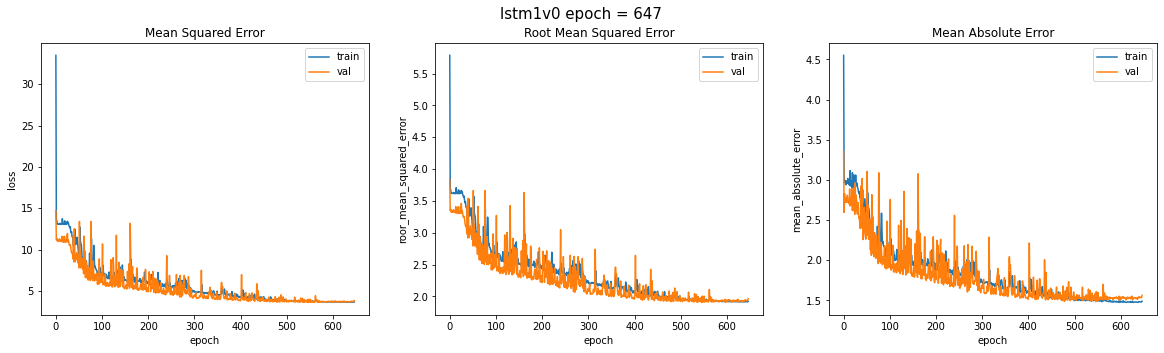

In [66]:
vis_results('lstm1v0', history_lstm1v0, epochs_lstm1v0)

In [55]:
results.update({'lstm1v0': eval_lstm1v0[1:]})

### lstm1

In [56]:
eval_lstm1, history_lstm1, epochs_lstm1 = model_history(lstm1, '/tmp/lstm1.h5', 0.01)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               69200     
                                                                 
 dense_21 (Dense)            (None, 1)                 101       
                                                                 
Total params: 69,301
Trainable params: 69,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
 9/10 [==========================>...] - ETA: 0s - loss: 35.6593 - mean_squared_error: 35.6593 - rmse: 5.9715 - mean_absolute_error: 4.7180
Epoch 00001: val_loss improved from inf to 14.61870, saving model to /tmp/lstm1.h5
10/10 [==============================] - 3s 140ms/step - loss: 35.4810 - mean_squar

Epoch 17/1000
 9/10 [==========================>...] - ETA: 0s - loss: 13.0902 - mean_squared_error: 13.0902 - rmse: 3.6180 - mean_absolute_error: 2.9806
Epoch 00017: val_loss did not improve from 10.97648
10/10 [==============================] - 1s 108ms/step - loss: 13.0644 - mean_squared_error: 13.0644 - rmse: 3.6145 - mean_absolute_error: 2.9782 - val_loss: 11.0173 - val_mean_squared_error: 11.0173 - val_rmse: 3.3192 - val_mean_absolute_error: 2.7268 - lr: 0.0100
Epoch 18/1000
 9/10 [==========================>...] - ETA: 0s - loss: 13.0955 - mean_squared_error: 13.0955 - rmse: 3.6188 - mean_absolute_error: 2.9668
Epoch 00018: val_loss improved from 10.97648 to 10.91767, saving model to /tmp/lstm1.h5
10/10 [==============================] - 1s 106ms/step - loss: 13.0354 - mean_squared_error: 13.0354 - rmse: 3.6105 - mean_absolute_error: 2.9590 - val_loss: 10.9177 - val_mean_squared_error: 10.9177 - val_rmse: 3.3042 - val_mean_absolute_error: 2.6771 - lr: 0.0100
Epoch 19/1000
 9/10 

Epoch 34/1000
 9/10 [==========================>...] - ETA: 0s - loss: 13.3537 - mean_squared_error: 13.3537 - rmse: 3.6543 - mean_absolute_error: 3.0710
Epoch 00034: val_loss did not improve from 9.89942
10/10 [==============================] - 1s 106ms/step - loss: 13.4539 - mean_squared_error: 13.4539 - rmse: 3.6680 - mean_absolute_error: 3.0815 - val_loss: 10.7685 - val_mean_squared_error: 10.7685 - val_rmse: 3.2815 - val_mean_absolute_error: 2.5678 - lr: 0.0100
Epoch 35/1000
 9/10 [==========================>...] - ETA: 0s - loss: 13.2558 - mean_squared_error: 13.2558 - rmse: 3.6409 - mean_absolute_error: 2.8738
Epoch 00035: val_loss did not improve from 9.89942
10/10 [==============================] - 1s 106ms/step - loss: 13.2223 - mean_squared_error: 13.2223 - rmse: 3.6363 - mean_absolute_error: 2.8707 - val_loss: 11.2651 - val_mean_squared_error: 11.2651 - val_rmse: 3.3563 - val_mean_absolute_error: 2.8561 - lr: 0.0100
Epoch 36/1000
 9/10 [==========================>...] - ETA

 9/10 [==========================>...] - ETA: 0s - loss: 10.6937 - mean_squared_error: 10.6937 - rmse: 3.2701 - mean_absolute_error: 2.6395
Epoch 00051: val_loss did not improve from 8.21009
10/10 [==============================] - 1s 99ms/step - loss: 10.6375 - mean_squared_error: 10.6375 - rmse: 3.2615 - mean_absolute_error: 2.6308 - val_loss: 11.1195 - val_mean_squared_error: 11.1195 - val_rmse: 3.3346 - val_mean_absolute_error: 2.8313 - lr: 0.0100
Epoch 52/1000
 9/10 [==========================>...] - ETA: 0s - loss: 10.2704 - mean_squared_error: 10.2704 - rmse: 3.2047 - mean_absolute_error: 2.5890
Epoch 00052: val_loss improved from 8.21009 to 7.76891, saving model to /tmp/lstm1.h5
10/10 [==============================] - 1s 100ms/step - loss: 10.2319 - mean_squared_error: 10.2319 - rmse: 3.1987 - mean_absolute_error: 2.5856 - val_loss: 7.7689 - val_mean_squared_error: 7.7689 - val_rmse: 2.7873 - val_mean_absolute_error: 2.2817 - lr: 0.0100
Epoch 53/1000
 9/10 [===================

 9/10 [==========================>...] - ETA: 0s - loss: 8.1901 - mean_squared_error: 8.1901 - rmse: 2.8618 - mean_absolute_error: 2.2982
Epoch 00068: val_loss improved from 6.96343 to 6.79978, saving model to /tmp/lstm1.h5
10/10 [==============================] - 1s 104ms/step - loss: 8.1741 - mean_squared_error: 8.1741 - rmse: 2.8590 - mean_absolute_error: 2.2967 - val_loss: 6.7998 - val_mean_squared_error: 6.7998 - val_rmse: 2.6076 - val_mean_absolute_error: 2.1064 - lr: 0.0100
Epoch 69/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.8104 - mean_squared_error: 7.8104 - rmse: 2.7947 - mean_absolute_error: 2.2235
Epoch 00069: val_loss did not improve from 6.79978
10/10 [==============================] - 1s 102ms/step - loss: 7.7886 - mean_squared_error: 7.7886 - rmse: 2.7908 - mean_absolute_error: 2.2215 - val_loss: 7.8918 - val_mean_squared_error: 7.8918 - val_rmse: 2.8092 - val_mean_absolute_error: 2.2873 - lr: 0.0100
Epoch 70/1000
 9/10 [==========================>.

 9/10 [==========================>...] - ETA: 0s - loss: 7.2083 - mean_squared_error: 7.2083 - rmse: 2.6848 - mean_absolute_error: 2.1141
Epoch 00085: val_loss did not improve from 6.00820
10/10 [==============================] - 1s 111ms/step - loss: 7.1877 - mean_squared_error: 7.1877 - rmse: 2.6810 - mean_absolute_error: 2.1123 - val_loss: 7.4751 - val_mean_squared_error: 7.4751 - val_rmse: 2.7341 - val_mean_absolute_error: 2.0950 - lr: 0.0100
Epoch 86/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.7733 - mean_squared_error: 7.7733 - rmse: 2.7881 - mean_absolute_error: 2.2190
Epoch 00086: val_loss did not improve from 6.00820
10/10 [==============================] - 1s 106ms/step - loss: 7.7649 - mean_squared_error: 7.7649 - rmse: 2.7865 - mean_absolute_error: 2.2169 - val_loss: 7.1071 - val_mean_squared_error: 7.1071 - val_rmse: 2.6659 - val_mean_absolute_error: 2.1720 - lr: 0.0100
Epoch 87/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.3171 - mean

Epoch 103/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.2011 - mean_squared_error: 7.2011 - rmse: 2.6835 - mean_absolute_error: 2.1186
Epoch 00103: val_loss did not improve from 5.76527
10/10 [==============================] - 1s 101ms/step - loss: 7.1753 - mean_squared_error: 7.1753 - rmse: 2.6787 - mean_absolute_error: 2.1159 - val_loss: 6.5838 - val_mean_squared_error: 6.5838 - val_rmse: 2.5659 - val_mean_absolute_error: 1.9705 - lr: 0.0100
Epoch 104/1000
 9/10 [==========================>...] - ETA: 0s - loss: 8.0023 - mean_squared_error: 8.0023 - rmse: 2.8288 - mean_absolute_error: 2.2052
Epoch 00104: val_loss did not improve from 5.76527
10/10 [==============================] - 1s 100ms/step - loss: 7.9975 - mean_squared_error: 7.9975 - rmse: 2.8280 - mean_absolute_error: 2.2053 - val_loss: 5.8096 - val_mean_squared_error: 5.8096 - val_rmse: 2.4103 - val_mean_absolute_error: 1.9217 - lr: 0.0100
Epoch 105/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 121/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.0377 - mean_squared_error: 7.0377 - rmse: 2.6529 - mean_absolute_error: 2.0971
Epoch 00121: val_loss did not improve from 5.58614
10/10 [==============================] - 1s 101ms/step - loss: 7.0017 - mean_squared_error: 7.0017 - rmse: 2.6461 - mean_absolute_error: 2.0907 - val_loss: 7.4398 - val_mean_squared_error: 7.4398 - val_rmse: 2.7276 - val_mean_absolute_error: 2.0766 - lr: 0.0100
Epoch 122/1000
 9/10 [==========================>...] - ETA: 0s - loss: 8.4146 - mean_squared_error: 8.4146 - rmse: 2.9008 - mean_absolute_error: 2.2867
Epoch 00122: val_loss did not improve from 5.58614
10/10 [==============================] - 1s 102ms/step - loss: 8.3970 - mean_squared_error: 8.3970 - rmse: 2.8978 - mean_absolute_error: 2.2865 - val_loss: 6.1266 - val_mean_squared_error: 6.1266 - val_rmse: 2.4752 - val_mean_absolute_error: 1.9294 - lr: 0.0100
Epoch 123/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 139/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.4231 - mean_squared_error: 6.4231 - rmse: 2.5344 - mean_absolute_error: 2.0049
Epoch 00139: val_loss did not improve from 5.44139
10/10 [==============================] - 1s 101ms/step - loss: 6.4926 - mean_squared_error: 6.4926 - rmse: 2.5481 - mean_absolute_error: 2.0124 - val_loss: 6.2191 - val_mean_squared_error: 6.2191 - val_rmse: 2.4938 - val_mean_absolute_error: 2.0206 - lr: 0.0100
Epoch 140/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.4194 - mean_squared_error: 6.4194 - rmse: 2.5337 - mean_absolute_error: 1.9836
Epoch 00140: val_loss did not improve from 5.44139
10/10 [==============================] - 1s 101ms/step - loss: 6.4362 - mean_squared_error: 6.4362 - rmse: 2.5370 - mean_absolute_error: 1.9854 - val_loss: 5.6432 - val_mean_squared_error: 5.6432 - val_rmse: 2.3755 - val_mean_absolute_error: 1.8855 - lr: 0.0100
Epoch 141/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 157/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.8809 - mean_squared_error: 6.8809 - rmse: 2.6232 - mean_absolute_error: 2.0691
Epoch 00157: val_loss did not improve from 5.35269
10/10 [==============================] - 1s 102ms/step - loss: 6.8533 - mean_squared_error: 6.8533 - rmse: 2.6179 - mean_absolute_error: 2.0655 - val_loss: 6.9069 - val_mean_squared_error: 6.9069 - val_rmse: 2.6281 - val_mean_absolute_error: 2.1382 - lr: 0.0100
Epoch 158/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.4445 - mean_squared_error: 6.4445 - rmse: 2.5386 - mean_absolute_error: 2.0169
Epoch 00158: val_loss did not improve from 5.35269
10/10 [==============================] - 1s 100ms/step - loss: 6.4426 - mean_squared_error: 6.4426 - rmse: 2.5382 - mean_absolute_error: 2.0171 - val_loss: 5.6997 - val_mean_squared_error: 5.6997 - val_rmse: 2.3874 - val_mean_absolute_error: 1.8952 - lr: 0.0100
Epoch 159/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 175/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.2862 - mean_squared_error: 6.2862 - rmse: 2.5072 - mean_absolute_error: 1.9677
Epoch 00175: val_loss improved from 5.29551 to 5.27682, saving model to /tmp/lstm1.h5
10/10 [==============================] - 1s 103ms/step - loss: 6.3157 - mean_squared_error: 6.3157 - rmse: 2.5131 - mean_absolute_error: 1.9722 - val_loss: 5.2768 - val_mean_squared_error: 5.2768 - val_rmse: 2.2971 - val_mean_absolute_error: 1.8018 - lr: 0.0100
Epoch 176/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.3022 - mean_squared_error: 6.3022 - rmse: 2.5104 - mean_absolute_error: 1.9693
Epoch 00176: val_loss did not improve from 5.27682
10/10 [==============================] - 1s 104ms/step - loss: 6.3577 - mean_squared_error: 6.3577 - rmse: 2.5215 - mean_absolute_error: 1.9771 - val_loss: 8.7747 - val_mean_squared_error: 8.7747 - val_rmse: 2.9622 - val_mean_absolute_error: 2.4575 - lr: 0.0100
Epoch 177/1000
 9/10 [===========

Epoch 193/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1422 - mean_squared_error: 6.1422 - rmse: 2.4783 - mean_absolute_error: 1.9298
Epoch 00193: val_loss did not improve from 5.25069
10/10 [==============================] - 1s 101ms/step - loss: 6.1127 - mean_squared_error: 6.1127 - rmse: 2.4724 - mean_absolute_error: 1.9239 - val_loss: 5.4675 - val_mean_squared_error: 5.4675 - val_rmse: 2.3383 - val_mean_absolute_error: 1.8450 - lr: 0.0100
Epoch 194/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1321 - mean_squared_error: 6.1321 - rmse: 2.4763 - mean_absolute_error: 1.9353
Epoch 00194: val_loss did not improve from 5.25069
10/10 [==============================] - 1s 102ms/step - loss: 6.1200 - mean_squared_error: 6.1200 - rmse: 2.4739 - mean_absolute_error: 1.9348 - val_loss: 5.3501 - val_mean_squared_error: 5.3501 - val_rmse: 2.3130 - val_mean_absolute_error: 1.8210 - lr: 0.0100
Epoch 195/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 211/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.5117 - mean_squared_error: 6.5117 - rmse: 2.5518 - mean_absolute_error: 2.0054
Epoch 00211: val_loss did not improve from 5.15108
10/10 [==============================] - 1s 102ms/step - loss: 6.4967 - mean_squared_error: 6.4967 - rmse: 2.5489 - mean_absolute_error: 2.0036 - val_loss: 5.7159 - val_mean_squared_error: 5.7159 - val_rmse: 2.3908 - val_mean_absolute_error: 1.8372 - lr: 0.0100
Epoch 212/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.8596 - mean_squared_error: 6.8596 - rmse: 2.6191 - mean_absolute_error: 2.0651
Epoch 00212: val_loss improved from 5.15108 to 5.09528, saving model to /tmp/lstm1.h5
10/10 [==============================] - 1s 101ms/step - loss: 6.8737 - mean_squared_error: 6.8737 - rmse: 2.6218 - mean_absolute_error: 2.0652 - val_loss: 5.0953 - val_mean_squared_error: 5.0953 - val_rmse: 2.2573 - val_mean_absolute_error: 1.7718 - lr: 0.0100
Epoch 213/1000
 9/10 [===========

Epoch 229/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.7870 - mean_squared_error: 5.7870 - rmse: 2.4056 - mean_absolute_error: 1.8938
Epoch 00229: val_loss did not improve from 5.03413
10/10 [==============================] - 1s 101ms/step - loss: 5.8296 - mean_squared_error: 5.8296 - rmse: 2.4145 - mean_absolute_error: 1.8958 - val_loss: 5.2917 - val_mean_squared_error: 5.2917 - val_rmse: 2.3004 - val_mean_absolute_error: 1.8059 - lr: 0.0100
Epoch 230/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.4169 - mean_squared_error: 6.4169 - rmse: 2.5332 - mean_absolute_error: 1.9797
Epoch 00230: val_loss did not improve from 5.03413
10/10 [==============================] - 1s 101ms/step - loss: 6.3991 - mean_squared_error: 6.3991 - rmse: 2.5296 - mean_absolute_error: 1.9789 - val_loss: 5.0724 - val_mean_squared_error: 5.0724 - val_rmse: 2.2522 - val_mean_absolute_error: 1.7847 - lr: 0.0100
Epoch 231/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 247/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.3558 - mean_squared_error: 6.3558 - rmse: 2.5211 - mean_absolute_error: 1.9980
Epoch 00247: val_loss did not improve from 4.97971
10/10 [==============================] - 1s 101ms/step - loss: 6.3361 - mean_squared_error: 6.3361 - rmse: 2.5172 - mean_absolute_error: 1.9951 - val_loss: 7.8056 - val_mean_squared_error: 7.8056 - val_rmse: 2.7938 - val_mean_absolute_error: 2.3321 - lr: 0.0100
Epoch 248/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.2771 - mean_squared_error: 6.2771 - rmse: 2.5054 - mean_absolute_error: 1.9772
Epoch 00248: val_loss did not improve from 4.97971
10/10 [==============================] - 1s 100ms/step - loss: 6.2864 - mean_squared_error: 6.2864 - rmse: 2.5073 - mean_absolute_error: 1.9803 - val_loss: 5.2656 - val_mean_squared_error: 5.2656 - val_rmse: 2.2947 - val_mean_absolute_error: 1.8116 - lr: 0.0100
Epoch 249/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 265/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.9134 - mean_squared_error: 5.9134 - rmse: 2.4317 - mean_absolute_error: 1.8891
Epoch 00265: val_loss did not improve from 4.85841
10/10 [==============================] - 1s 101ms/step - loss: 5.8885 - mean_squared_error: 5.8885 - rmse: 2.4266 - mean_absolute_error: 1.8855 - val_loss: 5.2801 - val_mean_squared_error: 5.2801 - val_rmse: 2.2978 - val_mean_absolute_error: 1.8265 - lr: 0.0100
Epoch 266/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.5764 - mean_squared_error: 5.5764 - rmse: 2.3614 - mean_absolute_error: 1.8423
Epoch 00266: val_loss did not improve from 4.85841
10/10 [==============================] - 1s 101ms/step - loss: 5.6172 - mean_squared_error: 5.6172 - rmse: 2.3701 - mean_absolute_error: 1.8500 - val_loss: 4.8900 - val_mean_squared_error: 4.8900 - val_rmse: 2.2113 - val_mean_absolute_error: 1.7209 - lr: 0.0100
Epoch 267/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 283/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.3986 - mean_squared_error: 5.3986 - rmse: 2.3235 - mean_absolute_error: 1.8106
Epoch 00283: val_loss improved from 4.76558 to 4.74457, saving model to /tmp/lstm1.h5
10/10 [==============================] - 1s 101ms/step - loss: 5.4583 - mean_squared_error: 5.4583 - rmse: 2.3363 - mean_absolute_error: 1.8215 - val_loss: 4.7446 - val_mean_squared_error: 4.7446 - val_rmse: 2.1782 - val_mean_absolute_error: 1.7239 - lr: 0.0100
Epoch 284/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.4787 - mean_squared_error: 5.4787 - rmse: 2.3407 - mean_absolute_error: 1.8309
Epoch 00284: val_loss did not improve from 4.74457
10/10 [==============================] - 1s 101ms/step - loss: 5.5157 - mean_squared_error: 5.5157 - rmse: 2.3485 - mean_absolute_error: 1.8368 - val_loss: 7.5567 - val_mean_squared_error: 7.5567 - val_rmse: 2.7489 - val_mean_absolute_error: 2.2760 - lr: 0.0100
Epoch 285/1000
 9/10 [===========

 9/10 [==========================>...] - ETA: 0s - loss: 5.6179 - mean_squared_error: 5.6179 - rmse: 2.3702 - mean_absolute_error: 1.8537
Epoch 00300: val_loss improved from 4.66391 to 4.63419, saving model to /tmp/lstm1.h5
10/10 [==============================] - 1s 105ms/step - loss: 5.5865 - mean_squared_error: 5.5865 - rmse: 2.3636 - mean_absolute_error: 1.8461 - val_loss: 4.6342 - val_mean_squared_error: 4.6342 - val_rmse: 2.1527 - val_mean_absolute_error: 1.6885 - lr: 0.0100
Epoch 301/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.7667 - mean_squared_error: 5.7667 - rmse: 2.4014 - mean_absolute_error: 1.8765
Epoch 00301: val_loss did not improve from 4.63419
10/10 [==============================] - 1s 102ms/step - loss: 5.8468 - mean_squared_error: 5.8468 - rmse: 2.4180 - mean_absolute_error: 1.8850 - val_loss: 6.0536 - val_mean_squared_error: 6.0536 - val_rmse: 2.4604 - val_mean_absolute_error: 1.9914 - lr: 0.0100
Epoch 302/1000
 9/10 [==========================

Epoch 318/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.6978 - mean_squared_error: 5.6978 - rmse: 2.3870 - mean_absolute_error: 1.8609
Epoch 00318: val_loss did not improve from 4.63419
10/10 [==============================] - 1s 101ms/step - loss: 5.6921 - mean_squared_error: 5.6921 - rmse: 2.3858 - mean_absolute_error: 1.8583 - val_loss: 4.9629 - val_mean_squared_error: 4.9629 - val_rmse: 2.2277 - val_mean_absolute_error: 1.7225 - lr: 0.0100
Epoch 319/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.4918 - mean_squared_error: 6.4918 - rmse: 2.5479 - mean_absolute_error: 2.0135
Epoch 00319: val_loss did not improve from 4.63419
10/10 [==============================] - 1s 101ms/step - loss: 6.4659 - mean_squared_error: 6.4659 - rmse: 2.5428 - mean_absolute_error: 2.0071 - val_loss: 4.7431 - val_mean_squared_error: 4.7431 - val_rmse: 2.1779 - val_mean_absolute_error: 1.6808 - lr: 0.0100
Epoch 320/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 336/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.6027 - mean_squared_error: 5.6027 - rmse: 2.3670 - mean_absolute_error: 1.8513
Epoch 00336: val_loss did not improve from 4.63419
10/10 [==============================] - 1s 101ms/step - loss: 5.6268 - mean_squared_error: 5.6268 - rmse: 2.3721 - mean_absolute_error: 1.8545 - val_loss: 5.1594 - val_mean_squared_error: 5.1594 - val_rmse: 2.2714 - val_mean_absolute_error: 1.8152 - lr: 0.0050
Epoch 337/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.3727 - mean_squared_error: 5.3727 - rmse: 2.3179 - mean_absolute_error: 1.7942
Epoch 00337: val_loss did not improve from 4.63419
10/10 [==============================] - 1s 101ms/step - loss: 5.3733 - mean_squared_error: 5.3733 - rmse: 2.3180 - mean_absolute_error: 1.7955 - val_loss: 4.7916 - val_mean_squared_error: 4.7916 - val_rmse: 2.1890 - val_mean_absolute_error: 1.7072 - lr: 0.0050
Epoch 338/1000
 9/10 [==========================>...] - ETA: 0s - lo

 9/10 [==========================>...] - ETA: 0s - loss: 5.3725 - mean_squared_error: 5.3725 - rmse: 2.3179 - mean_absolute_error: 1.8109
Epoch 00353: val_loss did not improve from 4.54625
10/10 [==============================] - 1s 103ms/step - loss: 5.3513 - mean_squared_error: 5.3513 - rmse: 2.3133 - mean_absolute_error: 1.8063 - val_loss: 4.9139 - val_mean_squared_error: 4.9139 - val_rmse: 2.2167 - val_mean_absolute_error: 1.7563 - lr: 0.0050
Epoch 354/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.1988 - mean_squared_error: 5.1988 - rmse: 2.2801 - mean_absolute_error: 1.7822
Epoch 00354: val_loss did not improve from 4.54625
10/10 [==============================] - 1s 100ms/step - loss: 5.1771 - mean_squared_error: 5.1771 - rmse: 2.2753 - mean_absolute_error: 1.7791 - val_loss: 4.8377 - val_mean_squared_error: 4.8377 - val_rmse: 2.1995 - val_mean_absolute_error: 1.7379 - lr: 0.0050
Epoch 355/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.2238 - me

Epoch 371/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.2462 - mean_squared_error: 5.2462 - rmse: 2.2905 - mean_absolute_error: 1.7937
Epoch 00371: val_loss did not improve from 4.54625
10/10 [==============================] - 1s 101ms/step - loss: 5.2199 - mean_squared_error: 5.2199 - rmse: 2.2847 - mean_absolute_error: 1.7900 - val_loss: 5.1752 - val_mean_squared_error: 5.1752 - val_rmse: 2.2749 - val_mean_absolute_error: 1.8009 - lr: 0.0050
Epoch 372/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.0844 - mean_squared_error: 5.0844 - rmse: 2.2549 - mean_absolute_error: 1.7648
Epoch 00372: val_loss improved from 4.54625 to 4.52516, saving model to /tmp/lstm1.h5
10/10 [==============================] - 1s 101ms/step - loss: 5.0885 - mean_squared_error: 5.0885 - rmse: 2.2558 - mean_absolute_error: 1.7648 - val_loss: 4.5252 - val_mean_squared_error: 4.5252 - val_rmse: 2.1272 - val_mean_absolute_error: 1.6563 - lr: 0.0050
Epoch 373/1000
 9/10 [===========

Epoch 389/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.2369 - mean_squared_error: 5.2369 - rmse: 2.2884 - mean_absolute_error: 1.7636
Epoch 00389: val_loss did not improve from 4.50514
10/10 [==============================] - 1s 101ms/step - loss: 5.2371 - mean_squared_error: 5.2371 - rmse: 2.2885 - mean_absolute_error: 1.7652 - val_loss: 4.6667 - val_mean_squared_error: 4.6667 - val_rmse: 2.1603 - val_mean_absolute_error: 1.7015 - lr: 0.0050
Epoch 390/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.1327 - mean_squared_error: 5.1327 - rmse: 2.2655 - mean_absolute_error: 1.7769
Epoch 00390: val_loss did not improve from 4.50514
10/10 [==============================] - 1s 101ms/step - loss: 5.1421 - mean_squared_error: 5.1421 - rmse: 2.2676 - mean_absolute_error: 1.7797 - val_loss: 6.9482 - val_mean_squared_error: 6.9482 - val_rmse: 2.6359 - val_mean_absolute_error: 2.1705 - lr: 0.0050
Epoch 391/1000
 9/10 [==========================>...] - ETA: 0s - lo

 9/10 [==========================>...] - ETA: 0s - loss: 5.1902 - mean_squared_error: 5.1902 - rmse: 2.2782 - mean_absolute_error: 1.7785
Epoch 00406: val_loss did not improve from 4.44099
10/10 [==============================] - 1s 102ms/step - loss: 5.1627 - mean_squared_error: 5.1627 - rmse: 2.2722 - mean_absolute_error: 1.7730 - val_loss: 4.9360 - val_mean_squared_error: 4.9360 - val_rmse: 2.2217 - val_mean_absolute_error: 1.7568 - lr: 0.0050
Epoch 407/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.1148 - mean_squared_error: 5.1148 - rmse: 2.2616 - mean_absolute_error: 1.7575
Epoch 00407: val_loss did not improve from 4.44099
10/10 [==============================] - 1s 101ms/step - loss: 5.1459 - mean_squared_error: 5.1459 - rmse: 2.2685 - mean_absolute_error: 1.7618 - val_loss: 6.8295 - val_mean_squared_error: 6.8295 - val_rmse: 2.6133 - val_mean_absolute_error: 2.1334 - lr: 0.0050
Epoch 408/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.4566 - me

Epoch 424/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.0929 - mean_squared_error: 5.0929 - rmse: 2.2567 - mean_absolute_error: 1.7621
Epoch 00424: val_loss did not improve from 4.37819
10/10 [==============================] - 1s 102ms/step - loss: 5.0615 - mean_squared_error: 5.0615 - rmse: 2.2498 - mean_absolute_error: 1.7554 - val_loss: 4.4185 - val_mean_squared_error: 4.4185 - val_rmse: 2.1020 - val_mean_absolute_error: 1.6379 - lr: 0.0050
Epoch 425/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.2025 - mean_squared_error: 5.2025 - rmse: 2.2809 - mean_absolute_error: 1.7698
Epoch 00425: val_loss improved from 4.37819 to 4.35496, saving model to /tmp/lstm1.h5
10/10 [==============================] - 1s 101ms/step - loss: 5.1881 - mean_squared_error: 5.1881 - rmse: 2.2777 - mean_absolute_error: 1.7652 - val_loss: 4.3550 - val_mean_squared_error: 4.3550 - val_rmse: 2.0869 - val_mean_absolute_error: 1.6353 - lr: 0.0050
Epoch 426/1000
 9/10 [===========

Epoch 442/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.8678 - mean_squared_error: 4.8678 - rmse: 2.2063 - mean_absolute_error: 1.7151
Epoch 00442: val_loss did not improve from 4.35496
10/10 [==============================] - 1s 102ms/step - loss: 4.8716 - mean_squared_error: 4.8716 - rmse: 2.2072 - mean_absolute_error: 1.7160 - val_loss: 4.7096 - val_mean_squared_error: 4.7096 - val_rmse: 2.1702 - val_mean_absolute_error: 1.7185 - lr: 0.0050
Epoch 443/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.8866 - mean_squared_error: 4.8866 - rmse: 2.2106 - mean_absolute_error: 1.7171
Epoch 00443: val_loss did not improve from 4.35496
10/10 [==============================] - 1s 102ms/step - loss: 4.8616 - mean_squared_error: 4.8616 - rmse: 2.2049 - mean_absolute_error: 1.7127 - val_loss: 4.8097 - val_mean_squared_error: 4.8097 - val_rmse: 2.1931 - val_mean_absolute_error: 1.7299 - lr: 0.0050
Epoch 444/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 460/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.8470 - mean_squared_error: 4.8470 - rmse: 2.2016 - mean_absolute_error: 1.7216
Epoch 00460: val_loss did not improve from 4.30127
10/10 [==============================] - 1s 102ms/step - loss: 4.8541 - mean_squared_error: 4.8541 - rmse: 2.2032 - mean_absolute_error: 1.7222 - val_loss: 4.9137 - val_mean_squared_error: 4.9137 - val_rmse: 2.2167 - val_mean_absolute_error: 1.7493 - lr: 0.0025
Epoch 461/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.9546 - mean_squared_error: 4.9546 - rmse: 2.2259 - mean_absolute_error: 1.7418
Epoch 00461: val_loss did not improve from 4.30127
10/10 [==============================] - 1s 101ms/step - loss: 4.9255 - mean_squared_error: 4.9255 - rmse: 2.2194 - mean_absolute_error: 1.7347 - val_loss: 4.3676 - val_mean_squared_error: 4.3676 - val_rmse: 2.0899 - val_mean_absolute_error: 1.6303 - lr: 0.0025
Epoch 462/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 478/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.7253 - mean_squared_error: 4.7253 - rmse: 2.1738 - mean_absolute_error: 1.6884
Epoch 00478: val_loss did not improve from 4.30127

Epoch 00478: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
10/10 [==============================] - 1s 101ms/step - loss: 4.7351 - mean_squared_error: 4.7351 - rmse: 2.1760 - mean_absolute_error: 1.6918 - val_loss: 4.6386 - val_mean_squared_error: 4.6386 - val_rmse: 2.1537 - val_mean_absolute_error: 1.6997 - lr: 0.0025
Epoch 479/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.7075 - mean_squared_error: 4.7075 - rmse: 2.1697 - mean_absolute_error: 1.6898
Epoch 00479: val_loss did not improve from 4.30127
10/10 [==============================] - 1s 101ms/step - loss: 4.7121 - mean_squared_error: 4.7121 - rmse: 2.1707 - mean_absolute_error: 1.6919 - val_loss: 4.4472 - val_mean_squared_error: 4.4472 - val_rmse: 2.1088 - val_mean_absolute_error: 1.6648 

Epoch 496/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6997 - mean_squared_error: 4.6997 - rmse: 2.1679 - mean_absolute_error: 1.6915
Epoch 00496: val_loss did not improve from 4.27222
10/10 [==============================] - 1s 101ms/step - loss: 4.6924 - mean_squared_error: 4.6924 - rmse: 2.1662 - mean_absolute_error: 1.6912 - val_loss: 4.6625 - val_mean_squared_error: 4.6625 - val_rmse: 2.1593 - val_mean_absolute_error: 1.6920 - lr: 0.0012
Epoch 497/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.7220 - mean_squared_error: 4.7220 - rmse: 2.1730 - mean_absolute_error: 1.6913
Epoch 00497: val_loss did not improve from 4.27222
10/10 [==============================] - 1s 104ms/step - loss: 4.7063 - mean_squared_error: 4.7063 - rmse: 2.1694 - mean_absolute_error: 1.6893 - val_loss: 4.4607 - val_mean_squared_error: 4.4607 - val_rmse: 2.1120 - val_mean_absolute_error: 1.6504 - lr: 0.0012
Epoch 498/1000
 9/10 [==========================>...] - ETA: 0s - lo

 9/10 [==========================>...] - ETA: 0s - loss: 4.6634 - mean_squared_error: 4.6634 - rmse: 2.1595 - mean_absolute_error: 1.6797
Epoch 00513: val_loss did not improve from 4.27222
10/10 [==============================] - 1s 103ms/step - loss: 4.6469 - mean_squared_error: 4.6469 - rmse: 2.1557 - mean_absolute_error: 1.6764 - val_loss: 4.4538 - val_mean_squared_error: 4.4538 - val_rmse: 2.1104 - val_mean_absolute_error: 1.6562 - lr: 6.2500e-04
Epoch 514/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6708 - mean_squared_error: 4.6708 - rmse: 2.1612 - mean_absolute_error: 1.6856
Epoch 00514: val_loss did not improve from 4.27222
10/10 [==============================] - 1s 103ms/step - loss: 4.6529 - mean_squared_error: 4.6529 - rmse: 2.1571 - mean_absolute_error: 1.6827 - val_loss: 4.4866 - val_mean_squared_error: 4.4866 - val_rmse: 2.1182 - val_mean_absolute_error: 1.6674 - lr: 6.2500e-04
Epoch 515/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6

 9/10 [==========================>...] - ETA: 0s - loss: 4.6280 - mean_squared_error: 4.6280 - rmse: 2.1513 - mean_absolute_error: 1.6742
Epoch 00530: val_loss did not improve from 4.27222
10/10 [==============================] - 1s 102ms/step - loss: 4.6150 - mean_squared_error: 4.6150 - rmse: 2.1483 - mean_absolute_error: 1.6717 - val_loss: 4.3470 - val_mean_squared_error: 4.3470 - val_rmse: 2.0850 - val_mean_absolute_error: 1.6349 - lr: 3.1250e-04
Epoch 531/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6179 - mean_squared_error: 4.6179 - rmse: 2.1489 - mean_absolute_error: 1.6723
Epoch 00531: val_loss did not improve from 4.27222
10/10 [==============================] - 1s 103ms/step - loss: 4.6157 - mean_squared_error: 4.6157 - rmse: 2.1484 - mean_absolute_error: 1.6728 - val_loss: 4.5008 - val_mean_squared_error: 4.5008 - val_rmse: 2.1215 - val_mean_absolute_error: 1.6703 - lr: 3.1250e-04
Epoch 532/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6

 9/10 [==========================>...] - ETA: 0s - loss: 4.6023 - mean_squared_error: 4.6023 - rmse: 2.1453 - mean_absolute_error: 1.6737
Epoch 00547: val_loss did not improve from 4.27222
10/10 [==============================] - 1s 101ms/step - loss: 4.6007 - mean_squared_error: 4.6007 - rmse: 2.1449 - mean_absolute_error: 1.6743 - val_loss: 4.3982 - val_mean_squared_error: 4.3982 - val_rmse: 2.0972 - val_mean_absolute_error: 1.6479 - lr: 1.5625e-04
Epoch 548/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6269 - mean_squared_error: 4.6269 - rmse: 2.1510 - mean_absolute_error: 1.6684
Epoch 00548: val_loss did not improve from 4.27222
10/10 [==============================] - 1s 102ms/step - loss: 4.6171 - mean_squared_error: 4.6171 - rmse: 2.1487 - mean_absolute_error: 1.6676 - val_loss: 4.2908 - val_mean_squared_error: 4.2908 - val_rmse: 2.0714 - val_mean_absolute_error: 1.6222 - lr: 1.5625e-04
Epoch 549/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6

Epoch 565/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.5764 - mean_squared_error: 4.5764 - rmse: 2.1393 - mean_absolute_error: 1.6705
Epoch 00565: val_loss did not improve from 4.27222

Epoch 00565: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
10/10 [==============================] - 1s 103ms/step - loss: 4.5884 - mean_squared_error: 4.5884 - rmse: 2.1420 - mean_absolute_error: 1.6718 - val_loss: 4.4129 - val_mean_squared_error: 4.4129 - val_rmse: 2.1007 - val_mean_absolute_error: 1.6558 - lr: 1.5625e-04
Epoch 566/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6032 - mean_squared_error: 4.6032 - rmse: 2.1455 - mean_absolute_error: 1.6752
Epoch 00566: val_loss did not improve from 4.27222
10/10 [==============================] - 1s 101ms/step - loss: 4.5872 - mean_squared_error: 4.5872 - rmse: 2.1418 - mean_absolute_error: 1.6724 - val_loss: 4.3973 - val_mean_squared_error: 4.3973 - val_rmse: 2.0970 - val_mean_absolute_error: 1.6

 9/10 [==========================>...] - ETA: 0s - loss: 4.5996 - mean_squared_error: 4.5996 - rmse: 2.1447 - mean_absolute_error: 1.6707
Epoch 00582: val_loss did not improve from 4.27222
10/10 [==============================] - 1s 102ms/step - loss: 4.5800 - mean_squared_error: 4.5800 - rmse: 2.1401 - mean_absolute_error: 1.6673 - val_loss: 4.4194 - val_mean_squared_error: 4.4194 - val_rmse: 2.1022 - val_mean_absolute_error: 1.6534 - lr: 7.8125e-05
Epoch 583/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6112 - mean_squared_error: 4.6112 - rmse: 2.1474 - mean_absolute_error: 1.6730
Epoch 00583: val_loss did not improve from 4.27222
10/10 [==============================] - 1s 102ms/step - loss: 4.5816 - mean_squared_error: 4.5816 - rmse: 2.1405 - mean_absolute_error: 1.6662 - val_loss: 4.3825 - val_mean_squared_error: 4.3825 - val_rmse: 2.0934 - val_mean_absolute_error: 1.6444 - lr: 7.8125e-05
Epoch 584/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6

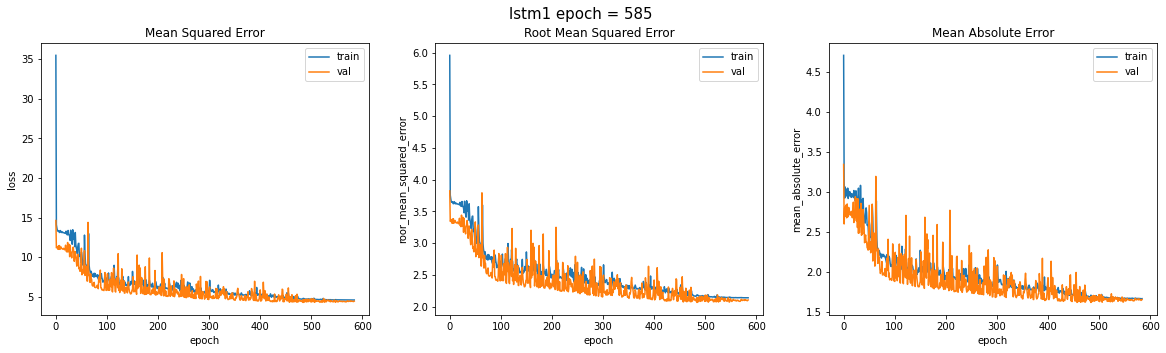

In [67]:
vis_results('lstm1', history_lstm1, epochs_lstm1)

In [58]:
results.update({'lstm1': eval_lstm1[1:]})

### lstm2

In [68]:
eval_lstm2, history_lstm2, epochs_lstm2 = model_history(lstm2, '/tmp/lstm2.h5', 0.01)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 100)          69200     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_22 (Dense)            (None, 1)                 101       
                                                                 
Total params: 149,701
Trainable params: 149,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 37.0678 - mean_squared_error: 37.0678 - rmse: 6.0883 - mean_absolute_error: 4.7637
Epoch 00001: val_loss improved f

10/10 [==============================] - ETA: 0s - loss: 13.2978 - mean_squared_error: 13.2978 - rmse: 3.6466 - mean_absolute_error: 2.9264
Epoch 00016: val_loss did not improve from 10.98046
10/10 [==============================] - 2s 218ms/step - loss: 13.2978 - mean_squared_error: 13.2978 - rmse: 3.6466 - mean_absolute_error: 2.9264 - val_loss: 11.3126 - val_mean_squared_error: 11.3126 - val_rmse: 3.3634 - val_mean_absolute_error: 2.8122 - lr: 0.0100
Epoch 17/1000
 9/10 [==========================>...] - ETA: 0s - loss: 13.2320 - mean_squared_error: 13.2320 - rmse: 3.6376 - mean_absolute_error: 3.0446
Epoch 00017: val_loss did not improve from 10.98046
10/10 [==============================] - 2s 218ms/step - loss: 13.3645 - mean_squared_error: 13.3645 - rmse: 3.6557 - mean_absolute_error: 3.0606 - val_loss: 11.0300 - val_mean_squared_error: 11.0300 - val_rmse: 3.3211 - val_mean_absolute_error: 2.7158 - lr: 0.0100
Epoch 18/1000
10/10 [==============================] - ETA: 0s - loss:

10/10 [==============================] - ETA: 0s - loss: 13.1871 - mean_squared_error: 13.1871 - rmse: 3.6314 - mean_absolute_error: 3.0107
Epoch 00033: val_loss did not improve from 10.97840
10/10 [==============================] - 2s 217ms/step - loss: 13.1871 - mean_squared_error: 13.1871 - rmse: 3.6314 - mean_absolute_error: 3.0107 - val_loss: 11.0399 - val_mean_squared_error: 11.0399 - val_rmse: 3.3226 - val_mean_absolute_error: 2.7209 - lr: 0.0100
Epoch 34/1000
10/10 [==============================] - ETA: 0s - loss: 13.1985 - mean_squared_error: 13.1985 - rmse: 3.6330 - mean_absolute_error: 2.9284
Epoch 00034: val_loss did not improve from 10.97840
10/10 [==============================] - 2s 216ms/step - loss: 13.1985 - mean_squared_error: 13.1985 - rmse: 3.6330 - mean_absolute_error: 2.9284 - val_loss: 11.2746 - val_mean_squared_error: 11.2746 - val_rmse: 3.3578 - val_mean_absolute_error: 2.8021 - lr: 0.0100
Epoch 35/1000
10/10 [==============================] - ETA: 0s - loss:

10/10 [==============================] - ETA: 0s - loss: 13.2466 - mean_squared_error: 13.2466 - rmse: 3.6396 - mean_absolute_error: 2.9416
Epoch 00050: val_loss did not improve from 10.97639
10/10 [==============================] - 2s 217ms/step - loss: 13.2466 - mean_squared_error: 13.2466 - rmse: 3.6396 - mean_absolute_error: 2.9416 - val_loss: 11.3383 - val_mean_squared_error: 11.3383 - val_rmse: 3.3672 - val_mean_absolute_error: 2.8191 - lr: 0.0100
Epoch 51/1000
10/10 [==============================] - ETA: 0s - loss: 13.1066 - mean_squared_error: 13.1066 - rmse: 3.6203 - mean_absolute_error: 2.9698
Epoch 00051: val_loss did not improve from 10.97639
10/10 [==============================] - 2s 218ms/step - loss: 13.1066 - mean_squared_error: 13.1066 - rmse: 3.6203 - mean_absolute_error: 2.9698 - val_loss: 11.0502 - val_mean_squared_error: 11.0502 - val_rmse: 3.3242 - val_mean_absolute_error: 2.7277 - lr: 0.0100
Epoch 52/1000
10/10 [==============================] - ETA: 0s - loss:

10/10 [==============================] - ETA: 0s - loss: 13.1167 - mean_squared_error: 13.1167 - rmse: 3.6217 - mean_absolute_error: 2.9372
Epoch 00067: val_loss did not improve from 10.96606
10/10 [==============================] - 2s 219ms/step - loss: 13.1167 - mean_squared_error: 13.1167 - rmse: 3.6217 - mean_absolute_error: 2.9372 - val_loss: 11.3596 - val_mean_squared_error: 11.3596 - val_rmse: 3.3704 - val_mean_absolute_error: 2.8245 - lr: 0.0100
Epoch 68/1000
10/10 [==============================] - ETA: 0s - loss: 13.0652 - mean_squared_error: 13.0652 - rmse: 3.6146 - mean_absolute_error: 2.9616
Epoch 00068: val_loss did not improve from 10.96606
10/10 [==============================] - 2s 218ms/step - loss: 13.0652 - mean_squared_error: 13.0652 - rmse: 3.6146 - mean_absolute_error: 2.9616 - val_loss: 10.9821 - val_mean_squared_error: 10.9821 - val_rmse: 3.3139 - val_mean_absolute_error: 2.6506 - lr: 0.0100
Epoch 69/1000
10/10 [==============================] - ETA: 0s - loss:

Epoch 84/1000
10/10 [==============================] - ETA: 0s - loss: 11.4276 - mean_squared_error: 11.4276 - rmse: 3.3805 - mean_absolute_error: 2.7824
Epoch 00084: val_loss improved from 9.84796 to 8.91499, saving model to /tmp/lstm2.h5
10/10 [==============================] - 2s 217ms/step - loss: 11.4276 - mean_squared_error: 11.4276 - rmse: 3.3805 - mean_absolute_error: 2.7824 - val_loss: 8.9150 - val_mean_squared_error: 8.9150 - val_rmse: 2.9858 - val_mean_absolute_error: 2.3796 - lr: 0.0050
Epoch 85/1000
10/10 [==============================] - ETA: 0s - loss: 10.3023 - mean_squared_error: 10.3023 - rmse: 3.2097 - mean_absolute_error: 2.6132
Epoch 00085: val_loss improved from 8.91499 to 8.74668, saving model to /tmp/lstm2.h5
10/10 [==============================] - 2s 217ms/step - loss: 10.3023 - mean_squared_error: 10.3023 - rmse: 3.2097 - mean_absolute_error: 2.6132 - val_loss: 8.7467 - val_mean_squared_error: 8.7467 - val_rmse: 2.9575 - val_mean_absolute_error: 2.4753 - lr:

Epoch 101/1000
10/10 [==============================] - ETA: 0s - loss: 7.5468 - mean_squared_error: 7.5468 - rmse: 2.7471 - mean_absolute_error: 2.2136
Epoch 00101: val_loss did not improve from 6.43925
10/10 [==============================] - 2s 218ms/step - loss: 7.5468 - mean_squared_error: 7.5468 - rmse: 2.7471 - mean_absolute_error: 2.2136 - val_loss: 7.2159 - val_mean_squared_error: 7.2159 - val_rmse: 2.6863 - val_mean_absolute_error: 2.1750 - lr: 0.0050
Epoch 102/1000
10/10 [==============================] - ETA: 0s - loss: 7.3754 - mean_squared_error: 7.3754 - rmse: 2.7158 - mean_absolute_error: 2.1403
Epoch 00102: val_loss did not improve from 6.43925
10/10 [==============================] - 2s 218ms/step - loss: 7.3754 - mean_squared_error: 7.3754 - rmse: 2.7158 - mean_absolute_error: 2.1403 - val_loss: 6.7666 - val_mean_squared_error: 6.7666 - val_rmse: 2.6013 - val_mean_absolute_error: 1.9800 - lr: 0.0050
Epoch 103/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 119/1000
10/10 [==============================] - ETA: 0s - loss: 7.8533 - mean_squared_error: 7.8533 - rmse: 2.8024 - mean_absolute_error: 2.2624
Epoch 00119: val_loss did not improve from 5.83255
10/10 [==============================] - 2s 219ms/step - loss: 7.8533 - mean_squared_error: 7.8533 - rmse: 2.8024 - mean_absolute_error: 2.2624 - val_loss: 6.1349 - val_mean_squared_error: 6.1349 - val_rmse: 2.4769 - val_mean_absolute_error: 1.9279 - lr: 0.0050
Epoch 120/1000
10/10 [==============================] - ETA: 0s - loss: 7.4094 - mean_squared_error: 7.4094 - rmse: 2.7220 - mean_absolute_error: 2.1721
Epoch 00120: val_loss did not improve from 5.83255
10/10 [==============================] - 2s 219ms/step - loss: 7.4094 - mean_squared_error: 7.4094 - rmse: 2.7220 - mean_absolute_error: 2.1721 - val_loss: 6.7727 - val_mean_squared_error: 6.7727 - val_rmse: 2.6024 - val_mean_absolute_error: 2.0734 - lr: 0.0050
Epoch 121/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 137/1000
10/10 [==============================] - ETA: 0s - loss: 7.0720 - mean_squared_error: 7.0720 - rmse: 2.6593 - mean_absolute_error: 2.1189
Epoch 00137: val_loss did not improve from 5.37001
10/10 [==============================] - 2s 220ms/step - loss: 7.0720 - mean_squared_error: 7.0720 - rmse: 2.6593 - mean_absolute_error: 2.1189 - val_loss: 5.9249 - val_mean_squared_error: 5.9249 - val_rmse: 2.4341 - val_mean_absolute_error: 1.8570 - lr: 0.0050
Epoch 138/1000
10/10 [==============================] - ETA: 0s - loss: 6.9025 - mean_squared_error: 6.9025 - rmse: 2.6273 - mean_absolute_error: 2.0982
Epoch 00138: val_loss improved from 5.37001 to 5.35033, saving model to /tmp/lstm2.h5
10/10 [==============================] - 2s 218ms/step - loss: 6.9025 - mean_squared_error: 6.9025 - rmse: 2.6273 - mean_absolute_error: 2.0982 - val_loss: 5.3503 - val_mean_squared_error: 5.3503 - val_rmse: 2.3131 - val_mean_absolute_error: 1.8508 - lr: 0.0050
Epoch 139/1000
10/10 [===========

10/10 [==============================] - ETA: 0s - loss: 6.2698 - mean_squared_error: 6.2698 - rmse: 2.5039 - mean_absolute_error: 1.9871
Epoch 00154: val_loss did not improve from 4.94520
10/10 [==============================] - 2s 224ms/step - loss: 6.2698 - mean_squared_error: 6.2698 - rmse: 2.5039 - mean_absolute_error: 1.9871 - val_loss: 7.6818 - val_mean_squared_error: 7.6818 - val_rmse: 2.7716 - val_mean_absolute_error: 2.2772 - lr: 0.0050
Epoch 155/1000
10/10 [==============================] - ETA: 0s - loss: 6.5741 - mean_squared_error: 6.5741 - rmse: 2.5640 - mean_absolute_error: 2.0224
Epoch 00155: val_loss did not improve from 4.94520
10/10 [==============================] - 2s 218ms/step - loss: 6.5741 - mean_squared_error: 6.5741 - rmse: 2.5640 - mean_absolute_error: 2.0224 - val_loss: 5.2175 - val_mean_squared_error: 5.2175 - val_rmse: 2.2842 - val_mean_absolute_error: 1.8256 - lr: 0.0050
Epoch 156/1000
10/10 [==============================] - ETA: 0s - loss: 6.0842 - me

Epoch 172/1000
10/10 [==============================] - ETA: 0s - loss: 6.3336 - mean_squared_error: 6.3336 - rmse: 2.5167 - mean_absolute_error: 1.9793
Epoch 00172: val_loss did not improve from 4.80772
10/10 [==============================] - 2s 219ms/step - loss: 6.3336 - mean_squared_error: 6.3336 - rmse: 2.5167 - mean_absolute_error: 1.9793 - val_loss: 6.2123 - val_mean_squared_error: 6.2123 - val_rmse: 2.4925 - val_mean_absolute_error: 1.8991 - lr: 0.0050
Epoch 173/1000
10/10 [==============================] - ETA: 0s - loss: 6.9695 - mean_squared_error: 6.9695 - rmse: 2.6400 - mean_absolute_error: 2.1075
Epoch 00173: val_loss did not improve from 4.80772
10/10 [==============================] - 2s 248ms/step - loss: 6.9695 - mean_squared_error: 6.9695 - rmse: 2.6400 - mean_absolute_error: 2.1075 - val_loss: 5.0083 - val_mean_squared_error: 5.0083 - val_rmse: 2.2379 - val_mean_absolute_error: 1.7471 - lr: 0.0050
Epoch 174/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 190/1000
10/10 [==============================] - ETA: 0s - loss: 6.3267 - mean_squared_error: 6.3267 - rmse: 2.5153 - mean_absolute_error: 1.9750
Epoch 00190: val_loss did not improve from 4.71301
10/10 [==============================] - 2s 219ms/step - loss: 6.3267 - mean_squared_error: 6.3267 - rmse: 2.5153 - mean_absolute_error: 1.9750 - val_loss: 5.8475 - val_mean_squared_error: 5.8475 - val_rmse: 2.4182 - val_mean_absolute_error: 1.9832 - lr: 0.0050
Epoch 191/1000
10/10 [==============================] - ETA: 0s - loss: 6.3022 - mean_squared_error: 6.3022 - rmse: 2.5104 - mean_absolute_error: 1.9732
Epoch 00191: val_loss did not improve from 4.71301
10/10 [==============================] - 2s 219ms/step - loss: 6.3022 - mean_squared_error: 6.3022 - rmse: 2.5104 - mean_absolute_error: 1.9732 - val_loss: 5.8399 - val_mean_squared_error: 5.8399 - val_rmse: 2.4166 - val_mean_absolute_error: 1.9609 - lr: 0.0050
Epoch 192/1000
10/10 [==============================] - ETA: 0s - lo

10/10 [==============================] - 2s 244ms/step - loss: 5.9677 - mean_squared_error: 5.9677 - rmse: 2.4429 - mean_absolute_error: 1.9093 - val_loss: 4.5792 - val_mean_squared_error: 4.5792 - val_rmse: 2.1399 - val_mean_absolute_error: 1.7025 - lr: 0.0050
Epoch 208/1000
10/10 [==============================] - ETA: 0s - loss: 5.9403 - mean_squared_error: 5.9403 - rmse: 2.4373 - mean_absolute_error: 1.8948
Epoch 00208: val_loss did not improve from 4.57921
10/10 [==============================] - 2s 232ms/step - loss: 5.9403 - mean_squared_error: 5.9403 - rmse: 2.4373 - mean_absolute_error: 1.8948 - val_loss: 4.6384 - val_mean_squared_error: 4.6384 - val_rmse: 2.1537 - val_mean_absolute_error: 1.7193 - lr: 0.0050
Epoch 209/1000
10/10 [==============================] - ETA: 0s - loss: 5.8626 - mean_squared_error: 5.8626 - rmse: 2.4213 - mean_absolute_error: 1.9031
Epoch 00209: val_loss improved from 4.57921 to 4.57694, saving model to /tmp/lstm2.h5
10/10 [==========================

Epoch 225/1000
10/10 [==============================] - ETA: 0s - loss: 5.9016 - mean_squared_error: 5.9016 - rmse: 2.4293 - mean_absolute_error: 1.9049
Epoch 00225: val_loss did not improve from 4.56860
10/10 [==============================] - 2s 231ms/step - loss: 5.9016 - mean_squared_error: 5.9016 - rmse: 2.4293 - mean_absolute_error: 1.9049 - val_loss: 4.7371 - val_mean_squared_error: 4.7371 - val_rmse: 2.1765 - val_mean_absolute_error: 1.7291 - lr: 0.0050
Epoch 226/1000
10/10 [==============================] - ETA: 0s - loss: 5.6824 - mean_squared_error: 5.6824 - rmse: 2.3838 - mean_absolute_error: 1.8716
Epoch 00226: val_loss did not improve from 4.56860
10/10 [==============================] - 2s 234ms/step - loss: 5.6824 - mean_squared_error: 5.6824 - rmse: 2.3838 - mean_absolute_error: 1.8716 - val_loss: 5.1030 - val_mean_squared_error: 5.1030 - val_rmse: 2.2590 - val_mean_absolute_error: 1.8190 - lr: 0.0050
Epoch 227/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 243/1000
10/10 [==============================] - ETA: 0s - loss: 6.7398 - mean_squared_error: 6.7398 - rmse: 2.5961 - mean_absolute_error: 2.0337
Epoch 00243: val_loss did not improve from 4.49377
10/10 [==============================] - 2s 217ms/step - loss: 6.7398 - mean_squared_error: 6.7398 - rmse: 2.5961 - mean_absolute_error: 2.0337 - val_loss: 7.8152 - val_mean_squared_error: 7.8152 - val_rmse: 2.7956 - val_mean_absolute_error: 2.2843 - lr: 0.0050
Epoch 244/1000
10/10 [==============================] - ETA: 0s - loss: 6.7079 - mean_squared_error: 6.7079 - rmse: 2.5900 - mean_absolute_error: 2.0421
Epoch 00244: val_loss did not improve from 4.49377
10/10 [==============================] - 2s 228ms/step - loss: 6.7079 - mean_squared_error: 6.7079 - rmse: 2.5900 - mean_absolute_error: 2.0421 - val_loss: 5.3232 - val_mean_squared_error: 5.3232 - val_rmse: 2.3072 - val_mean_absolute_error: 1.8620 - lr: 0.0050
Epoch 245/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 261/1000
10/10 [==============================] - ETA: 0s - loss: 5.7386 - mean_squared_error: 5.7386 - rmse: 2.3955 - mean_absolute_error: 1.8765
Epoch 00261: val_loss did not improve from 4.48320
10/10 [==============================] - 2s 221ms/step - loss: 5.7386 - mean_squared_error: 5.7386 - rmse: 2.3955 - mean_absolute_error: 1.8765 - val_loss: 4.6603 - val_mean_squared_error: 4.6603 - val_rmse: 2.1588 - val_mean_absolute_error: 1.6663 - lr: 0.0025
Epoch 262/1000
10/10 [==============================] - ETA: 0s - loss: 5.8269 - mean_squared_error: 5.8269 - rmse: 2.4139 - mean_absolute_error: 1.9075
Epoch 00262: val_loss did not improve from 4.48320
10/10 [==============================] - 2s 217ms/step - loss: 5.8269 - mean_squared_error: 5.8269 - rmse: 2.4139 - mean_absolute_error: 1.9075 - val_loss: 4.6483 - val_mean_squared_error: 4.6483 - val_rmse: 2.1560 - val_mean_absolute_error: 1.6861 - lr: 0.0025
Epoch 263/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 279/1000
10/10 [==============================] - ETA: 0s - loss: 5.5151 - mean_squared_error: 5.5151 - rmse: 2.3484 - mean_absolute_error: 1.8403
Epoch 00279: val_loss did not improve from 4.37805
10/10 [==============================] - 2s 220ms/step - loss: 5.5151 - mean_squared_error: 5.5151 - rmse: 2.3484 - mean_absolute_error: 1.8403 - val_loss: 4.8397 - val_mean_squared_error: 4.8397 - val_rmse: 2.1999 - val_mean_absolute_error: 1.7685 - lr: 0.0025
Epoch 280/1000
10/10 [==============================] - ETA: 0s - loss: 5.5552 - mean_squared_error: 5.5552 - rmse: 2.3569 - mean_absolute_error: 1.8490
Epoch 00280: val_loss did not improve from 4.37805
10/10 [==============================] - 2s 222ms/step - loss: 5.5552 - mean_squared_error: 5.5552 - rmse: 2.3569 - mean_absolute_error: 1.8490 - val_loss: 4.5914 - val_mean_squared_error: 4.5914 - val_rmse: 2.1428 - val_mean_absolute_error: 1.7117 - lr: 0.0025
Epoch 281/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 297/1000
10/10 [==============================] - ETA: 0s - loss: 5.3439 - mean_squared_error: 5.3439 - rmse: 2.3117 - mean_absolute_error: 1.8089
Epoch 00297: val_loss did not improve from 4.32529
10/10 [==============================] - 2s 220ms/step - loss: 5.3439 - mean_squared_error: 5.3439 - rmse: 2.3117 - mean_absolute_error: 1.8089 - val_loss: 4.3796 - val_mean_squared_error: 4.3796 - val_rmse: 2.0927 - val_mean_absolute_error: 1.6568 - lr: 0.0025
Epoch 298/1000
10/10 [==============================] - ETA: 0s - loss: 5.3592 - mean_squared_error: 5.3592 - rmse: 2.3150 - mean_absolute_error: 1.8015
Epoch 00298: val_loss did not improve from 4.32529
10/10 [==============================] - 2s 220ms/step - loss: 5.3592 - mean_squared_error: 5.3592 - rmse: 2.3150 - mean_absolute_error: 1.8015 - val_loss: 4.3553 - val_mean_squared_error: 4.3553 - val_rmse: 2.0869 - val_mean_absolute_error: 1.6498 - lr: 0.0025
Epoch 299/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 315/1000
10/10 [==============================] - ETA: 0s - loss: 5.6982 - mean_squared_error: 5.6982 - rmse: 2.3871 - mean_absolute_error: 1.8645
Epoch 00315: val_loss did not improve from 4.29328
10/10 [==============================] - 2s 220ms/step - loss: 5.6982 - mean_squared_error: 5.6982 - rmse: 2.3871 - mean_absolute_error: 1.8645 - val_loss: 5.4087 - val_mean_squared_error: 5.4087 - val_rmse: 2.3257 - val_mean_absolute_error: 1.8910 - lr: 0.0025
Epoch 316/1000
10/10 [==============================] - ETA: 0s - loss: 5.4869 - mean_squared_error: 5.4869 - rmse: 2.3424 - mean_absolute_error: 1.8383
Epoch 00316: val_loss did not improve from 4.29328
10/10 [==============================] - 2s 220ms/step - loss: 5.4869 - mean_squared_error: 5.4869 - rmse: 2.3424 - mean_absolute_error: 1.8383 - val_loss: 4.6540 - val_mean_squared_error: 4.6540 - val_rmse: 2.1573 - val_mean_absolute_error: 1.7167 - lr: 0.0025
Epoch 317/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 333/1000
10/10 [==============================] - ETA: 0s - loss: 5.1628 - mean_squared_error: 5.1628 - rmse: 2.2722 - mean_absolute_error: 1.7766
Epoch 00333: val_loss did not improve from 4.28607
10/10 [==============================] - 2s 219ms/step - loss: 5.1628 - mean_squared_error: 5.1628 - rmse: 2.2722 - mean_absolute_error: 1.7766 - val_loss: 4.3209 - val_mean_squared_error: 4.3209 - val_rmse: 2.0787 - val_mean_absolute_error: 1.6370 - lr: 0.0012
Epoch 334/1000
10/10 [==============================] - ETA: 0s - loss: 5.4172 - mean_squared_error: 5.4172 - rmse: 2.3275 - mean_absolute_error: 1.8188
Epoch 00334: val_loss did not improve from 4.28607
10/10 [==============================] - 2s 219ms/step - loss: 5.4172 - mean_squared_error: 5.4172 - rmse: 2.3275 - mean_absolute_error: 1.8188 - val_loss: 4.8728 - val_mean_squared_error: 4.8728 - val_rmse: 2.2074 - val_mean_absolute_error: 1.7696 - lr: 0.0012
Epoch 335/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 351/1000
10/10 [==============================] - ETA: 0s - loss: 5.1671 - mean_squared_error: 5.1671 - rmse: 2.2731 - mean_absolute_error: 1.7625
Epoch 00351: val_loss did not improve from 4.26062
10/10 [==============================] - 2s 220ms/step - loss: 5.1671 - mean_squared_error: 5.1671 - rmse: 2.2731 - mean_absolute_error: 1.7625 - val_loss: 4.5841 - val_mean_squared_error: 4.5841 - val_rmse: 2.1410 - val_mean_absolute_error: 1.7212 - lr: 0.0012
Epoch 352/1000
10/10 [==============================] - ETA: 0s - loss: 5.1258 - mean_squared_error: 5.1258 - rmse: 2.2640 - mean_absolute_error: 1.7704
Epoch 00352: val_loss did not improve from 4.26062
10/10 [==============================] - 2s 221ms/step - loss: 5.1258 - mean_squared_error: 5.1258 - rmse: 2.2640 - mean_absolute_error: 1.7704 - val_loss: 4.2834 - val_mean_squared_error: 4.2834 - val_rmse: 2.0696 - val_mean_absolute_error: 1.6576 - lr: 0.0012
Epoch 353/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 369/1000
10/10 [==============================] - ETA: 0s - loss: 5.3340 - mean_squared_error: 5.3340 - rmse: 2.3095 - mean_absolute_error: 1.7917
Epoch 00369: val_loss did not improve from 4.17880
10/10 [==============================] - 2s 218ms/step - loss: 5.3340 - mean_squared_error: 5.3340 - rmse: 2.3095 - mean_absolute_error: 1.7917 - val_loss: 4.2794 - val_mean_squared_error: 4.2794 - val_rmse: 2.0687 - val_mean_absolute_error: 1.6144 - lr: 0.0012
Epoch 370/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.1863 - mean_squared_error: 5.1863 - rmse: 2.2773 - mean_absolute_error: 1.7577
Epoch 00370: val_loss did not improve from 4.17880
10/10 [==============================] - 2s 219ms/step - loss: 5.1694 - mean_squared_error: 5.1694 - rmse: 2.2736 - mean_absolute_error: 1.7552 - val_loss: 5.0462 - val_mean_squared_error: 5.0462 - val_rmse: 2.2464 - val_mean_absolute_error: 1.8068 - lr: 0.0012
Epoch 371/1000
10/10 [==============================] - ETA: 0s - lo

10/10 [==============================] - ETA: 0s - loss: 5.1278 - mean_squared_error: 5.1278 - rmse: 2.2645 - mean_absolute_error: 1.7778
Epoch 00386: val_loss did not improve from 4.17880
10/10 [==============================] - 2s 218ms/step - loss: 5.1278 - mean_squared_error: 5.1278 - rmse: 2.2645 - mean_absolute_error: 1.7778 - val_loss: 4.1855 - val_mean_squared_error: 4.1855 - val_rmse: 2.0459 - val_mean_absolute_error: 1.6155 - lr: 6.2500e-04
Epoch 387/1000
10/10 [==============================] - ETA: 0s - loss: 5.0943 - mean_squared_error: 5.0943 - rmse: 2.2571 - mean_absolute_error: 1.7402
Epoch 00387: val_loss did not improve from 4.17880
10/10 [==============================] - 2s 219ms/step - loss: 5.0943 - mean_squared_error: 5.0943 - rmse: 2.2571 - mean_absolute_error: 1.7402 - val_loss: 4.4616 - val_mean_squared_error: 4.4616 - val_rmse: 2.1122 - val_mean_absolute_error: 1.6932 - lr: 6.2500e-04
Epoch 388/1000
10/10 [==============================] - ETA: 0s - loss: 4.9

10/10 [==============================] - ETA: 0s - loss: 4.9204 - mean_squared_error: 4.9204 - rmse: 2.2182 - mean_absolute_error: 1.7229
Epoch 00403: val_loss did not improve from 4.17880
10/10 [==============================] - 2s 222ms/step - loss: 4.9204 - mean_squared_error: 4.9204 - rmse: 2.2182 - mean_absolute_error: 1.7229 - val_loss: 4.4010 - val_mean_squared_error: 4.4010 - val_rmse: 2.0979 - val_mean_absolute_error: 1.6778 - lr: 3.1250e-04
Epoch 404/1000
10/10 [==============================] - ETA: 0s - loss: 4.9327 - mean_squared_error: 4.9327 - rmse: 2.2210 - mean_absolute_error: 1.7260
Epoch 00404: val_loss did not improve from 4.17880
10/10 [==============================] - 2s 218ms/step - loss: 4.9327 - mean_squared_error: 4.9327 - rmse: 2.2210 - mean_absolute_error: 1.7260 - val_loss: 4.3009 - val_mean_squared_error: 4.3009 - val_rmse: 2.0739 - val_mean_absolute_error: 1.6563 - lr: 3.1250e-04
Epoch 405/1000
10/10 [==============================] - ETA: 0s - loss: 4.9

10/10 [==============================] - ETA: 0s - loss: 4.8964 - mean_squared_error: 4.8964 - rmse: 2.2128 - mean_absolute_error: 1.7102
Epoch 00420: val_loss did not improve from 4.17880
10/10 [==============================] - 2s 219ms/step - loss: 4.8964 - mean_squared_error: 4.8964 - rmse: 2.2128 - mean_absolute_error: 1.7102 - val_loss: 4.2917 - val_mean_squared_error: 4.2917 - val_rmse: 2.0716 - val_mean_absolute_error: 1.6519 - lr: 1.5625e-04
Epoch 421/1000
10/10 [==============================] - ETA: 0s - loss: 4.8934 - mean_squared_error: 4.8934 - rmse: 2.2121 - mean_absolute_error: 1.7129
Epoch 00421: val_loss did not improve from 4.17880
10/10 [==============================] - 2s 218ms/step - loss: 4.8934 - mean_squared_error: 4.8934 - rmse: 2.2121 - mean_absolute_error: 1.7129 - val_loss: 4.3115 - val_mean_squared_error: 4.3115 - val_rmse: 2.0764 - val_mean_absolute_error: 1.6587 - lr: 1.5625e-04
Epoch 422/1000
10/10 [==============================] - ETA: 0s - loss: 4.9

10/10 [==============================] - ETA: 0s - loss: 4.8968 - mean_squared_error: 4.8968 - rmse: 2.2129 - mean_absolute_error: 1.7098
Epoch 00437: val_loss did not improve from 4.17880
10/10 [==============================] - 2s 218ms/step - loss: 4.8968 - mean_squared_error: 4.8968 - rmse: 2.2129 - mean_absolute_error: 1.7098 - val_loss: 4.2338 - val_mean_squared_error: 4.2338 - val_rmse: 2.0576 - val_mean_absolute_error: 1.6419 - lr: 7.8125e-05
Epoch 438/1000
10/10 [==============================] - ETA: 0s - loss: 4.8758 - mean_squared_error: 4.8758 - rmse: 2.2081 - mean_absolute_error: 1.7130
Epoch 00438: val_loss did not improve from 4.17880
10/10 [==============================] - 2s 219ms/step - loss: 4.8758 - mean_squared_error: 4.8758 - rmse: 2.2081 - mean_absolute_error: 1.7130 - val_loss: 4.3842 - val_mean_squared_error: 4.3842 - val_rmse: 2.0938 - val_mean_absolute_error: 1.6771 - lr: 7.8125e-05
Epoch 439/1000
10/10 [==============================] - ETA: 0s - loss: 4.8

12/12 [==============================] - 0s 19ms/step - loss: 6.0380 - mean_squared_error: 6.0380 - rmse: 2.4572 - mean_absolute_error: 1.8317


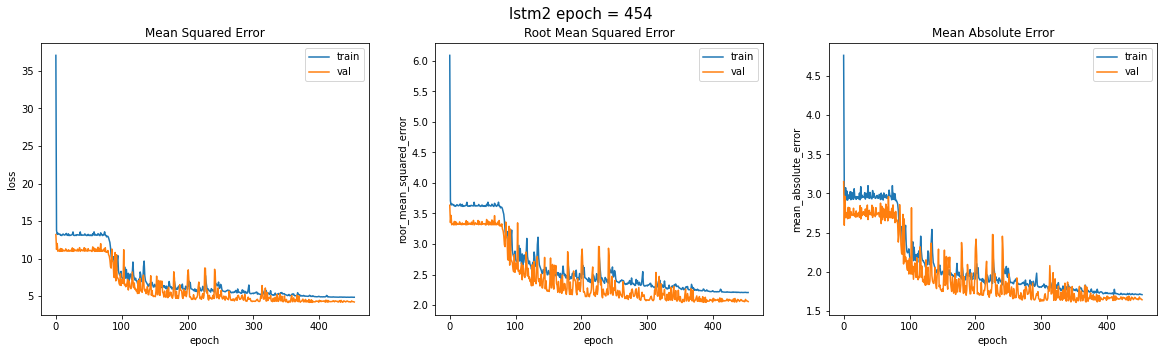

In [69]:
vis_results('lstm2', history_lstm2, epochs_lstm2)

In [70]:
results.update({'lstm2': eval_lstm2[1:]})

### blstm1

In [71]:
eval_blstm1, history_blstm1, epochs_blstm1 = model_history(blstm1, '/tmp/blstm1.h5', 0.01)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              138400    
 l)                                                              
                                                                 
 dense_23 (Dense)            (None, 1)                 201       
                                                                 
Total params: 138,601
Trainable params: 138,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
 9/10 [==========================>...] - ETA: 0s - loss: 31.2923 - mean_squared_error: 31.2923 - rmse: 5.5940 - mean_absolute_error: 4.3074
Epoch 00001: val_loss improved from inf to 10.93978, saving model to /tmp/blstm1.h5
10/10 [======

Epoch 16/1000
 9/10 [==========================>...] - ETA: 0s - loss: 10.9957 - mean_squared_error: 10.9957 - rmse: 3.3160 - mean_absolute_error: 2.6890
Epoch 00016: val_loss improved from 9.68520 to 9.35636, saving model to /tmp/blstm1.h5
10/10 [==============================] - 2s 195ms/step - loss: 10.9424 - mean_squared_error: 10.9424 - rmse: 3.3079 - mean_absolute_error: 2.6824 - val_loss: 9.3564 - val_mean_squared_error: 9.3564 - val_rmse: 3.0588 - val_mean_absolute_error: 2.4008 - lr: 0.0100
Epoch 17/1000
 9/10 [==========================>...] - ETA: 0s - loss: 11.5157 - mean_squared_error: 11.5157 - rmse: 3.3935 - mean_absolute_error: 2.7087
Epoch 00017: val_loss did not improve from 9.35636
10/10 [==============================] - 2s 168ms/step - loss: 11.4406 - mean_squared_error: 11.4406 - rmse: 3.3824 - mean_absolute_error: 2.6980 - val_loss: 13.7856 - val_mean_squared_error: 13.7856 - val_rmse: 3.7129 - val_mean_absolute_error: 3.2009 - lr: 0.0100
Epoch 18/1000
 9/10 [===

 9/10 [==========================>...] - ETA: 0s - loss: 10.3150 - mean_squared_error: 10.3150 - rmse: 3.2117 - mean_absolute_error: 2.5721
Epoch 00033: val_loss did not improve from 7.45756
10/10 [==============================] - 2s 193ms/step - loss: 10.3179 - mean_squared_error: 10.3179 - rmse: 3.2121 - mean_absolute_error: 2.5760 - val_loss: 8.2656 - val_mean_squared_error: 8.2656 - val_rmse: 2.8750 - val_mean_absolute_error: 2.3036 - lr: 0.0100
Epoch 34/1000
 9/10 [==========================>...] - ETA: 0s - loss: 9.5277 - mean_squared_error: 9.5277 - rmse: 3.0867 - mean_absolute_error: 2.4626 
Epoch 00034: val_loss did not improve from 7.45756
10/10 [==============================] - 2s 174ms/step - loss: 9.6477 - mean_squared_error: 9.6477 - rmse: 3.1061 - mean_absolute_error: 2.4781 - val_loss: 7.9506 - val_mean_squared_error: 7.9506 - val_rmse: 2.8197 - val_mean_absolute_error: 2.1870 - lr: 0.0100
Epoch 35/1000
 9/10 [==========================>...] - ETA: 0s - loss: 9.4618 -

 9/10 [==========================>...] - ETA: 0s - loss: 6.2686 - mean_squared_error: 6.2686 - rmse: 2.5037 - mean_absolute_error: 1.9730
Epoch 00050: val_loss did not improve from 5.66341
10/10 [==============================] - 2s 155ms/step - loss: 6.2680 - mean_squared_error: 6.2680 - rmse: 2.5036 - mean_absolute_error: 1.9755 - val_loss: 6.1738 - val_mean_squared_error: 6.1738 - val_rmse: 2.4847 - val_mean_absolute_error: 1.8669 - lr: 0.0100
Epoch 51/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1089 - mean_squared_error: 6.1089 - rmse: 2.4716 - mean_absolute_error: 1.9635
Epoch 00051: val_loss did not improve from 5.66341
10/10 [==============================] - 2s 157ms/step - loss: 6.0835 - mean_squared_error: 6.0835 - rmse: 2.4665 - mean_absolute_error: 1.9599 - val_loss: 6.0550 - val_mean_squared_error: 6.0550 - val_rmse: 2.4607 - val_mean_absolute_error: 1.8550 - lr: 0.0100
Epoch 52/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.0310 - mean

Epoch 68/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.9849 - mean_squared_error: 4.9849 - rmse: 2.2327 - mean_absolute_error: 1.7311
Epoch 00068: val_loss did not improve from 4.25706
10/10 [==============================] - 2s 154ms/step - loss: 4.9790 - mean_squared_error: 4.9790 - rmse: 2.2314 - mean_absolute_error: 1.7327 - val_loss: 4.7751 - val_mean_squared_error: 4.7751 - val_rmse: 2.1852 - val_mean_absolute_error: 1.6755 - lr: 0.0100
Epoch 69/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.2088 - mean_squared_error: 5.2088 - rmse: 2.2823 - mean_absolute_error: 1.7616
Epoch 00069: val_loss did not improve from 4.25706
10/10 [==============================] - 2s 155ms/step - loss: 5.2214 - mean_squared_error: 5.2214 - rmse: 2.2850 - mean_absolute_error: 1.7651 - val_loss: 6.9685 - val_mean_squared_error: 6.9685 - val_rmse: 2.6398 - val_mean_absolute_error: 2.2375 - lr: 0.0100
Epoch 70/1000
 9/10 [==========================>...] - ETA: 0s - loss:

 9/10 [==========================>...] - ETA: 0s - loss: 4.5245 - mean_squared_error: 4.5245 - rmse: 2.1271 - mean_absolute_error: 1.6651
Epoch 00085: val_loss did not improve from 3.83496
10/10 [==============================] - 2s 160ms/step - loss: 4.5856 - mean_squared_error: 4.5856 - rmse: 2.1414 - mean_absolute_error: 1.6703 - val_loss: 3.9833 - val_mean_squared_error: 3.9833 - val_rmse: 1.9958 - val_mean_absolute_error: 1.5432 - lr: 0.0100
Epoch 86/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.3806 - mean_squared_error: 4.3806 - rmse: 2.0930 - mean_absolute_error: 1.6306
Epoch 00086: val_loss did not improve from 3.83496
10/10 [==============================] - 2s 157ms/step - loss: 4.3891 - mean_squared_error: 4.3891 - rmse: 2.0950 - mean_absolute_error: 1.6340 - val_loss: 3.8624 - val_mean_squared_error: 3.8624 - val_rmse: 1.9653 - val_mean_absolute_error: 1.5581 - lr: 0.0100
Epoch 87/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6890 - mean

Epoch 103/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6206 - mean_squared_error: 4.6206 - rmse: 2.1496 - mean_absolute_error: 1.6613
Epoch 00103: val_loss did not improve from 3.71969
10/10 [==============================] - 2s 157ms/step - loss: 4.6314 - mean_squared_error: 4.6314 - rmse: 2.1521 - mean_absolute_error: 1.6641 - val_loss: 3.9398 - val_mean_squared_error: 3.9398 - val_rmse: 1.9849 - val_mean_absolute_error: 1.5784 - lr: 0.0100
Epoch 104/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6665 - mean_squared_error: 4.6665 - rmse: 2.1602 - mean_absolute_error: 1.6495
Epoch 00104: val_loss did not improve from 3.71969
10/10 [==============================] - 2s 157ms/step - loss: 4.6548 - mean_squared_error: 4.6548 - rmse: 2.1575 - mean_absolute_error: 1.6485 - val_loss: 3.7210 - val_mean_squared_error: 3.7210 - val_rmse: 1.9290 - val_mean_absolute_error: 1.5140 - lr: 0.0100
Epoch 105/1000
 9/10 [==========================>...] - ETA: 0s - lo

 9/10 [==========================>...] - ETA: 0s - loss: 4.3202 - mean_squared_error: 4.3202 - rmse: 2.0785 - mean_absolute_error: 1.5786
Epoch 00120: val_loss did not improve from 3.48413
10/10 [==============================] - 2s 160ms/step - loss: 4.3481 - mean_squared_error: 4.3481 - rmse: 2.0852 - mean_absolute_error: 1.5849 - val_loss: 3.9058 - val_mean_squared_error: 3.9058 - val_rmse: 1.9763 - val_mean_absolute_error: 1.5900 - lr: 0.0100
Epoch 121/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.2690 - mean_squared_error: 4.2690 - rmse: 2.0662 - mean_absolute_error: 1.5863
Epoch 00121: val_loss did not improve from 3.48413
10/10 [==============================] - 2s 161ms/step - loss: 4.2446 - mean_squared_error: 4.2446 - rmse: 2.0602 - mean_absolute_error: 1.5802 - val_loss: 3.5725 - val_mean_squared_error: 3.5725 - val_rmse: 1.8901 - val_mean_absolute_error: 1.4949 - lr: 0.0100
Epoch 122/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.1254 - me

Epoch 138/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.1445 - mean_squared_error: 4.1445 - rmse: 2.0358 - mean_absolute_error: 1.5431
Epoch 00138: val_loss did not improve from 3.39611
10/10 [==============================] - 2s 156ms/step - loss: 4.1541 - mean_squared_error: 4.1541 - rmse: 2.0382 - mean_absolute_error: 1.5468 - val_loss: 5.2980 - val_mean_squared_error: 5.2980 - val_rmse: 2.3017 - val_mean_absolute_error: 1.9254 - lr: 0.0100
Epoch 139/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.3090 - mean_squared_error: 4.3090 - rmse: 2.0758 - mean_absolute_error: 1.6126
Epoch 00139: val_loss did not improve from 3.39611
10/10 [==============================] - 2s 155ms/step - loss: 4.3351 - mean_squared_error: 4.3351 - rmse: 2.0821 - mean_absolute_error: 1.6165 - val_loss: 4.2606 - val_mean_squared_error: 4.2606 - val_rmse: 2.0641 - val_mean_absolute_error: 1.5908 - lr: 0.0100
Epoch 140/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 156/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.5854 - mean_squared_error: 3.5854 - rmse: 1.8935 - mean_absolute_error: 1.4540
Epoch 00156: val_loss did not improve from 3.34698
10/10 [==============================] - 2s 156ms/step - loss: 3.5676 - mean_squared_error: 3.5676 - rmse: 1.8888 - mean_absolute_error: 1.4505 - val_loss: 3.8640 - val_mean_squared_error: 3.8640 - val_rmse: 1.9657 - val_mean_absolute_error: 1.5978 - lr: 0.0100
Epoch 157/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.8573 - mean_squared_error: 3.8573 - rmse: 1.9640 - mean_absolute_error: 1.5295
Epoch 00157: val_loss did not improve from 3.34698
10/10 [==============================] - 2s 156ms/step - loss: 3.8471 - mean_squared_error: 3.8471 - rmse: 1.9614 - mean_absolute_error: 1.5267 - val_loss: 3.9588 - val_mean_squared_error: 3.9588 - val_rmse: 1.9897 - val_mean_absolute_error: 1.5266 - lr: 0.0100
Epoch 158/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 174/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.3962 - mean_squared_error: 3.3962 - rmse: 1.8429 - mean_absolute_error: 1.4434
Epoch 00174: val_loss did not improve from 3.28856
10/10 [==============================] - 2s 158ms/step - loss: 3.4221 - mean_squared_error: 3.4221 - rmse: 1.8499 - mean_absolute_error: 1.4459 - val_loss: 3.5674 - val_mean_squared_error: 3.5674 - val_rmse: 1.8888 - val_mean_absolute_error: 1.5346 - lr: 0.0100
Epoch 175/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.4009 - mean_squared_error: 3.4009 - rmse: 1.8442 - mean_absolute_error: 1.4373
Epoch 00175: val_loss did not improve from 3.28856
10/10 [==============================] - 2s 157ms/step - loss: 3.3898 - mean_squared_error: 3.3898 - rmse: 1.8411 - mean_absolute_error: 1.4359 - val_loss: 3.3957 - val_mean_squared_error: 3.3957 - val_rmse: 1.8427 - val_mean_absolute_error: 1.4490 - lr: 0.0100
Epoch 176/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 192/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.0221 - mean_squared_error: 3.0221 - rmse: 1.7384 - mean_absolute_error: 1.3605
Epoch 00192: val_loss did not improve from 3.28498
10/10 [==============================] - 2s 158ms/step - loss: 3.0188 - mean_squared_error: 3.0188 - rmse: 1.7375 - mean_absolute_error: 1.3594 - val_loss: 3.2884 - val_mean_squared_error: 3.2884 - val_rmse: 1.8134 - val_mean_absolute_error: 1.4246 - lr: 0.0050
Epoch 193/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.0354 - mean_squared_error: 3.0354 - rmse: 1.7422 - mean_absolute_error: 1.3497
Epoch 00193: val_loss did not improve from 3.28498
10/10 [==============================] - 2s 157ms/step - loss: 3.0274 - mean_squared_error: 3.0274 - rmse: 1.7399 - mean_absolute_error: 1.3479 - val_loss: 3.3719 - val_mean_squared_error: 3.3719 - val_rmse: 1.8363 - val_mean_absolute_error: 1.4646 - lr: 0.0050
Epoch 194/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 210/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.9522 - mean_squared_error: 2.9522 - rmse: 1.7182 - mean_absolute_error: 1.3374
Epoch 00210: val_loss did not improve from 3.24552
10/10 [==============================] - 2s 160ms/step - loss: 2.9485 - mean_squared_error: 2.9485 - rmse: 1.7171 - mean_absolute_error: 1.3344 - val_loss: 3.3698 - val_mean_squared_error: 3.3698 - val_rmse: 1.8357 - val_mean_absolute_error: 1.4630 - lr: 0.0050
Epoch 211/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.8496 - mean_squared_error: 2.8496 - rmse: 1.6881 - mean_absolute_error: 1.3175
Epoch 00211: val_loss did not improve from 3.24552
10/10 [==============================] - 2s 161ms/step - loss: 2.8585 - mean_squared_error: 2.8585 - rmse: 1.6907 - mean_absolute_error: 1.3200 - val_loss: 3.3048 - val_mean_squared_error: 3.3048 - val_rmse: 1.8179 - val_mean_absolute_error: 1.4390 - lr: 0.0050
Epoch 212/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 228/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.8052 - mean_squared_error: 2.8052 - rmse: 1.6749 - mean_absolute_error: 1.3018
Epoch 00228: val_loss did not improve from 3.24552
10/10 [==============================] - 2s 159ms/step - loss: 2.7957 - mean_squared_error: 2.7957 - rmse: 1.6720 - mean_absolute_error: 1.2998 - val_loss: 3.3423 - val_mean_squared_error: 3.3423 - val_rmse: 1.8282 - val_mean_absolute_error: 1.4570 - lr: 0.0025
Epoch 229/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.7548 - mean_squared_error: 2.7548 - rmse: 1.6598 - mean_absolute_error: 1.2878
Epoch 00229: val_loss did not improve from 3.24552
10/10 [==============================] - 2s 159ms/step - loss: 2.7495 - mean_squared_error: 2.7495 - rmse: 1.6582 - mean_absolute_error: 1.2872 - val_loss: 3.3023 - val_mean_squared_error: 3.3023 - val_rmse: 1.8172 - val_mean_absolute_error: 1.4445 - lr: 0.0025
Epoch 230/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 246/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.6999 - mean_squared_error: 2.6999 - rmse: 1.6431 - mean_absolute_error: 1.2776
Epoch 00246: val_loss did not improve from 3.24552
10/10 [==============================] - 2s 158ms/step - loss: 2.6911 - mean_squared_error: 2.6911 - rmse: 1.6404 - mean_absolute_error: 1.2770 - val_loss: 3.3525 - val_mean_squared_error: 3.3525 - val_rmse: 1.8310 - val_mean_absolute_error: 1.4552 - lr: 0.0012
Epoch 247/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.6550 - mean_squared_error: 2.6550 - rmse: 1.6294 - mean_absolute_error: 1.2612
Epoch 00247: val_loss did not improve from 3.24552
10/10 [==============================] - 2s 160ms/step - loss: 2.6630 - mean_squared_error: 2.6630 - rmse: 1.6319 - mean_absolute_error: 1.2622 - val_loss: 3.4077 - val_mean_squared_error: 3.4077 - val_rmse: 1.8460 - val_mean_absolute_error: 1.4644 - lr: 0.0012
Epoch 248/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 264/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.6604 - mean_squared_error: 2.6604 - rmse: 1.6311 - mean_absolute_error: 1.2676
Epoch 00264: val_loss did not improve from 3.24552
10/10 [==============================] - 2s 157ms/step - loss: 2.6524 - mean_squared_error: 2.6524 - rmse: 1.6286 - mean_absolute_error: 1.2647 - val_loss: 3.3610 - val_mean_squared_error: 3.3610 - val_rmse: 1.8333 - val_mean_absolute_error: 1.4490 - lr: 6.2500e-04
Epoch 265/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.5976 - mean_squared_error: 2.5976 - rmse: 1.6117 - mean_absolute_error: 1.2441
Epoch 00265: val_loss did not improve from 3.24552
10/10 [==============================] - 2s 157ms/step - loss: 2.6180 - mean_squared_error: 2.6180 - rmse: 1.6180 - mean_absolute_error: 1.2487 - val_loss: 3.3898 - val_mean_squared_error: 3.3898 - val_rmse: 1.8411 - val_mean_absolute_error: 1.4493 - lr: 6.2500e-04
Epoch 266/1000
 9/10 [==========================>...] - ETA:

Epoch 282/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.5943 - mean_squared_error: 2.5943 - rmse: 1.6107 - mean_absolute_error: 1.2463
Epoch 00282: val_loss did not improve from 3.24552
10/10 [==============================] - 2s 158ms/step - loss: 2.6179 - mean_squared_error: 2.6179 - rmse: 1.6180 - mean_absolute_error: 1.2525 - val_loss: 3.4785 - val_mean_squared_error: 3.4785 - val_rmse: 1.8651 - val_mean_absolute_error: 1.4753 - lr: 3.1250e-04
Epoch 283/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.6003 - mean_squared_error: 2.6003 - rmse: 1.6126 - mean_absolute_error: 1.2411
Epoch 00283: val_loss did not improve from 3.24552
10/10 [==============================] - 2s 158ms/step - loss: 2.5948 - mean_squared_error: 2.5948 - rmse: 1.6108 - mean_absolute_error: 1.2400 - val_loss: 3.3751 - val_mean_squared_error: 3.3751 - val_rmse: 1.8371 - val_mean_absolute_error: 1.4452 - lr: 3.1250e-04
Epoch 284/1000
 9/10 [==========================>...] - ETA:

Epoch 300/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.5812 - mean_squared_error: 2.5812 - rmse: 1.6066 - mean_absolute_error: 1.2364
Epoch 00300: val_loss did not improve from 3.24552
10/10 [==============================] - 2s 169ms/step - loss: 2.5853 - mean_squared_error: 2.5853 - rmse: 1.6079 - mean_absolute_error: 1.2368 - val_loss: 3.3889 - val_mean_squared_error: 3.3889 - val_rmse: 1.8409 - val_mean_absolute_error: 1.4446 - lr: 3.1250e-04
Epoch 301/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.5987 - mean_squared_error: 2.5987 - rmse: 1.6121 - mean_absolute_error: 1.2434
Epoch 00301: val_loss did not improve from 3.24552

Epoch 00301: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
12/12 [==============================] - 0s 15ms/step - loss: 4.3314 - mean_squared_error: 4.3314 - rmse: 2.0812 - mean_absolute_error: 1.5984


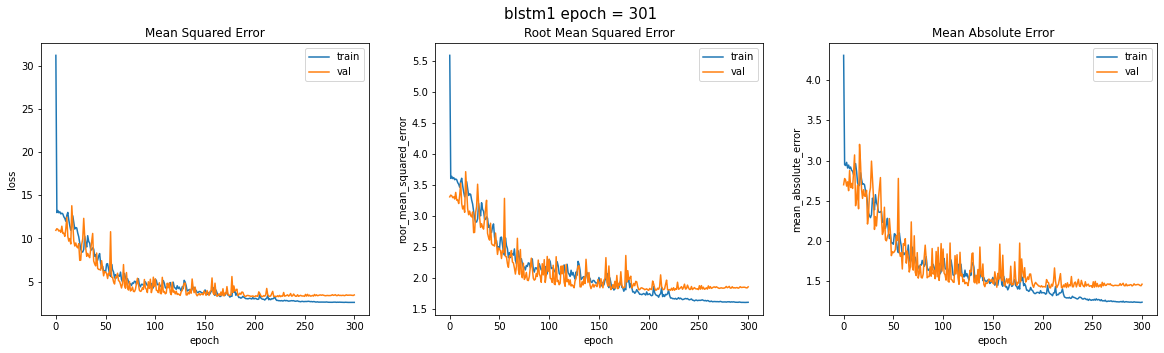

In [72]:
vis_results('blstm1', history_blstm1, epochs_blstm1)

In [73]:
results.update({'blstm1': eval_blstm1[1:]})

### blstm2

In [74]:
eval_blstm2, history_blstm2, epochs_blstm2 = model_history(blstm2, '/tmp/blstm2.h5', 0.01)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 72)]         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 200)         138400    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_24 (Dense)            (None, 1)                 201       
                                                                 
Total params: 379,401
Trainable params: 379,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] 

Epoch 16/1000
10/10 [==============================] - ETA: 0s - loss: 11.8235 - mean_squared_error: 11.8235 - rmse: 3.4385 - mean_absolute_error: 2.7477
Epoch 00016: val_loss did not improve from 9.72849
10/10 [==============================] - 4s 421ms/step - loss: 11.8235 - mean_squared_error: 11.8235 - rmse: 3.4385 - mean_absolute_error: 2.7477 - val_loss: 13.9954 - val_mean_squared_error: 13.9954 - val_rmse: 3.7410 - val_mean_absolute_error: 3.2636 - lr: 0.0100
Epoch 17/1000
10/10 [==============================] - ETA: 0s - loss: 12.4954 - mean_squared_error: 12.4954 - rmse: 3.5349 - mean_absolute_error: 2.9111
Epoch 00017: val_loss improved from 9.72849 to 9.45484, saving model to /tmp/blstm2.h5
10/10 [==============================] - 4s 436ms/step - loss: 12.4954 - mean_squared_error: 12.4954 - rmse: 3.5349 - mean_absolute_error: 2.9111 - val_loss: 9.4548 - val_mean_squared_error: 9.4548 - val_rmse: 3.0749 - val_mean_absolute_error: 2.5995 - lr: 0.0100
Epoch 18/1000
10/10 [===

10/10 [==============================] - ETA: 0s - loss: 8.3106 - mean_squared_error: 8.3106 - rmse: 2.8828 - mean_absolute_error: 2.2751
Epoch 00033: val_loss improved from 7.19331 to 6.67349, saving model to /tmp/blstm2.h5
10/10 [==============================] - 5s 519ms/step - loss: 8.3106 - mean_squared_error: 8.3106 - rmse: 2.8828 - mean_absolute_error: 2.2751 - val_loss: 6.6735 - val_mean_squared_error: 6.6735 - val_rmse: 2.5833 - val_mean_absolute_error: 2.0746 - lr: 0.0100
Epoch 34/1000
10/10 [==============================] - ETA: 0s - loss: 7.9317 - mean_squared_error: 7.9317 - rmse: 2.8163 - mean_absolute_error: 2.2254
Epoch 00034: val_loss did not improve from 6.67349
10/10 [==============================] - 5s 514ms/step - loss: 7.9317 - mean_squared_error: 7.9317 - rmse: 2.8163 - mean_absolute_error: 2.2254 - val_loss: 7.2148 - val_mean_squared_error: 7.2148 - val_rmse: 2.6860 - val_mean_absolute_error: 2.0752 - lr: 0.0100
Epoch 35/1000
10/10 [===========================

10/10 [==============================] - ETA: 0s - loss: 6.9468 - mean_squared_error: 6.9468 - rmse: 2.6357 - mean_absolute_error: 2.0598
Epoch 00050: val_loss did not improve from 6.01893
10/10 [==============================] - 5s 466ms/step - loss: 6.9468 - mean_squared_error: 6.9468 - rmse: 2.6357 - mean_absolute_error: 2.0598 - val_loss: 6.2885 - val_mean_squared_error: 6.2885 - val_rmse: 2.5077 - val_mean_absolute_error: 2.0905 - lr: 0.0100
Epoch 51/1000
10/10 [==============================] - ETA: 0s - loss: 7.0103 - mean_squared_error: 7.0103 - rmse: 2.6477 - mean_absolute_error: 2.0733
Epoch 00051: val_loss did not improve from 6.01893
10/10 [==============================] - 5s 464ms/step - loss: 7.0103 - mean_squared_error: 7.0103 - rmse: 2.6477 - mean_absolute_error: 2.0733 - val_loss: 9.0282 - val_mean_squared_error: 9.0282 - val_rmse: 3.0047 - val_mean_absolute_error: 2.4934 - lr: 0.0100
Epoch 52/1000
10/10 [==============================] - ETA: 0s - loss: 7.1688 - mean

Epoch 68/1000
10/10 [==============================] - ETA: 0s - loss: 6.5475 - mean_squared_error: 6.5475 - rmse: 2.5588 - mean_absolute_error: 1.9998
Epoch 00068: val_loss improved from 5.68861 to 5.55442, saving model to /tmp/blstm2.h5
10/10 [==============================] - 4s 427ms/step - loss: 6.5475 - mean_squared_error: 6.5475 - rmse: 2.5588 - mean_absolute_error: 1.9998 - val_loss: 5.5544 - val_mean_squared_error: 5.5544 - val_rmse: 2.3568 - val_mean_absolute_error: 1.9134 - lr: 0.0100
Epoch 69/1000
10/10 [==============================] - ETA: 0s - loss: 6.6814 - mean_squared_error: 6.6814 - rmse: 2.5848 - mean_absolute_error: 2.0312
Epoch 00069: val_loss did not improve from 5.55442
10/10 [==============================] - 4s 447ms/step - loss: 6.6814 - mean_squared_error: 6.6814 - rmse: 2.5848 - mean_absolute_error: 2.0312 - val_loss: 5.6600 - val_mean_squared_error: 5.6600 - val_rmse: 2.3791 - val_mean_absolute_error: 1.8874 - lr: 0.0100
Epoch 70/1000
10/10 [=============

10/10 [==============================] - ETA: 0s - loss: 5.7653 - mean_squared_error: 5.7653 - rmse: 2.4011 - mean_absolute_error: 1.8805
Epoch 00085: val_loss improved from 5.10757 to 4.98638, saving model to /tmp/blstm2.h5
10/10 [==============================] - 5s 449ms/step - loss: 5.7653 - mean_squared_error: 5.7653 - rmse: 2.4011 - mean_absolute_error: 1.8805 - val_loss: 4.9864 - val_mean_squared_error: 4.9864 - val_rmse: 2.2330 - val_mean_absolute_error: 1.7835 - lr: 0.0100
Epoch 86/1000
10/10 [==============================] - ETA: 0s - loss: 5.6580 - mean_squared_error: 5.6580 - rmse: 2.3787 - mean_absolute_error: 1.8526
Epoch 00086: val_loss did not improve from 4.98638
10/10 [==============================] - 4s 435ms/step - loss: 5.6580 - mean_squared_error: 5.6580 - rmse: 2.3787 - mean_absolute_error: 1.8526 - val_loss: 5.2784 - val_mean_squared_error: 5.2784 - val_rmse: 2.2975 - val_mean_absolute_error: 1.8726 - lr: 0.0100
Epoch 87/1000
10/10 [===========================

Epoch 103/1000
10/10 [==============================] - ETA: 0s - loss: 6.5235 - mean_squared_error: 6.5235 - rmse: 2.5541 - mean_absolute_error: 2.0135
Epoch 00103: val_loss did not improve from 4.49213
10/10 [==============================] - 4s 441ms/step - loss: 6.5235 - mean_squared_error: 6.5235 - rmse: 2.5541 - mean_absolute_error: 2.0135 - val_loss: 5.4144 - val_mean_squared_error: 5.4144 - val_rmse: 2.3269 - val_mean_absolute_error: 1.7931 - lr: 0.0100
Epoch 104/1000
10/10 [==============================] - ETA: 0s - loss: 6.4005 - mean_squared_error: 6.4005 - rmse: 2.5299 - mean_absolute_error: 1.9884
Epoch 00104: val_loss did not improve from 4.49213
10/10 [==============================] - 4s 422ms/step - loss: 6.4005 - mean_squared_error: 6.4005 - rmse: 2.5299 - mean_absolute_error: 1.9884 - val_loss: 8.0671 - val_mean_squared_error: 8.0671 - val_rmse: 2.8403 - val_mean_absolute_error: 2.3780 - lr: 0.0100
Epoch 105/1000
10/10 [==============================] - ETA: 0s - lo

10/10 [==============================] - ETA: 0s - loss: 4.6237 - mean_squared_error: 4.6237 - rmse: 2.1503 - mean_absolute_error: 1.6643
Epoch 00120: val_loss improved from 3.82839 to 3.78283, saving model to /tmp/blstm2.h5
10/10 [==============================] - 4s 426ms/step - loss: 4.6237 - mean_squared_error: 4.6237 - rmse: 2.1503 - mean_absolute_error: 1.6643 - val_loss: 3.7828 - val_mean_squared_error: 3.7828 - val_rmse: 1.9449 - val_mean_absolute_error: 1.5731 - lr: 0.0050
Epoch 121/1000
10/10 [==============================] - ETA: 0s - loss: 4.8769 - mean_squared_error: 4.8769 - rmse: 2.2084 - mean_absolute_error: 1.7108
Epoch 00121: val_loss did not improve from 3.78283
10/10 [==============================] - 4s 420ms/step - loss: 4.8769 - mean_squared_error: 4.8769 - rmse: 2.2084 - mean_absolute_error: 1.7108 - val_loss: 4.5254 - val_mean_squared_error: 4.5254 - val_rmse: 2.1273 - val_mean_absolute_error: 1.7409 - lr: 0.0050
Epoch 122/1000
10/10 [=========================

10/10 [==============================] - ETA: 0s - loss: 4.4489 - mean_squared_error: 4.4489 - rmse: 2.1092 - mean_absolute_error: 1.6291
Epoch 00137: val_loss did not improve from 3.49664
10/10 [==============================] - 5s 488ms/step - loss: 4.4489 - mean_squared_error: 4.4489 - rmse: 2.1092 - mean_absolute_error: 1.6291 - val_loss: 3.5164 - val_mean_squared_error: 3.5164 - val_rmse: 1.8752 - val_mean_absolute_error: 1.4984 - lr: 0.0050
Epoch 138/1000
10/10 [==============================] - ETA: 0s - loss: 4.0984 - mean_squared_error: 4.0984 - rmse: 2.0245 - mean_absolute_error: 1.5626
Epoch 00138: val_loss did not improve from 3.49664
10/10 [==============================] - 4s 444ms/step - loss: 4.0984 - mean_squared_error: 4.0984 - rmse: 2.0245 - mean_absolute_error: 1.5626 - val_loss: 3.5817 - val_mean_squared_error: 3.5817 - val_rmse: 1.8925 - val_mean_absolute_error: 1.4476 - lr: 0.0050
Epoch 139/1000
10/10 [==============================] - ETA: 0s - loss: 4.6376 - me

Epoch 155/1000
10/10 [==============================] - ETA: 0s - loss: 4.0149 - mean_squared_error: 4.0149 - rmse: 2.0037 - mean_absolute_error: 1.5487
Epoch 00155: val_loss did not improve from 3.32867
10/10 [==============================] - 4s 423ms/step - loss: 4.0149 - mean_squared_error: 4.0149 - rmse: 2.0037 - mean_absolute_error: 1.5487 - val_loss: 4.2698 - val_mean_squared_error: 4.2698 - val_rmse: 2.0664 - val_mean_absolute_error: 1.6933 - lr: 0.0050
Epoch 156/1000
10/10 [==============================] - ETA: 0s - loss: 4.4109 - mean_squared_error: 4.4109 - rmse: 2.1002 - mean_absolute_error: 1.6325
Epoch 00156: val_loss did not improve from 3.32867
10/10 [==============================] - 4s 430ms/step - loss: 4.4109 - mean_squared_error: 4.4109 - rmse: 2.1002 - mean_absolute_error: 1.6325 - val_loss: 3.4320 - val_mean_squared_error: 3.4320 - val_rmse: 1.8526 - val_mean_absolute_error: 1.4108 - lr: 0.0050
Epoch 157/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 173/1000
10/10 [==============================] - ETA: 0s - loss: 3.8849 - mean_squared_error: 3.8849 - rmse: 1.9710 - mean_absolute_error: 1.5269
Epoch 00173: val_loss did not improve from 3.23927
10/10 [==============================] - 5s 532ms/step - loss: 3.8849 - mean_squared_error: 3.8849 - rmse: 1.9710 - mean_absolute_error: 1.5269 - val_loss: 4.6928 - val_mean_squared_error: 4.6928 - val_rmse: 2.1663 - val_mean_absolute_error: 1.7897 - lr: 0.0050
Epoch 174/1000
10/10 [==============================] - ETA: 0s - loss: 4.2450 - mean_squared_error: 4.2450 - rmse: 2.0603 - mean_absolute_error: 1.6003
Epoch 00174: val_loss did not improve from 3.23927
10/10 [==============================] - 5s 486ms/step - loss: 4.2450 - mean_squared_error: 4.2450 - rmse: 2.0603 - mean_absolute_error: 1.6003 - val_loss: 3.3028 - val_mean_squared_error: 3.3028 - val_rmse: 1.8174 - val_mean_absolute_error: 1.3998 - lr: 0.0050
Epoch 175/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 191/1000
10/10 [==============================] - ETA: 0s - loss: 3.5160 - mean_squared_error: 3.5160 - rmse: 1.8751 - mean_absolute_error: 1.4575
Epoch 00191: val_loss did not improve from 3.19449
10/10 [==============================] - 4s 429ms/step - loss: 3.5160 - mean_squared_error: 3.5160 - rmse: 1.8751 - mean_absolute_error: 1.4575 - val_loss: 3.1985 - val_mean_squared_error: 3.1985 - val_rmse: 1.7884 - val_mean_absolute_error: 1.4051 - lr: 0.0050
Epoch 192/1000
10/10 [==============================] - ETA: 0s - loss: 3.4524 - mean_squared_error: 3.4524 - rmse: 1.8581 - mean_absolute_error: 1.4456
Epoch 00192: val_loss improved from 3.19449 to 3.10644, saving model to /tmp/blstm2.h5
10/10 [==============================] - 4s 436ms/step - loss: 3.4524 - mean_squared_error: 3.4524 - rmse: 1.8581 - mean_absolute_error: 1.4456 - val_loss: 3.1064 - val_mean_squared_error: 3.1064 - val_rmse: 1.7625 - val_mean_absolute_error: 1.3747 - lr: 0.0050
Epoch 193/1000
10/10 [==========

Epoch 209/1000
10/10 [==============================] - ETA: 0s - loss: 3.6925 - mean_squared_error: 3.6925 - rmse: 1.9216 - mean_absolute_error: 1.4790
Epoch 00209: val_loss improved from 3.10644 to 3.09543, saving model to /tmp/blstm2.h5
10/10 [==============================] - 4s 421ms/step - loss: 3.6925 - mean_squared_error: 3.6925 - rmse: 1.9216 - mean_absolute_error: 1.4790 - val_loss: 3.0954 - val_mean_squared_error: 3.0954 - val_rmse: 1.7594 - val_mean_absolute_error: 1.3841 - lr: 0.0050
Epoch 210/1000
10/10 [==============================] - ETA: 0s - loss: 3.4446 - mean_squared_error: 3.4446 - rmse: 1.8560 - mean_absolute_error: 1.4448
Epoch 00210: val_loss did not improve from 3.09543
10/10 [==============================] - 4s 423ms/step - loss: 3.4446 - mean_squared_error: 3.4446 - rmse: 1.8560 - mean_absolute_error: 1.4448 - val_loss: 3.3136 - val_mean_squared_error: 3.3136 - val_rmse: 1.8203 - val_mean_absolute_error: 1.3917 - lr: 0.0050
Epoch 211/1000
10/10 [==========

Epoch 227/1000
10/10 [==============================] - ETA: 0s - loss: 3.2520 - mean_squared_error: 3.2520 - rmse: 1.8033 - mean_absolute_error: 1.4018
Epoch 00227: val_loss improved from 3.09543 to 3.04415, saving model to /tmp/blstm2.h5
10/10 [==============================] - 4s 423ms/step - loss: 3.2520 - mean_squared_error: 3.2520 - rmse: 1.8033 - mean_absolute_error: 1.4018 - val_loss: 3.0442 - val_mean_squared_error: 3.0442 - val_rmse: 1.7447 - val_mean_absolute_error: 1.3506 - lr: 0.0050
Epoch 228/1000
10/10 [==============================] - ETA: 0s - loss: 3.3462 - mean_squared_error: 3.3462 - rmse: 1.8293 - mean_absolute_error: 1.4382
Epoch 00228: val_loss did not improve from 3.04415
10/10 [==============================] - 4s 422ms/step - loss: 3.3462 - mean_squared_error: 3.3462 - rmse: 1.8293 - mean_absolute_error: 1.4382 - val_loss: 3.2041 - val_mean_squared_error: 3.2041 - val_rmse: 1.7900 - val_mean_absolute_error: 1.3975 - lr: 0.0050
Epoch 229/1000
10/10 [==========

Epoch 245/1000
10/10 [==============================] - ETA: 0s - loss: 3.1016 - mean_squared_error: 3.1016 - rmse: 1.7611 - mean_absolute_error: 1.3704
Epoch 00245: val_loss did not improve from 3.00439
10/10 [==============================] - 4s 426ms/step - loss: 3.1016 - mean_squared_error: 3.1016 - rmse: 1.7611 - mean_absolute_error: 1.3704 - val_loss: 3.7580 - val_mean_squared_error: 3.7580 - val_rmse: 1.9386 - val_mean_absolute_error: 1.5610 - lr: 0.0050
Epoch 246/1000
10/10 [==============================] - ETA: 0s - loss: 3.4754 - mean_squared_error: 3.4754 - rmse: 1.8642 - mean_absolute_error: 1.4550
Epoch 00246: val_loss did not improve from 3.00439
10/10 [==============================] - 4s 419ms/step - loss: 3.4754 - mean_squared_error: 3.4754 - rmse: 1.8642 - mean_absolute_error: 1.4550 - val_loss: 3.3252 - val_mean_squared_error: 3.3252 - val_rmse: 1.8235 - val_mean_absolute_error: 1.3991 - lr: 0.0050
Epoch 247/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 263/1000
10/10 [==============================] - ETA: 0s - loss: 3.1991 - mean_squared_error: 3.1991 - rmse: 1.7886 - mean_absolute_error: 1.3999
Epoch 00263: val_loss improved from 3.00439 to 2.96533, saving model to /tmp/blstm2.h5
10/10 [==============================] - 4s 410ms/step - loss: 3.1991 - mean_squared_error: 3.1991 - rmse: 1.7886 - mean_absolute_error: 1.3999 - val_loss: 2.9653 - val_mean_squared_error: 2.9653 - val_rmse: 1.7220 - val_mean_absolute_error: 1.3570 - lr: 0.0050
Epoch 264/1000
10/10 [==============================] - ETA: 0s - loss: 3.0813 - mean_squared_error: 3.0813 - rmse: 1.7554 - mean_absolute_error: 1.3509
Epoch 00264: val_loss did not improve from 2.96533
10/10 [==============================] - 4s 408ms/step - loss: 3.0813 - mean_squared_error: 3.0813 - rmse: 1.7554 - mean_absolute_error: 1.3509 - val_loss: 3.9656 - val_mean_squared_error: 3.9656 - val_rmse: 1.9914 - val_mean_absolute_error: 1.6167 - lr: 0.0050
Epoch 265/1000
10/10 [==========

Epoch 281/1000
10/10 [==============================] - ETA: 0s - loss: 3.2170 - mean_squared_error: 3.2170 - rmse: 1.7936 - mean_absolute_error: 1.3856
Epoch 00281: val_loss did not improve from 2.87376
10/10 [==============================] - 4s 427ms/step - loss: 3.2170 - mean_squared_error: 3.2170 - rmse: 1.7936 - mean_absolute_error: 1.3856 - val_loss: 3.6891 - val_mean_squared_error: 3.6891 - val_rmse: 1.9207 - val_mean_absolute_error: 1.5591 - lr: 0.0050
Epoch 282/1000
10/10 [==============================] - ETA: 0s - loss: 3.3008 - mean_squared_error: 3.3008 - rmse: 1.8168 - mean_absolute_error: 1.4119
Epoch 00282: val_loss did not improve from 2.87376
10/10 [==============================] - 4s 433ms/step - loss: 3.3008 - mean_squared_error: 3.3008 - rmse: 1.8168 - mean_absolute_error: 1.4119 - val_loss: 3.1635 - val_mean_squared_error: 3.1635 - val_rmse: 1.7786 - val_mean_absolute_error: 1.3608 - lr: 0.0050
Epoch 283/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 299/1000
10/10 [==============================] - ETA: 0s - loss: 3.3733 - mean_squared_error: 3.3733 - rmse: 1.8366 - mean_absolute_error: 1.4202
Epoch 00299: val_loss did not improve from 2.87376

Epoch 00299: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
10/10 [==============================] - 4s 423ms/step - loss: 3.3733 - mean_squared_error: 3.3733 - rmse: 1.8366 - mean_absolute_error: 1.4202 - val_loss: 4.6562 - val_mean_squared_error: 4.6562 - val_rmse: 2.1578 - val_mean_absolute_error: 1.7802 - lr: 0.0050
Epoch 300/1000
10/10 [==============================] - ETA: 0s - loss: 3.3083 - mean_squared_error: 3.3083 - rmse: 1.8189 - mean_absolute_error: 1.4076
Epoch 00300: val_loss did not improve from 2.87376
10/10 [==============================] - 4s 423ms/step - loss: 3.3083 - mean_squared_error: 3.3083 - rmse: 1.8189 - mean_absolute_error: 1.4076 - val_loss: 3.0817 - val_mean_squared_error: 3.0817 - val_rmse: 1.7555 - val_mean_absolute_error: 1.4054 

Epoch 317/1000
10/10 [==============================] - ETA: 0s - loss: 4.4918 - mean_squared_error: 4.4918 - rmse: 2.1194 - mean_absolute_error: 1.6635
Epoch 00317: val_loss did not improve from 2.87376
10/10 [==============================] - 4s 432ms/step - loss: 4.4918 - mean_squared_error: 4.4918 - rmse: 2.1194 - mean_absolute_error: 1.6635 - val_loss: 4.3151 - val_mean_squared_error: 4.3151 - val_rmse: 2.0773 - val_mean_absolute_error: 1.7129 - lr: 0.0025
Epoch 318/1000
10/10 [==============================] - ETA: 0s - loss: 4.2211 - mean_squared_error: 4.2211 - rmse: 2.0545 - mean_absolute_error: 1.6080
Epoch 00318: val_loss did not improve from 2.87376
10/10 [==============================] - 4s 445ms/step - loss: 4.2211 - mean_squared_error: 4.2211 - rmse: 2.0545 - mean_absolute_error: 1.6080 - val_loss: 3.5829 - val_mean_squared_error: 3.5829 - val_rmse: 1.8929 - val_mean_absolute_error: 1.5194 - lr: 0.0025
Epoch 319/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 335/1000
10/10 [==============================] - ETA: 0s - loss: 3.0024 - mean_squared_error: 3.0024 - rmse: 1.7328 - mean_absolute_error: 1.3406
Epoch 00335: val_loss did not improve from 2.87376
10/10 [==============================] - 4s 427ms/step - loss: 3.0024 - mean_squared_error: 3.0024 - rmse: 1.7328 - mean_absolute_error: 1.3406 - val_loss: 2.9769 - val_mean_squared_error: 2.9769 - val_rmse: 1.7254 - val_mean_absolute_error: 1.3649 - lr: 0.0012
Epoch 336/1000
10/10 [==============================] - ETA: 0s - loss: 2.9424 - mean_squared_error: 2.9424 - rmse: 1.7153 - mean_absolute_error: 1.3294
Epoch 00336: val_loss did not improve from 2.87376
10/10 [==============================] - 4s 414ms/step - loss: 2.9424 - mean_squared_error: 2.9424 - rmse: 1.7153 - mean_absolute_error: 1.3294 - val_loss: 2.9758 - val_mean_squared_error: 2.9758 - val_rmse: 1.7250 - val_mean_absolute_error: 1.3630 - lr: 0.0012
Epoch 337/1000
10/10 [==============================] - ETA: 0s - lo

10/10 [==============================] - ETA: 0s - loss: 2.7107 - mean_squared_error: 2.7107 - rmse: 1.6464 - mean_absolute_error: 1.2820
Epoch 00352: val_loss did not improve from 2.86328
10/10 [==============================] - 4s 430ms/step - loss: 2.7107 - mean_squared_error: 2.7107 - rmse: 1.6464 - mean_absolute_error: 1.2820 - val_loss: 2.9077 - val_mean_squared_error: 2.9077 - val_rmse: 1.7052 - val_mean_absolute_error: 1.3518 - lr: 6.2500e-04
Epoch 353/1000
10/10 [==============================] - ETA: 0s - loss: 2.7268 - mean_squared_error: 2.7268 - rmse: 1.6513 - mean_absolute_error: 1.2760
Epoch 00353: val_loss did not improve from 2.86328
10/10 [==============================] - 4s 412ms/step - loss: 2.7268 - mean_squared_error: 2.7268 - rmse: 1.6513 - mean_absolute_error: 1.2760 - val_loss: 3.0508 - val_mean_squared_error: 3.0508 - val_rmse: 1.7467 - val_mean_absolute_error: 1.3914 - lr: 6.2500e-04
Epoch 354/1000
10/10 [==============================] - ETA: 0s - loss: 2.6

10/10 [==============================] - ETA: 0s - loss: 2.6372 - mean_squared_error: 2.6372 - rmse: 1.6239 - mean_absolute_error: 1.2529
Epoch 00369: val_loss did not improve from 2.86328
10/10 [==============================] - 4s 430ms/step - loss: 2.6372 - mean_squared_error: 2.6372 - rmse: 1.6239 - mean_absolute_error: 1.2529 - val_loss: 3.0031 - val_mean_squared_error: 3.0031 - val_rmse: 1.7329 - val_mean_absolute_error: 1.3824 - lr: 3.1250e-04
Epoch 370/1000
10/10 [==============================] - ETA: 0s - loss: 2.6288 - mean_squared_error: 2.6288 - rmse: 1.6214 - mean_absolute_error: 1.2583
Epoch 00370: val_loss did not improve from 2.86328
10/10 [==============================] - 4s 423ms/step - loss: 2.6288 - mean_squared_error: 2.6288 - rmse: 1.6214 - mean_absolute_error: 1.2583 - val_loss: 2.9455 - val_mean_squared_error: 2.9455 - val_rmse: 1.7163 - val_mean_absolute_error: 1.3592 - lr: 3.1250e-04
Epoch 371/1000
10/10 [==============================] - ETA: 0s - loss: 2.6

Epoch 387/1000
10/10 [==============================] - ETA: 0s - loss: 2.6073 - mean_squared_error: 2.6073 - rmse: 1.6147 - mean_absolute_error: 1.2525
Epoch 00387: val_loss did not improve from 2.86328
10/10 [==============================] - 4s 425ms/step - loss: 2.6073 - mean_squared_error: 2.6073 - rmse: 1.6147 - mean_absolute_error: 1.2525 - val_loss: 3.0073 - val_mean_squared_error: 3.0073 - val_rmse: 1.7341 - val_mean_absolute_error: 1.3658 - lr: 3.1250e-04
Epoch 388/1000
10/10 [==============================] - ETA: 0s - loss: 2.5931 - mean_squared_error: 2.5931 - rmse: 1.6103 - mean_absolute_error: 1.2421
Epoch 00388: val_loss did not improve from 2.86328

Epoch 00388: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
10/10 [==============================] - 4s 449ms/step - loss: 2.5931 - mean_squared_error: 2.5931 - rmse: 1.6103 - mean_absolute_error: 1.2421 - val_loss: 3.0279 - val_mean_squared_error: 3.0279 - val_rmse: 1.7401 - val_mean_absolute_error: 1.

10/10 [==============================] - ETA: 0s - loss: 2.5737 - mean_squared_error: 2.5737 - rmse: 1.6043 - mean_absolute_error: 1.2387
Epoch 00404: val_loss did not improve from 2.86328
10/10 [==============================] - 4s 428ms/step - loss: 2.5737 - mean_squared_error: 2.5737 - rmse: 1.6043 - mean_absolute_error: 1.2387 - val_loss: 2.9597 - val_mean_squared_error: 2.9597 - val_rmse: 1.7204 - val_mean_absolute_error: 1.3564 - lr: 1.5625e-04
Epoch 405/1000
10/10 [==============================] - ETA: 0s - loss: 2.5745 - mean_squared_error: 2.5745 - rmse: 1.6045 - mean_absolute_error: 1.2392
Epoch 00405: val_loss did not improve from 2.86328
10/10 [==============================] - 4s 420ms/step - loss: 2.5745 - mean_squared_error: 2.5745 - rmse: 1.6045 - mean_absolute_error: 1.2392 - val_loss: 2.9769 - val_mean_squared_error: 2.9769 - val_rmse: 1.7254 - val_mean_absolute_error: 1.3626 - lr: 1.5625e-04
Epoch 406/1000
10/10 [==============================] - ETA: 0s - loss: 2.5

10/10 [==============================] - ETA: 0s - loss: 2.5647 - mean_squared_error: 2.5647 - rmse: 1.6015 - mean_absolute_error: 1.2376
Epoch 00421: val_loss did not improve from 2.86328
10/10 [==============================] - 4s 441ms/step - loss: 2.5647 - mean_squared_error: 2.5647 - rmse: 1.6015 - mean_absolute_error: 1.2376 - val_loss: 2.9983 - val_mean_squared_error: 2.9983 - val_rmse: 1.7316 - val_mean_absolute_error: 1.3666 - lr: 7.8125e-05
Epoch 422/1000
10/10 [==============================] - ETA: 0s - loss: 2.5706 - mean_squared_error: 2.5706 - rmse: 1.6033 - mean_absolute_error: 1.2401
Epoch 00422: val_loss did not improve from 2.86328
10/10 [==============================] - 4s 433ms/step - loss: 2.5706 - mean_squared_error: 2.5706 - rmse: 1.6033 - mean_absolute_error: 1.2401 - val_loss: 3.0363 - val_mean_squared_error: 3.0363 - val_rmse: 1.7425 - val_mean_absolute_error: 1.3777 - lr: 7.8125e-05
Epoch 423/1000
10/10 [==============================] - ETA: 0s - loss: 2.5

10/10 [==============================] - ETA: 0s - loss: 2.5600 - mean_squared_error: 2.5600 - rmse: 1.6000 - mean_absolute_error: 1.2334
Epoch 00438: val_loss did not improve from 2.86328
10/10 [==============================] - 5s 480ms/step - loss: 2.5600 - mean_squared_error: 2.5600 - rmse: 1.6000 - mean_absolute_error: 1.2334 - val_loss: 2.9613 - val_mean_squared_error: 2.9613 - val_rmse: 1.7208 - val_mean_absolute_error: 1.3549 - lr: 3.9062e-05
Epoch 439/1000
10/10 [==============================] - ETA: 0s - loss: 2.5595 - mean_squared_error: 2.5595 - rmse: 1.5998 - mean_absolute_error: 1.2334
Epoch 00439: val_loss did not improve from 2.86328
10/10 [==============================] - 5s 500ms/step - loss: 2.5595 - mean_squared_error: 2.5595 - rmse: 1.5998 - mean_absolute_error: 1.2334 - val_loss: 2.9669 - val_mean_squared_error: 2.9669 - val_rmse: 1.7225 - val_mean_absolute_error: 1.3565 - lr: 3.9062e-05
Epoch 440/1000
10/10 [==============================] - ETA: 0s - loss: 2.5

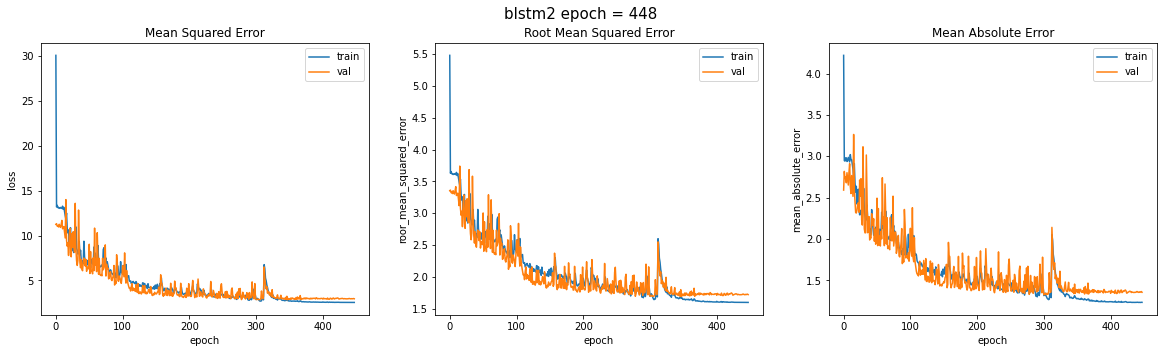

In [75]:
vis_results('blstm2', history_blstm2, epochs_blstm2)

In [76]:
results.update({'blstm2': eval_blstm2[1:]})

### lstm_fcn

In [77]:
eval_fcn, history_fcn, epochs_fcn = model_history(lstm_fcn, '/tmp/lstm_fcn.h5', 0.01)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100, 72)]    0           []                               
                                                                                                  
 conv1d_37 (Conv1D)             (None, 100, 128)     73856       ['input_13[0][0]']               
                                                                                                  
 batch_normalization_12 (BatchN  (None, 100, 128)    512         ['conv1d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_12 (Activation)     (None, 100, 128)     0           ['batch_normalization_12[0

10/10 [==============================] - 2s 230ms/step - loss: 6.2563 - mean_squared_error: 6.2563 - rmse: 2.5013 - mean_absolute_error: 1.9676 - val_loss: 14.6065 - val_mean_squared_error: 14.6065 - val_rmse: 3.8218 - val_mean_absolute_error: 2.8775 - lr: 0.0100
Epoch 9/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.6930 - mean_squared_error: 5.6930 - rmse: 2.3860 - mean_absolute_error: 1.8665
Epoch 00009: val_loss improved from 14.60651 to 9.56377, saving model to /tmp/lstm_fcn.h5
10/10 [==============================] - 2s 229ms/step - loss: 5.7203 - mean_squared_error: 5.7203 - rmse: 2.3917 - mean_absolute_error: 1.8731 - val_loss: 9.5638 - val_mean_squared_error: 9.5638 - val_rmse: 3.0925 - val_mean_absolute_error: 2.2972 - lr: 0.0100
Epoch 10/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.0064 - mean_squared_error: 6.0064 - rmse: 2.4508 - mean_absolute_error: 1.8898
Epoch 00010: val_loss did not improve from 9.56377
10/10 [=======================

Epoch 26/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.4563 - mean_squared_error: 3.4563 - rmse: 1.8591 - mean_absolute_error: 1.4745
Epoch 00026: val_loss did not improve from 8.08306
10/10 [==============================] - 2s 244ms/step - loss: 3.4771 - mean_squared_error: 3.4771 - rmse: 1.8647 - mean_absolute_error: 1.4806 - val_loss: 48.1313 - val_mean_squared_error: 48.1313 - val_rmse: 6.9377 - val_mean_absolute_error: 6.1069 - lr: 0.0100
Epoch 27/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.4742 - mean_squared_error: 3.4742 - rmse: 1.8639 - mean_absolute_error: 1.4594
Epoch 00027: val_loss did not improve from 8.08306
10/10 [==============================] - 2s 238ms/step - loss: 3.5163 - mean_squared_error: 3.5163 - rmse: 1.8752 - mean_absolute_error: 1.4650 - val_loss: 15.4465 - val_mean_squared_error: 15.4465 - val_rmse: 3.9302 - val_mean_absolute_error: 3.3402 - lr: 0.0100
Epoch 28/1000
 9/10 [==========================>...] - ETA: 0s - l

 9/10 [==========================>...] - ETA: 0s - loss: 2.3620 - mean_squared_error: 2.3620 - rmse: 1.5369 - mean_absolute_error: 1.2023
Epoch 00043: val_loss did not improve from 5.12932
10/10 [==============================] - 2s 232ms/step - loss: 2.3667 - mean_squared_error: 2.3667 - rmse: 1.5384 - mean_absolute_error: 1.2045 - val_loss: 37.4044 - val_mean_squared_error: 37.4044 - val_rmse: 6.1159 - val_mean_absolute_error: 5.3808 - lr: 0.0050
Epoch 44/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.2590 - mean_squared_error: 2.2590 - rmse: 1.5030 - mean_absolute_error: 1.1649
Epoch 00044: val_loss did not improve from 5.12932
10/10 [==============================] - 2s 222ms/step - loss: 2.2533 - mean_squared_error: 2.2533 - rmse: 1.5011 - mean_absolute_error: 1.1643 - val_loss: 45.0902 - val_mean_squared_error: 45.0902 - val_rmse: 6.7149 - val_mean_absolute_error: 6.0193 - lr: 0.0050
Epoch 45/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.0465 - 

Epoch 61/1000
 9/10 [==========================>...] - ETA: 0s - loss: 1.5347 - mean_squared_error: 1.5347 - rmse: 1.2388 - mean_absolute_error: 0.9598
Epoch 00061: val_loss did not improve from 5.12932
10/10 [==============================] - 2s 223ms/step - loss: 1.5732 - mean_squared_error: 1.5732 - rmse: 1.2543 - mean_absolute_error: 0.9694 - val_loss: 8.6434 - val_mean_squared_error: 8.6434 - val_rmse: 2.9400 - val_mean_absolute_error: 2.3250 - lr: 0.0025
Epoch 62/1000
 9/10 [==========================>...] - ETA: 0s - loss: 1.6738 - mean_squared_error: 1.6738 - rmse: 1.2937 - mean_absolute_error: 0.9865
Epoch 00062: val_loss did not improve from 5.12932
10/10 [==============================] - 2s 224ms/step - loss: 1.6774 - mean_squared_error: 1.6774 - rmse: 1.2951 - mean_absolute_error: 0.9880 - val_loss: 7.2147 - val_mean_squared_error: 7.2147 - val_rmse: 2.6860 - val_mean_absolute_error: 2.1323 - lr: 0.0025
Epoch 63/1000
 9/10 [==========================>...] - ETA: 0s - loss:

Epoch 79/1000
 9/10 [==========================>...] - ETA: 0s - loss: 1.2128 - mean_squared_error: 1.2128 - rmse: 1.1013 - mean_absolute_error: 0.8555
Epoch 00079: val_loss did not improve from 5.01852
10/10 [==============================] - 2s 230ms/step - loss: 1.2189 - mean_squared_error: 1.2189 - rmse: 1.1040 - mean_absolute_error: 0.8583 - val_loss: 7.9132 - val_mean_squared_error: 7.9132 - val_rmse: 2.8130 - val_mean_absolute_error: 2.2824 - lr: 0.0025
Epoch 80/1000
 9/10 [==========================>...] - ETA: 0s - loss: 1.1535 - mean_squared_error: 1.1535 - rmse: 1.0740 - mean_absolute_error: 0.8368
Epoch 00080: val_loss improved from 5.01852 to 4.14583, saving model to /tmp/lstm_fcn.h5
10/10 [==============================] - 2s 225ms/step - loss: 1.1565 - mean_squared_error: 1.1565 - rmse: 1.0754 - mean_absolute_error: 0.8391 - val_loss: 4.1458 - val_mean_squared_error: 4.1458 - val_rmse: 2.0361 - val_mean_absolute_error: 1.6396 - lr: 0.0025
Epoch 81/1000
 9/10 [===========

Epoch 97/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.9525 - mean_squared_error: 0.9525 - rmse: 0.9760 - mean_absolute_error: 0.7733
Epoch 00097: val_loss did not improve from 4.14583
10/10 [==============================] - 2s 229ms/step - loss: 0.9514 - mean_squared_error: 0.9514 - rmse: 0.9754 - mean_absolute_error: 0.7739 - val_loss: 6.8586 - val_mean_squared_error: 6.8586 - val_rmse: 2.6189 - val_mean_absolute_error: 2.1281 - lr: 0.0025
Epoch 98/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.8541 - mean_squared_error: 0.8541 - rmse: 0.9242 - mean_absolute_error: 0.7126
Epoch 00098: val_loss did not improve from 4.14583
10/10 [==============================] - 2s 223ms/step - loss: 0.8631 - mean_squared_error: 0.8631 - rmse: 0.9290 - mean_absolute_error: 0.7170 - val_loss: 8.4489 - val_mean_squared_error: 8.4489 - val_rmse: 2.9067 - val_mean_absolute_error: 2.2609 - lr: 0.0025
Epoch 99/1000
 9/10 [==========================>...] - ETA: 0s - loss:

 9/10 [==========================>...] - ETA: 0s - loss: 0.6033 - mean_squared_error: 0.6033 - rmse: 0.7767 - mean_absolute_error: 0.5937
Epoch 00114: val_loss improved from 4.06760 to 3.92950, saving model to /tmp/lstm_fcn.h5
10/10 [==============================] - 2s 241ms/step - loss: 0.6401 - mean_squared_error: 0.6401 - rmse: 0.8000 - mean_absolute_error: 0.6056 - val_loss: 3.9295 - val_mean_squared_error: 3.9295 - val_rmse: 1.9823 - val_mean_absolute_error: 1.5702 - lr: 0.0012
Epoch 115/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.6505 - mean_squared_error: 0.6505 - rmse: 0.8065 - mean_absolute_error: 0.6296
Epoch 00115: val_loss did not improve from 3.92950
10/10 [==============================] - 2s 243ms/step - loss: 0.6850 - mean_squared_error: 0.6850 - rmse: 0.8276 - mean_absolute_error: 0.6393 - val_loss: 7.9939 - val_mean_squared_error: 7.9939 - val_rmse: 2.8273 - val_mean_absolute_error: 2.2602 - lr: 0.0012
Epoch 116/1000
 9/10 [=======================

Epoch 132/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.5457 - mean_squared_error: 0.5457 - rmse: 0.7387 - mean_absolute_error: 0.5733
Epoch 00132: val_loss did not improve from 3.92950
10/10 [==============================] - 2s 232ms/step - loss: 0.5636 - mean_squared_error: 0.5636 - rmse: 0.7507 - mean_absolute_error: 0.5808 - val_loss: 6.4541 - val_mean_squared_error: 6.4541 - val_rmse: 2.5405 - val_mean_absolute_error: 1.9972 - lr: 0.0012
Epoch 133/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.5774 - mean_squared_error: 0.5774 - rmse: 0.7598 - mean_absolute_error: 0.5892
Epoch 00133: val_loss did not improve from 3.92950
10/10 [==============================] - 2s 232ms/step - loss: 0.6209 - mean_squared_error: 0.6209 - rmse: 0.7880 - mean_absolute_error: 0.6022 - val_loss: 4.8577 - val_mean_squared_error: 4.8577 - val_rmse: 2.2040 - val_mean_absolute_error: 1.7647 - lr: 0.0012
Epoch 134/1000
 9/10 [==========================>...] - ETA: 0s - lo

 9/10 [==========================>...] - ETA: 0s - loss: 0.3840 - mean_squared_error: 0.3840 - rmse: 0.6197 - mean_absolute_error: 0.4797
Epoch 00149: val_loss did not improve from 3.92950
10/10 [==============================] - 2s 229ms/step - loss: 0.3856 - mean_squared_error: 0.3856 - rmse: 0.6210 - mean_absolute_error: 0.4807 - val_loss: 4.9688 - val_mean_squared_error: 4.9688 - val_rmse: 2.2291 - val_mean_absolute_error: 1.8102 - lr: 6.2500e-04
Epoch 150/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.3665 - mean_squared_error: 0.3665 - rmse: 0.6054 - mean_absolute_error: 0.4626
Epoch 00150: val_loss did not improve from 3.92950
10/10 [==============================] - 2s 236ms/step - loss: 0.3759 - mean_squared_error: 0.3759 - rmse: 0.6131 - mean_absolute_error: 0.4664 - val_loss: 4.3858 - val_mean_squared_error: 4.3858 - val_rmse: 2.0942 - val_mean_absolute_error: 1.6550 - lr: 6.2500e-04
Epoch 151/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.3

 9/10 [==========================>...] - ETA: 0s - loss: 0.2913 - mean_squared_error: 0.2913 - rmse: 0.5397 - mean_absolute_error: 0.4180
Epoch 00166: val_loss did not improve from 3.92950
10/10 [==============================] - 2s 235ms/step - loss: 0.2993 - mean_squared_error: 0.2993 - rmse: 0.5471 - mean_absolute_error: 0.4214 - val_loss: 5.2255 - val_mean_squared_error: 5.2255 - val_rmse: 2.2859 - val_mean_absolute_error: 1.8434 - lr: 3.1250e-04
Epoch 167/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.3489 - mean_squared_error: 0.3489 - rmse: 0.5906 - mean_absolute_error: 0.4598
Epoch 00167: val_loss did not improve from 3.92950
10/10 [==============================] - 2s 238ms/step - loss: 0.3845 - mean_squared_error: 0.3845 - rmse: 0.6201 - mean_absolute_error: 0.4717 - val_loss: 4.9085 - val_mean_squared_error: 4.9085 - val_rmse: 2.2155 - val_mean_absolute_error: 1.7697 - lr: 3.1250e-04
Epoch 168/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.3

 9/10 [==========================>...] - ETA: 0s - loss: 0.3636 - mean_squared_error: 0.3636 - rmse: 0.6030 - mean_absolute_error: 0.4656
Epoch 00183: val_loss did not improve from 3.92950
10/10 [==============================] - 2s 221ms/step - loss: 0.4180 - mean_squared_error: 0.4180 - rmse: 0.6466 - mean_absolute_error: 0.4804 - val_loss: 4.5667 - val_mean_squared_error: 4.5667 - val_rmse: 2.1370 - val_mean_absolute_error: 1.7031 - lr: 1.5625e-04
Epoch 184/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.4256 - mean_squared_error: 0.4256 - rmse: 0.6524 - mean_absolute_error: 0.5097
Epoch 00184: val_loss did not improve from 3.92950
10/10 [==============================] - 2s 231ms/step - loss: 0.4245 - mean_squared_error: 0.4245 - rmse: 0.6515 - mean_absolute_error: 0.5089 - val_loss: 4.5889 - val_mean_squared_error: 4.5889 - val_rmse: 2.1422 - val_mean_absolute_error: 1.6960 - lr: 1.5625e-04
Epoch 185/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.3

 9/10 [==========================>...] - ETA: 0s - loss: 0.3137 - mean_squared_error: 0.3137 - rmse: 0.5600 - mean_absolute_error: 0.4355
Epoch 00200: val_loss did not improve from 3.92950
10/10 [==============================] - 2s 228ms/step - loss: 0.3358 - mean_squared_error: 0.3358 - rmse: 0.5795 - mean_absolute_error: 0.4444 - val_loss: 4.7173 - val_mean_squared_error: 4.7173 - val_rmse: 2.1719 - val_mean_absolute_error: 1.7352 - lr: 7.8125e-05
Epoch 201/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.2607 - mean_squared_error: 0.2607 - rmse: 0.5106 - mean_absolute_error: 0.3935
Epoch 00201: val_loss did not improve from 3.92950
10/10 [==============================] - 2s 233ms/step - loss: 0.2707 - mean_squared_error: 0.2707 - rmse: 0.5203 - mean_absolute_error: 0.3984 - val_loss: 6.8702 - val_mean_squared_error: 6.8702 - val_rmse: 2.6211 - val_mean_absolute_error: 2.0966 - lr: 7.8125e-05
Epoch 202/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.2

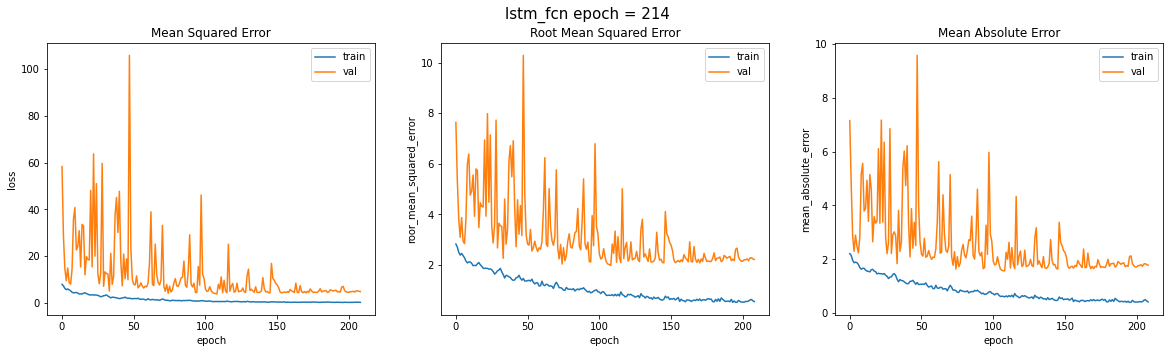

In [84]:
# plotting starting from epoch=5
vis_results('lstm_fcn', history_fcn, epochs_fcn)

In [85]:
results.update({'lstm_fcn': eval_fcn[1:]})

### cnn_resnet

In [86]:
eval_resnet, history_resnet, epochs_resnet = model_history(cnn_resnet, '/tmp/resnet.h5', 0.01)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 100, 72)]    0           []                               
                                                                                                  
 conv1d_40 (Conv1D)             (None, 100, 64)      36928       ['input_14[0][0]']               
                                                                                                  
 batch_normalization_15 (BatchN  (None, 100, 64)     256         ['conv1d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_15 (Activation)     (None, 100, 64)      0           ['batch_normalization_15[0

 9/10 [==========================>...] - ETA: 0s - loss: 44.9091 - mean_squared_error: 44.9091 - rmse: 6.7014 - mean_absolute_error: 5.2863
Epoch 00001: val_loss improved from inf to 13941847040.00000, saving model to /tmp/resnet.h5
10/10 [==============================] - 6s 394ms/step - loss: 44.5815 - mean_squared_error: 44.5815 - rmse: 6.6769 - mean_absolute_error: 5.2571 - val_loss: 13941847040.0000 - val_mean_squared_error: 13941847040.0000 - val_rmse: 118075.6016 - val_mean_absolute_error: 117595.5469 - lr: 0.0100
Epoch 2/1000
 9/10 [==========================>...] - ETA: 0s - loss: 11.4965 - mean_squared_error: 11.4965 - rmse: 3.3907 - mean_absolute_error: 2.7951
Epoch 00002: val_loss improved from 13941847040.00000 to 1667864448.00000, saving model to /tmp/resnet.h5
10/10 [==============================] - 3s 300ms/step - loss: 11.4508 - mean_squared_error: 11.4508 - rmse: 3.3839 - mean_absolute_error: 2.7866 - val_loss: 1667864448.0000 - val_mean_squared_error: 1667864448.000

 9/10 [==========================>...] - ETA: 0s - loss: 2.7437 - mean_squared_error: 2.7437 - rmse: 1.6564 - mean_absolute_error: 1.2880
Epoch 00017: val_loss did not improve from 11.56386
10/10 [==============================] - 3s 323ms/step - loss: 2.7539 - mean_squared_error: 2.7539 - rmse: 1.6595 - mean_absolute_error: 1.2917 - val_loss: 14.3534 - val_mean_squared_error: 14.3534 - val_rmse: 3.7886 - val_mean_absolute_error: 2.8218 - lr: 0.0100
Epoch 18/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.0776 - mean_squared_error: 3.0776 - rmse: 1.7543 - mean_absolute_error: 1.3669
Epoch 00018: val_loss did not improve from 11.56386
10/10 [==============================] - 3s 316ms/step - loss: 3.0855 - mean_squared_error: 3.0855 - rmse: 1.7566 - mean_absolute_error: 1.3704 - val_loss: 17.9606 - val_mean_squared_error: 17.9606 - val_rmse: 4.2380 - val_mean_absolute_error: 3.5862 - lr: 0.0100
Epoch 19/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.9015 

Epoch 35/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.3257 - mean_squared_error: 2.3257 - rmse: 1.5250 - mean_absolute_error: 1.2041
Epoch 00035: val_loss did not improve from 6.01969
10/10 [==============================] - 3s 305ms/step - loss: 2.3195 - mean_squared_error: 2.3195 - rmse: 1.5230 - mean_absolute_error: 1.2014 - val_loss: 39.3334 - val_mean_squared_error: 39.3334 - val_rmse: 6.2716 - val_mean_absolute_error: 5.7028 - lr: 0.0100
Epoch 36/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.1532 - mean_squared_error: 2.1532 - rmse: 1.4674 - mean_absolute_error: 1.1279
Epoch 00036: val_loss did not improve from 6.01969
10/10 [==============================] - 3s 304ms/step - loss: 2.1546 - mean_squared_error: 2.1546 - rmse: 1.4679 - mean_absolute_error: 1.1284 - val_loss: 13.4946 - val_mean_squared_error: 13.4946 - val_rmse: 3.6735 - val_mean_absolute_error: 3.1143 - lr: 0.0100
Epoch 37/1000
 9/10 [==========================>...] - ETA: 0s - l

Epoch 53/1000
 9/10 [==========================>...] - ETA: 0s - loss: 1.0418 - mean_squared_error: 1.0418 - rmse: 1.0207 - mean_absolute_error: 0.7885
Epoch 00053: val_loss did not improve from 5.18240
10/10 [==============================] - 3s 317ms/step - loss: 1.0432 - mean_squared_error: 1.0432 - rmse: 1.0214 - mean_absolute_error: 0.7896 - val_loss: 6.9928 - val_mean_squared_error: 6.9928 - val_rmse: 2.6444 - val_mean_absolute_error: 2.0310 - lr: 0.0050
Epoch 54/1000
 9/10 [==========================>...] - ETA: 0s - loss: 1.0248 - mean_squared_error: 1.0248 - rmse: 1.0123 - mean_absolute_error: 0.7797
Epoch 00054: val_loss did not improve from 5.18240
10/10 [==============================] - 3s 302ms/step - loss: 1.0362 - mean_squared_error: 1.0362 - rmse: 1.0180 - mean_absolute_error: 0.7822 - val_loss: 8.8958 - val_mean_squared_error: 8.8958 - val_rmse: 2.9826 - val_mean_absolute_error: 2.4937 - lr: 0.0050
Epoch 55/1000
 9/10 [==========================>...] - ETA: 0s - loss:

Epoch 71/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.8657 - mean_squared_error: 0.8657 - rmse: 0.9304 - mean_absolute_error: 0.7230
Epoch 00071: val_loss did not improve from 4.52251
10/10 [==============================] - 3s 305ms/step - loss: 0.8843 - mean_squared_error: 0.8843 - rmse: 0.9404 - mean_absolute_error: 0.7294 - val_loss: 6.3153 - val_mean_squared_error: 6.3153 - val_rmse: 2.5130 - val_mean_absolute_error: 1.9080 - lr: 0.0050
Epoch 72/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.9398 - mean_squared_error: 0.9398 - rmse: 0.9694 - mean_absolute_error: 0.7676
Epoch 00072: val_loss did not improve from 4.52251
10/10 [==============================] - 3s 309ms/step - loss: 0.9472 - mean_squared_error: 0.9472 - rmse: 0.9732 - mean_absolute_error: 0.7694 - val_loss: 6.8817 - val_mean_squared_error: 6.8817 - val_rmse: 2.6233 - val_mean_absolute_error: 2.0520 - lr: 0.0050
Epoch 73/1000
 9/10 [==========================>...] - ETA: 0s - loss:

Epoch 89/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.3775 - mean_squared_error: 0.3775 - rmse: 0.6144 - mean_absolute_error: 0.4826
Epoch 00089: val_loss did not improve from 4.52251
10/10 [==============================] - 3s 299ms/step - loss: 0.3767 - mean_squared_error: 0.3767 - rmse: 0.6137 - mean_absolute_error: 0.4822 - val_loss: 6.8470 - val_mean_squared_error: 6.8470 - val_rmse: 2.6167 - val_mean_absolute_error: 2.0470 - lr: 0.0025
Epoch 90/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.3733 - mean_squared_error: 0.3733 - rmse: 0.6110 - mean_absolute_error: 0.4744
Epoch 00090: val_loss did not improve from 4.52251
10/10 [==============================] - 3s 303ms/step - loss: 0.4158 - mean_squared_error: 0.4158 - rmse: 0.6448 - mean_absolute_error: 0.4879 - val_loss: 7.0756 - val_mean_squared_error: 7.0756 - val_rmse: 2.6600 - val_mean_absolute_error: 2.1043 - lr: 0.0025
Epoch 91/1000
 9/10 [==========================>...] - ETA: 0s - loss:

Epoch 107/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.4516 - mean_squared_error: 0.4516 - rmse: 0.6720 - mean_absolute_error: 0.5299
Epoch 00107: val_loss did not improve from 3.75850
10/10 [==============================] - 3s 305ms/step - loss: 0.4539 - mean_squared_error: 0.4539 - rmse: 0.6737 - mean_absolute_error: 0.5309 - val_loss: 4.8129 - val_mean_squared_error: 4.8129 - val_rmse: 2.1938 - val_mean_absolute_error: 1.7392 - lr: 0.0025
Epoch 108/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.3614 - mean_squared_error: 0.3614 - rmse: 0.6011 - mean_absolute_error: 0.4666
Epoch 00108: val_loss did not improve from 3.75850
10/10 [==============================] - 3s 316ms/step - loss: 0.3656 - mean_squared_error: 0.3656 - rmse: 0.6047 - mean_absolute_error: 0.4699 - val_loss: 4.9288 - val_mean_squared_error: 4.9288 - val_rmse: 2.2201 - val_mean_absolute_error: 1.7695 - lr: 0.0025
Epoch 109/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 125/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.2295 - mean_squared_error: 0.2295 - rmse: 0.4790 - mean_absolute_error: 0.3789
Epoch 00125: val_loss did not improve from 3.75850
10/10 [==============================] - 3s 313ms/step - loss: 0.2367 - mean_squared_error: 0.2367 - rmse: 0.4866 - mean_absolute_error: 0.3831 - val_loss: 4.6139 - val_mean_squared_error: 4.6139 - val_rmse: 2.1480 - val_mean_absolute_error: 1.7309 - lr: 0.0012
Epoch 126/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.2300 - mean_squared_error: 0.2300 - rmse: 0.4796 - mean_absolute_error: 0.3832
Epoch 00126: val_loss did not improve from 3.75850
10/10 [==============================] - 3s 296ms/step - loss: 0.2367 - mean_squared_error: 0.2367 - rmse: 0.4865 - mean_absolute_error: 0.3877 - val_loss: 4.4406 - val_mean_squared_error: 4.4406 - val_rmse: 2.1073 - val_mean_absolute_error: 1.6909 - lr: 0.0012
Epoch 127/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 143/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.2135 - mean_squared_error: 0.2135 - rmse: 0.4621 - mean_absolute_error: 0.3706
Epoch 00143: val_loss did not improve from 3.75850
10/10 [==============================] - 3s 303ms/step - loss: 0.2184 - mean_squared_error: 0.2184 - rmse: 0.4673 - mean_absolute_error: 0.3739 - val_loss: 4.1827 - val_mean_squared_error: 4.1827 - val_rmse: 2.0452 - val_mean_absolute_error: 1.6254 - lr: 6.2500e-04
Epoch 144/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1615 - mean_squared_error: 0.1615 - rmse: 0.4018 - mean_absolute_error: 0.3168
Epoch 00144: val_loss did not improve from 3.75850
10/10 [==============================] - 3s 296ms/step - loss: 0.1711 - mean_squared_error: 0.1711 - rmse: 0.4136 - mean_absolute_error: 0.3220 - val_loss: 4.3855 - val_mean_squared_error: 4.3855 - val_rmse: 2.0942 - val_mean_absolute_error: 1.6526 - lr: 6.2500e-04
Epoch 145/1000
 9/10 [==========================>...] - ETA:

 9/10 [==========================>...] - ETA: 0s - loss: 0.2467 - mean_squared_error: 0.2467 - rmse: 0.4967 - mean_absolute_error: 0.3843
Epoch 00160: val_loss did not improve from 3.75850
10/10 [==============================] - 3s 296ms/step - loss: 0.2685 - mean_squared_error: 0.2685 - rmse: 0.5182 - mean_absolute_error: 0.3932 - val_loss: 6.1429 - val_mean_squared_error: 6.1429 - val_rmse: 2.4785 - val_mean_absolute_error: 1.9973 - lr: 3.1250e-04
Epoch 161/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1316 - mean_squared_error: 0.1316 - rmse: 0.3627 - mean_absolute_error: 0.2870
Epoch 00161: val_loss did not improve from 3.75850
10/10 [==============================] - 3s 302ms/step - loss: 0.1346 - mean_squared_error: 0.1346 - rmse: 0.3669 - mean_absolute_error: 0.2892 - val_loss: 5.8698 - val_mean_squared_error: 5.8698 - val_rmse: 2.4228 - val_mean_absolute_error: 1.9426 - lr: 3.1250e-04
Epoch 162/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1

Epoch 178/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1595 - mean_squared_error: 0.1595 - rmse: 0.3994 - mean_absolute_error: 0.3172
Epoch 00178: val_loss did not improve from 3.75850

Epoch 00178: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
10/10 [==============================] - 3s 301ms/step - loss: 0.1792 - mean_squared_error: 0.1792 - rmse: 0.4233 - mean_absolute_error: 0.3251 - val_loss: 4.5664 - val_mean_squared_error: 4.5664 - val_rmse: 2.1369 - val_mean_absolute_error: 1.7060 - lr: 3.1250e-04
Epoch 179/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.2435 - mean_squared_error: 0.2435 - rmse: 0.4934 - mean_absolute_error: 0.3773
Epoch 00179: val_loss did not improve from 3.75850
10/10 [==============================] - 3s 298ms/step - loss: 0.2438 - mean_squared_error: 0.2438 - rmse: 0.4938 - mean_absolute_error: 0.3778 - val_loss: 4.3675 - val_mean_squared_error: 4.3675 - val_rmse: 2.0898 - val_mean_absolute_error: 1.

 9/10 [==========================>...] - ETA: 0s - loss: 0.1641 - mean_squared_error: 0.1641 - rmse: 0.4051 - mean_absolute_error: 0.3238
Epoch 00195: val_loss did not improve from 3.75850
10/10 [==============================] - 3s 298ms/step - loss: 0.2475 - mean_squared_error: 0.2475 - rmse: 0.4975 - mean_absolute_error: 0.3458 - val_loss: 4.4068 - val_mean_squared_error: 4.4068 - val_rmse: 2.0992 - val_mean_absolute_error: 1.6628 - lr: 1.5625e-04
Epoch 196/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.2148 - mean_squared_error: 0.2148 - rmse: 0.4634 - mean_absolute_error: 0.3533
Epoch 00196: val_loss did not improve from 3.75850
10/10 [==============================] - 3s 297ms/step - loss: 0.2164 - mean_squared_error: 0.2164 - rmse: 0.4652 - mean_absolute_error: 0.3546 - val_loss: 4.4802 - val_mean_squared_error: 4.4802 - val_rmse: 2.1166 - val_mean_absolute_error: 1.6693 - lr: 1.5625e-04
Epoch 197/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1

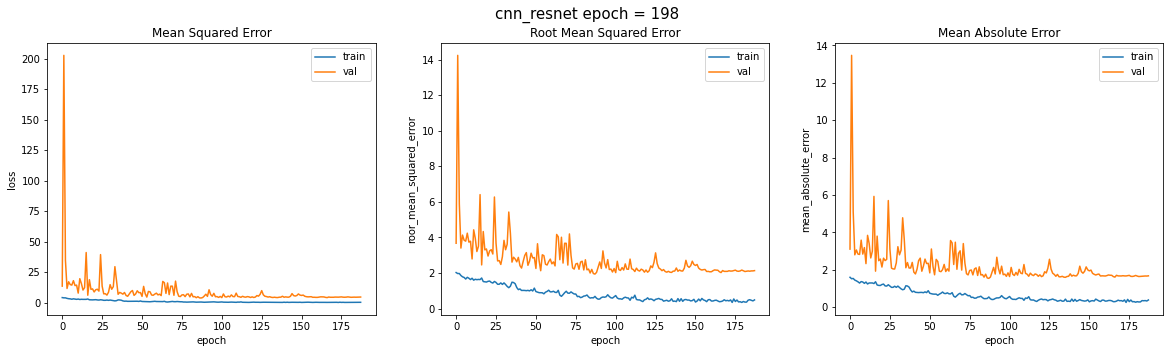

In [93]:
# plotting starting from epoch=10
vis_results('cnn_resnet', history_resnet, epochs_resnet)

In [95]:
results.update({'cnn_resnet': eval_resnet[1:]})

In [96]:
results

{'cnn_lenet': [6.695454120635986, 2.587557554244995, 1.8583043813705444],
 'mlp4': [6.005496978759766, 2.4506115913391113, 1.9281479120254517],
 'cnn_vgg': [5.553559303283691, 2.3565990924835205, 1.7811247110366821],
 'lstm1v0': [5.448915481567383, 2.3342912197113037, 1.7542086839675903],
 'lstm1': [6.404674053192139, 2.5307457447052, 1.8755989074707031],
 'lstm2': [6.038021087646484, 2.4572384357452393, 1.8316905498504639],
 'blstm1': [4.331417083740234, 2.0812056064605713, 1.5984240770339966],
 'blstm2': [4.531678676605225, 2.1287739276885986, 1.610222339630127],
 'lstm_fcn': [5.3880696296691895, 2.3212215900421143, 1.7712501287460327],
 'cnn_resnet': [5.273154258728027, 2.296334981918335, 1.6895924806594849]}